# 1 - Data Cleaning

## 1.1 - Import datasets

In [87]:
import pandas as pd
from pathlib import Path

# We clean column names
def clean_column_names(df):
    df.columns = (
        df.columns
        .str.strip()                              # remove leading/trailing spaces
        .str.lower()                              # convert to lowercase
        .str.replace(r"[^\w]+", "_", regex=True)  # non-alphanumeric → underscore
        .str.strip("_")                           # remove leading/trailing _
    )
    return df

# We set the option to see all columns when displaying a dataframe
pd.set_option('display.max_columns', None)

data_dir = Path("../datasets")  
aba_law_schools = clean_column_names(pd.read_csv(data_dir / "aba_law_schools.csv"))
appointments    = clean_column_names(pd.read_csv(data_dir / "appointments.csv"))
attorneys       = clean_column_names(pd.read_csv(data_dir / "attorneys.csv"))
mdls            = clean_column_names(pd.read_csv(data_dir / "mdls.csv"))
orders          = clean_column_names(pd.read_csv(data_dir / "orders.csv"))


## 1.2 - Clean appointments dataset

In [88]:
import re
import pandas as pd

# Standardize firm names: lowercase, remove extra whitespace and special characters
appointments["firm"] = (
    appointments["firm"]
    .astype(str)
    .str.lower()
    .str.strip()
    .str.replace(r'[^a-z0-9\s&.,-]', '', regex=True)  # Keep alphanumeric and common punctuation
    .str.replace(r'\s+', ' ', regex=True)  # Collapse multiple spaces
)

# Extract numeric attorney ID from attorney column
appointments["attorney_id"] = (
    appointments["attorney"]
    .astype(str)
    .str.extract(r'(\d+)', expand=False)  # More efficient than apply(lambda)
)

# Convert MDL number to nullable integer (handles missing/invalid values gracefully)
appointments["mdl_no_from_orders"] = pd.to_numeric(
    appointments["mdl_no_from_orders"],
    errors='coerce'  # Convert non-numeric values to NaN
).astype("Int64")

appointments

,appointment_id,orders,mdl_no_from_orders,order_no,last_name,first_name,first_last_calculated,firm,attorney,canonical_name_from_attorney,appoint,remove,interim,appointment_types,appointee_type,plaintiff_defendant,attorney_id
0,1431-16-1,1431-16,1431,1431-16,Zimmerman,Charles,Charles Zimmerman,zimmerman reed,1-Charles S. Zimmerman,Charles S. Zimmerman,checked,NaN,NaN,LeadCounsel,Individual,Plaintiff,1
1,1431-16-2,1431-16,1431,1431-16,Lockridge,Richard,Richard Lockridge,lockridge grindal nauen p.l.l.p.,2-Richard A. Lockridge,Richard A. Lockridge,checked,NaN,NaN,LeadCounsel,Individual,Plaintiff,2
2,1431-16-3,1431-16,1431,1431-16,Heins,Samuel,Samuel Heins,"heins mills & olson, p.l.c.",3-Samuel D. Heins,Samuel D. Heins,checked,NaN,NaN,Management,Individual,Plaintiff,3
3,1431-16-4,1431-16,1431,1431-16,Birchfield,Andy,Andy Birchfield,"beasley, allen, crow, methvin, portis & miles,...",4-Anthony D. Birchfield Jr,Anthony D. Birchfield Jr,checked,NaN,NaN,Management,Individual,Plaintiff,4
4,1431-16-5,1431-16,1431,1431-16,Barrett,Don,Don Barrett,barrett law office,5-John W. Barrett,John W. Barrett,checked,NaN,NaN,Management,Individual,Plaintiff,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6149,2599-4856-6368,2599-4856,2599,2599-4856,Smith,Todd,Todd Smith,smith lacien llp,552-Todd A. Smith,Todd A. Smith,checked,NaN,NaN,ClassCounsel,Individual,Plaintiff,552
6150,2599-4856-6369,2599-4856,2599,2599-4856,Boies,David,David Boies,"boies, schiller & flexner llp",550-David Boies II,David Boies II,checked,NaN,NaN,ClassCounsel,Individual,Plaintiff,550
6151,2599-4856-6370,2599-4856,2599,2599-4856,Cabraser,Elizabeth,Elizabeth Cabraser,lieff cabraser heimann & bernstein llp,7-Elizabeth J. Cabraser,Elizabeth J. Cabraser,checked,NaN,NaN,ClassCounsel,Individual,Plaintiff,7
6152,2599-4856-6371,2599-4856,2599,2599-4856,Cecchi,James,James Cecchi,"carella byrne cecchi olstein brody & agnello, pc",176-James E. Cecchi,James E. Cecchi,checked,NaN,NaN,ClassCounsel,Individual,Plaintiff,176


## 1.3 - Get MDL x attorney dataframe (plaintiff side)

In [89]:
import pandas as pd
import re

# ============================================================
# 0. Setup + canonical name detection
# ============================================================

appts = appointments.copy()

# Identify which column contains attorney names (may vary by dataset version)
cn_candidates = [
    c for c in appts.columns
    if "canonical_name" in c.lower() or "first_last_calculated" in c.lower()
]

if len(cn_candidates) == 0:
    raise ValueError("❌ No canonical name column found in appointments.")
elif "canonical_name_from_attorney" in cn_candidates:
    canonical_col = "canonical_name_from_attorney"
elif "canonical_name" in cn_candidates:
    canonical_col = "canonical_name"
else:
    canonical_col = cn_candidates[0]


appts["canonical_name"] = appts[canonical_col].astype(str).str.strip()

# ============================================================
# 1. Normalize firm names
# ============================================================

# Coerce firm column to list format (may arrive as string or list)
appts["firm"] = appts["firm"].apply(lambda x: x if isinstance(x, list) else [x])

def normalize_firm(f):
    """Convert firm name to uppercase, handle missing values."""
    if f is None:
        return None
    f = str(f).strip()
    if f.lower() in ["", "nan", "none", "[]"]:
        return None
    return f.upper()

appts["firm_clean_list"] = appts["firm"].apply(
    lambda L: [normalize_firm(i) for i in L if normalize_firm(i) is not None]
)

# ============================================================
# 2. Helper functions
# ============================================================

def choose_stable_firm(firm_lists):
    """Select most frequent firm across all appointments for an attorney-MDL pair."""
    flat = []
    for sub in firm_lists:
        flat.extend(sub)
    if len(flat) == 0:
        return None
    return pd.Series(flat).value_counts().idxmax()

def uniq_list(x):
    """Return sorted list of unique non-missing values."""
    vals = [str(i).strip() for i in x if str(i).strip().lower() not in ["", "nan", "none", "[]"]]
    return sorted(set(vals))

def mode_or_first(x):
    """Return most frequent value; break ties with first occurrence."""
    x = [i for i in x if str(i).strip().lower() not in ["", "nan", "none"]]
    if len(x) == 0:
        return None
    return pd.Series(x).value_counts().idxmax()

# ============================================================
# 3. Collapse pelvic mesh MDLs → 9999
# ============================================================

# Consolidate related pelvic mesh litigation into single category for analysis
pelvic_mesh_mdls = [2187, 2325, 2326, 2327, 2387, 2440]
appts["mdl_no_from_orders"] = (
    appts["mdl_no_from_orders"]
    .astype("Int64")
    .replace(pelvic_mesh_mdls, 9999)
)

# ============================================================
# 4. Clean role column
# ============================================================

# Standardize appointment role (use appoint column first, fall back to alternatives)
appts["role"] = (
    appts["appoint"]
    .fillna(appts["appointment_types"])
    .fillna(appts["appointee_type"])
    .astype(str)
    .str.strip()
    .str.upper()
)

# ============================================================
# 5. Clean plaintiff / defendant
# ============================================================

def normalize_pd(x):
    """Normalize plaintiff/defendant classification; handle list and string inputs."""
    if isinstance(x, list):
        vals = [str(i).strip().lower() for i in x
                if str(i).strip().lower() not in ["", "nan", "none"]]
        if len(vals) == 0:
            return None
        return vals[0] if len(set(vals)) == 1 else max(vals)
    else:
        val = str(x).strip().lower()
        return val if val not in ["", "nan", "none"] else None

appts["pd_clean"] = appts["plaintiff_defendant"].apply(normalize_pd)

# ============================================================
# 6. Stable firm PER attorney × MDL
# ============================================================

# For each unique attorney-MDL pair, identify the most common firm representation
stable_firms = (
    appts.groupby(["attorney_id", "mdl_no_from_orders"])["firm_clean_list"]
    .apply(choose_stable_firm)
    .reset_index()
    .rename(columns={"firm_clean_list": "stable_firm"})
)

appts = appts.merge(
    stable_firms,
    on=["attorney_id", "mdl_no_from_orders"],
    how="left"
)

# ============================================================
# 7. FINAL collapse: one attorney × one MDL
# ============================================================

# Aggregate multiple appointment records into single attorney-MDL observation
final = (
    appts.groupby(["attorney_id", "mdl_no_from_orders"])
    .agg({
        "attorney": mode_or_first,
        "canonical_name": mode_or_first,
        "role": uniq_list,
        "appoint": uniq_list,
        "appointment_types": uniq_list,
        "appointee_type": uniq_list,
        "pd_clean": "first",
        "stable_firm": "first",
    })
    .reset_index()
)

final = final.rename(columns={
    "stable_firm": "firm",
    "pd_clean": "plaintiff_defendant"
})

# ============================================================
# 8. Restrict to confirmed appointments
# ============================================================

# Include only appointments explicitly marked as "checked" (validated by hand review)
final = final[final["appoint"].apply(lambda x: "checked" in x)]

# ============================================================
# 9. LEFT JOIN with attorneys table
# ============================================================

# Merge in attorney demographic and educational data
cols_to_keep = [
    "attorney_id",
    "undergrad_school", "undergrad_grad_year",
    "law_school", "law_school_name", "law_grad_year",
    "gender", "race", "bar_states", "sources", "notes"
]

attorneys["attorney_id"] = attorneys["attorney_id"].astype(str)
final["attorney_id"] = final["attorney_id"].astype(str)

final = final.merge(
    attorneys[cols_to_keep],
    on="attorney_id",
    how="left"
)

# Optional cleanup
final = final.drop(columns=["race"], errors="ignore")

# Create plaintiff-only subset for separate analysis
attorney_x_mdl = final.copy()
attorney_x_mdl = attorney_x_mdl[attorney_x_mdl["plaintiff_defendant"] == "plaintiff"]

display(final)

,attorney_id,mdl_no_from_orders,attorney,canonical_name,role,appoint,appointment_types,appointee_type,plaintiff_defendant,firm,undergrad_school,undergrad_grad_year,law_school,law_school_name,law_grad_year,gender,bar_states,sources,notes
0,1,1431,1-Charles S. Zimmerman,Charles S. Zimmerman,[CHECKED],[checked],[LeadCounsel],[Individual],plaintiff,ZIMMERMAN REED,University of Minnesota,1969.0,MINNESOTA,MINNESOTA,1972.0,M,MN-1972,'- Birth year: Lexis + Public Records (https:/...,- States of admission: died in 2019.
1,1,2323,1-Charles S. Zimmerman,Charles S. Zimmerman,"[CHECKED, MANAGEMENT]",[checked],[Management],[Individual],plaintiff,NaN,University of Minnesota,1969.0,MINNESOTA,MINNESOTA,1972.0,M,MN-1972,'- Birth year: Lexis + Public Records (https:/...,- States of admission: died in 2019.
2,1,2492,1-Charles S. Zimmerman,Charles S. Zimmerman,[CHECKED],[checked],[Management],[Individual],plaintiff,"ZIMMERMAN REED, PLLP",University of Minnesota,1969.0,MINNESOTA,MINNESOTA,1972.0,M,MN-1972,'- Birth year: Lexis + Public Records (https:/...,- States of admission: died in 2019.
3,1,2522,1-Charles S. Zimmerman,Charles S. Zimmerman,[CHECKED],[checked],"[LeadCounsel, Settlement]",[Individual],plaintiff,"ZIMMERMAN REED, PLLP",University of Minnesota,1969.0,MINNESOTA,MINNESOTA,1972.0,M,MN-1972,'- Birth year: Lexis + Public Records (https:/...,- States of admission: died in 2019.
4,1,2820,1-Charles S. Zimmerman,Charles S. Zimmerman,"[CHECKED, MANAGEMENT]",[checked],[Management],[Individual],plaintiff,ZIMMERMAN REED LLP,University of Minnesota,1969.0,MINNESOTA,MINNESOTA,1972.0,M,MN-1972,'- Birth year: Lexis + Public Records (https:/...,- States of admission: died in 2019.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2453,999,2522,999-Ariana J. Tadler,Ariana J. Tadler,[CHECKED],[checked],"[Management, Settlement]",[Individual],plaintiff,"MILBERG, LLP",Hamilton College,1989.0,FORDHAM,FORDHAM,1992.0,F,NJ-1992; NY-1993,'- Birth year: Lexis + Public Records (https:/...,NaN
2454,999,2752,999-Ariana J. Tadler,Ariana J. Tadler,[CHECKED],[checked],[Management],[Individual],plaintiff,MILBERG LLP,Hamilton College,1989.0,FORDHAM,FORDHAM,1992.0,F,NJ-1992; NY-1993,'- Birth year: Lexis + Public Records (https:/...,NaN
2455,999,2800,999-Ariana J. Tadler,Ariana J. Tadler,[CHECKED],[checked],[Management],[Individual],plaintiff,MILBERG TADLER PHILLIPS GROSSMAN LLP,Hamilton College,1989.0,FORDHAM,FORDHAM,1992.0,F,NJ-1992; NY-1993,'- Birth year: Lexis + Public Records (https:/...,NaN
2456,999,2827,999-Ariana J. Tadler,Ariana J. Tadler,[CHECKED],[checked],"[Discovery, Management]",[Individual],plaintiff,MILBERG TADLER PHILLIPS GROSSMAN LLP,Hamilton College,1989.0,FORDHAM,FORDHAM,1992.0,F,NJ-1992; NY-1993,'- Birth year: Lexis + Public Records (https:/...,NaN


## 1.4 - Combine attorney x mdl dataset, with firms x mdl dataset

In [90]:
import pandas as pd
import re

# ============================================================
# 0. PREPARE APPOINTMENTS DATA
# ============================================================

appts = appointments.copy()

# Coerce list-typed fields to ensure consistent format
appts["appointee_type"] = appts["appointee_type"].apply(
    lambda x: x if isinstance(x, list) else [x]
)
appts["appoint"] = appts["appoint"].apply(
    lambda x: x if isinstance(x, list) else [x]
)

# Normalize case once for filtering (lowercase for appoint, uppercase for appointee_type)
appts["appointee_type_norm"] = appts["appointee_type"].apply(
    lambda L: [str(i).strip().upper() for i in L]
)
appts["appoint_norm"] = appts["appoint"].apply(
    lambda L: [str(i).strip().lower() for i in L]
)

# Filter: keep only firm appointees with checked status
appts = appts[
    appts["appointee_type_norm"].apply(lambda x: "FIRM" in x) &
    appts["appoint_norm"].apply(lambda x: "checked" in x)
]

# ============================================================
# 1. NORMALIZE FIRM NAMES
# ============================================================

appts["firm"] = appts["firm"].apply(
    lambda x: x if isinstance(x, list) else [x]
)

def normalize_firm(f):
    """Convert firm to uppercase; treat missing values as None."""
    if f is None:
        return None
    f = str(f).strip()
    if f.lower() in ["", "nan", "none", "[]"]:
        return None
    return f.upper()

appts["firm_clean_list"] = appts["firm"].apply(
    lambda L: [normalize_firm(i) for i in L if normalize_firm(i) is not None]
)

# ============================================================
# 2. CONSOLIDATE MDL NUMBERS
# ============================================================

# Merge related pelvic mesh litigation into single category
pelvic_mesh_mdls = [2187, 2325, 2326, 2327, 2387, 2440]
appts["mdl_no_from_orders"] = appts["mdl_no_from_orders"].replace(
    pelvic_mesh_mdls, 9999
)

# ============================================================
# 3. NORMALIZE PLAINTIFF/DEFENDANT FIELD
# ============================================================

def normalize_pd(x):
    """Extract and standardize plaintiff/defendant classification."""
    if isinstance(x, list):
        vals = [
            str(i).strip().lower()
            for i in x
            if str(i).strip().lower() not in ["", "nan", "none"]
        ]
        if len(vals) == 0:
            return None
        return vals[0] if len(set(vals)) == 1 else max(vals)
    else:
        val = str(x).strip().lower()
        return val if val not in ["", "nan", "none"] else None

appts["plaintiff_defendant"] = appts["plaintiff_defendant"].apply(normalize_pd)

# ============================================================
# 4. BUILD FIRM × MDL DATASET
# ============================================================

def uniq_list(x):
    """Return sorted list of unique non-missing string values."""
    vals = [
        str(i).strip()
        for i in x
        if str(i).strip().lower() not in ["", "nan", "none", "[]"]
    ]
    return sorted(set(vals))

# Explode firm list and aggregate by firm-MDL pair
firm_mdl = (
    appts
    .explode("firm_clean_list")
    .groupby(["firm_clean_list", "mdl_no_from_orders"])
    .agg({
        "appointment_types": uniq_list,
        "appoint": uniq_list,
        "plaintiff_defendant": "first",
    })
    .reset_index()
    .rename(columns={"firm_clean_list": "firm"})
)

# ============================================================
# 5. MERGE ATTORNEY × MDL AND FIRM × MDL DATASETS
# ============================================================

# Add unit-of-analysis flag to both datasets
final["unit"] = "ATTORNEY"
firm_mdl["unit"] = "FIRM"

# Ensure both datasets have identical columns
all_cols = sorted(set(final.columns) | set(firm_mdl.columns))
final = final.reindex(columns=all_cols)
firm_mdl = firm_mdl.reindex(columns=all_cols)

# Concatenate datasets
combined = pd.concat([final, firm_mdl], axis=0, ignore_index=True)

# Add convenience binary flags
combined["is_firm"] = (combined["unit"] == "FIRM").astype(int)
combined["is_attorney"] = (combined["unit"] == "ATTORNEY").astype(int)

# ============================================================
# 6. CLUSTER SIMILAR FIRM NAMES BY TOKEN OVERLAP
# ============================================================

# Preserve original firm name before clustering
combined["firm_initial"] = combined["firm"]

# Define stopwords to exclude from firm name tokenization
STOPWORDS = {
    "llp", "llc", "pllc", "pllp", "pc", "pa", "inc", "corp",
    "corporation", "company", "co", "the", "law", "firm", "offices"
}

def tokenize_firm(f):
    """Extract meaningful tokens from firm name."""
    if f is None or pd.isna(f):
        return set()
    f = str(f).lower()
    # Remove punctuation, split on whitespace
    f = re.sub(r"[^\w\s]", " ", f)
    return {
        t for t in f.split()
        if len(t) > 1 and t not in STOPWORDS
    }

# Build unique firm list with tokenized names
firm_table = (
    combined[["firm_initial"]]
    .dropna()
    .drop_duplicates()
    .reset_index(drop=True)
)
firm_table["tokens"] = firm_table["firm_initial"].apply(tokenize_firm)

# ============================================================
# 7. GREEDY CLUSTERING: GROUP FIRMS BY TOKEN OVERLAP
# ============================================================

# Merge firm names that share 60%+ token overlap
THRESHOLD = 0.6
visited = set()
clusters = []

for i, row in firm_table.iterrows():
    if i in visited:
        continue

    base_tokens = row["tokens"]
    if not base_tokens:
        continue

    cluster = [i]
    visited.add(i)

    # Find all firms similar enough to seed firm
    for j, other in firm_table.iterrows():
        if j in visited:
            continue

        other_tokens = other["tokens"]
        if not other_tokens:
            continue

        # Jaccard-like overlap metric
        overlap = len(base_tokens & other_tokens) / min(len(base_tokens), len(other_tokens))
        if overlap >= THRESHOLD:
            cluster.append(j)
            visited.add(j)

    clusters.append(cluster)

# ============================================================
# 8. SELECT CANONICAL FIRM NAME PER CLUSTER
# ============================================================

# For each cluster, use longest name as canonical (most specific)
correction_map = {}

for cluster in clusters:
    names = firm_table.loc[cluster, "firm_initial"].tolist()
    canonical = max(names, key=len)
    for idx in cluster:
        correction_map[firm_table.loc[idx, "firm_initial"]] = canonical

# Convert correction map to lookup table
firm_fix = (
    pd.DataFrame.from_dict(correction_map, orient="index")
    .reset_index()
    .rename(columns={"index": "firm_initial", 0: "firm_corrected"})
)

# ============================================================
# 9. APPLY CORRECTIONS TO COMBINED DATASET
# ============================================================

combined = combined.merge(firm_fix, on="firm_initial", how="left")

# Update firm name with corrected version where available
combined["firm"] = combined["firm_corrected"].combine_first(combined["firm"])

# Cleanup intermediate column
combined = combined.drop(columns=["firm_corrected"])

# ============================================================
# RESULTS
# ============================================================

display(
    combined[["firm_initial", "firm"]]
    .drop_duplicates()
    .sort_values("firm")
)

combined

,firm_initial,firm
1742,ABBOTT LAW GROUP,ABBOTT LAW GROUP
2458,"ABRAHAM FRUCHTER & TWERSKY, LLP","ABRAHAM, FRUCHTER & TWERSKY, LLP"
2459,"ABRAHAM, FRUCHTER & TWERSKY, LLP","ABRAHAM, FRUCHTER & TWERSKY, LLP"
276,ADEMI LLP,"ADEMI & OREILLY, LLP"
275,"ADEMI & OREILLY, LLP","ADEMI & OREILLY, LLP"
...,...,...
1227,ZOLL KRANZ & BORGESS,"ZOLL, KRANZ & BORGESS LLC"
2191,ZONIES LAW LLC,ZONIES LAW LLC
572,ZUCKERMAN SPAEDER LLP,ZUCKERMAN SPAEDER LLP
895,"ZWERLING, SCHACHTER & ZWERLING, LLP","ZWERLING, SCHACHTER & ZWERLING, LLP"


,appoint,appointee_type,appointment_types,attorney,attorney_id,bar_states,canonical_name,firm,gender,law_grad_year,law_school,law_school_name,mdl_no_from_orders,notes,plaintiff_defendant,role,sources,undergrad_grad_year,undergrad_school,unit,is_firm,is_attorney,firm_initial
0,[checked],[Individual],[LeadCounsel],1-Charles S. Zimmerman,1,MN-1972,Charles S. Zimmerman,ZIMMERMAN REED P.L.L.P.,M,1972.0,MINNESOTA,MINNESOTA,1431,- States of admission: died in 2019.,plaintiff,[CHECKED],'- Birth year: Lexis + Public Records (https:/...,1969.0,University of Minnesota,ATTORNEY,0,1,ZIMMERMAN REED
1,[checked],[Individual],[Management],1-Charles S. Zimmerman,1,MN-1972,Charles S. Zimmerman,NaN,M,1972.0,MINNESOTA,MINNESOTA,2323,- States of admission: died in 2019.,plaintiff,"[CHECKED, MANAGEMENT]",'- Birth year: Lexis + Public Records (https:/...,1969.0,University of Minnesota,ATTORNEY,0,1,NaN
2,[checked],[Individual],[Management],1-Charles S. Zimmerman,1,MN-1972,Charles S. Zimmerman,ZIMMERMAN REED P.L.L.P.,M,1972.0,MINNESOTA,MINNESOTA,2492,- States of admission: died in 2019.,plaintiff,[CHECKED],'- Birth year: Lexis + Public Records (https:/...,1969.0,University of Minnesota,ATTORNEY,0,1,"ZIMMERMAN REED, PLLP"
3,[checked],[Individual],"[LeadCounsel, Settlement]",1-Charles S. Zimmerman,1,MN-1972,Charles S. Zimmerman,ZIMMERMAN REED P.L.L.P.,M,1972.0,MINNESOTA,MINNESOTA,2522,- States of admission: died in 2019.,plaintiff,[CHECKED],'- Birth year: Lexis + Public Records (https:/...,1969.0,University of Minnesota,ATTORNEY,0,1,"ZIMMERMAN REED, PLLP"
4,[checked],[Individual],[Management],1-Charles S. Zimmerman,1,MN-1972,Charles S. Zimmerman,ZIMMERMAN REED P.L.L.P.,M,1972.0,MINNESOTA,MINNESOTA,2820,- States of admission: died in 2019.,plaintiff,"[CHECKED, MANAGEMENT]",'- Birth year: Lexis + Public Records (https:/...,1969.0,University of Minnesota,ATTORNEY,0,1,ZIMMERMAN REED LLP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,[['checked']],NaN,[ClassCounsel],NaN,NaN,NaN,NaN,ZIMMERMAN REED P.L.L.P.,NaN,NaN,NaN,NaN,2807,NaN,plaintiff,NaN,NaN,NaN,NaN,FIRM,1,0,ZIMMERMAN REED LLP
2925,[['checked']],NaN,"[ClassCounsel,LeadCounsel]",NaN,NaN,NaN,NaN,ZIMMERMAN REED P.L.L.P.,NaN,NaN,NaN,NaN,2522,NaN,plaintiff,NaN,NaN,NaN,NaN,FIRM,1,0,ZIMMERMAN REED PLLP
2926,[['checked']],NaN,[Settlement],NaN,NaN,NaN,NaN,ZIMMERMAN REED P.L.L.P.,NaN,NaN,NaN,NaN,2522,NaN,plaintiff,NaN,NaN,NaN,NaN,FIRM,1,0,"ZIMMERMAN REED, LLP"
2927,[['checked']],NaN,[Communications],NaN,NaN,NaN,NaN,ZUCKERMAN SPAEDER LLP,NaN,NaN,NaN,NaN,2296,NaN,plaintiff,NaN,NaN,NaN,NaN,FIRM,1,0,ZUCKERMAN SPAEDER LLP


# 2 - Figures (Main paper)

## 2.1 - Figure 6 : Distribution of Co-Appointments for All MDL Attorneys

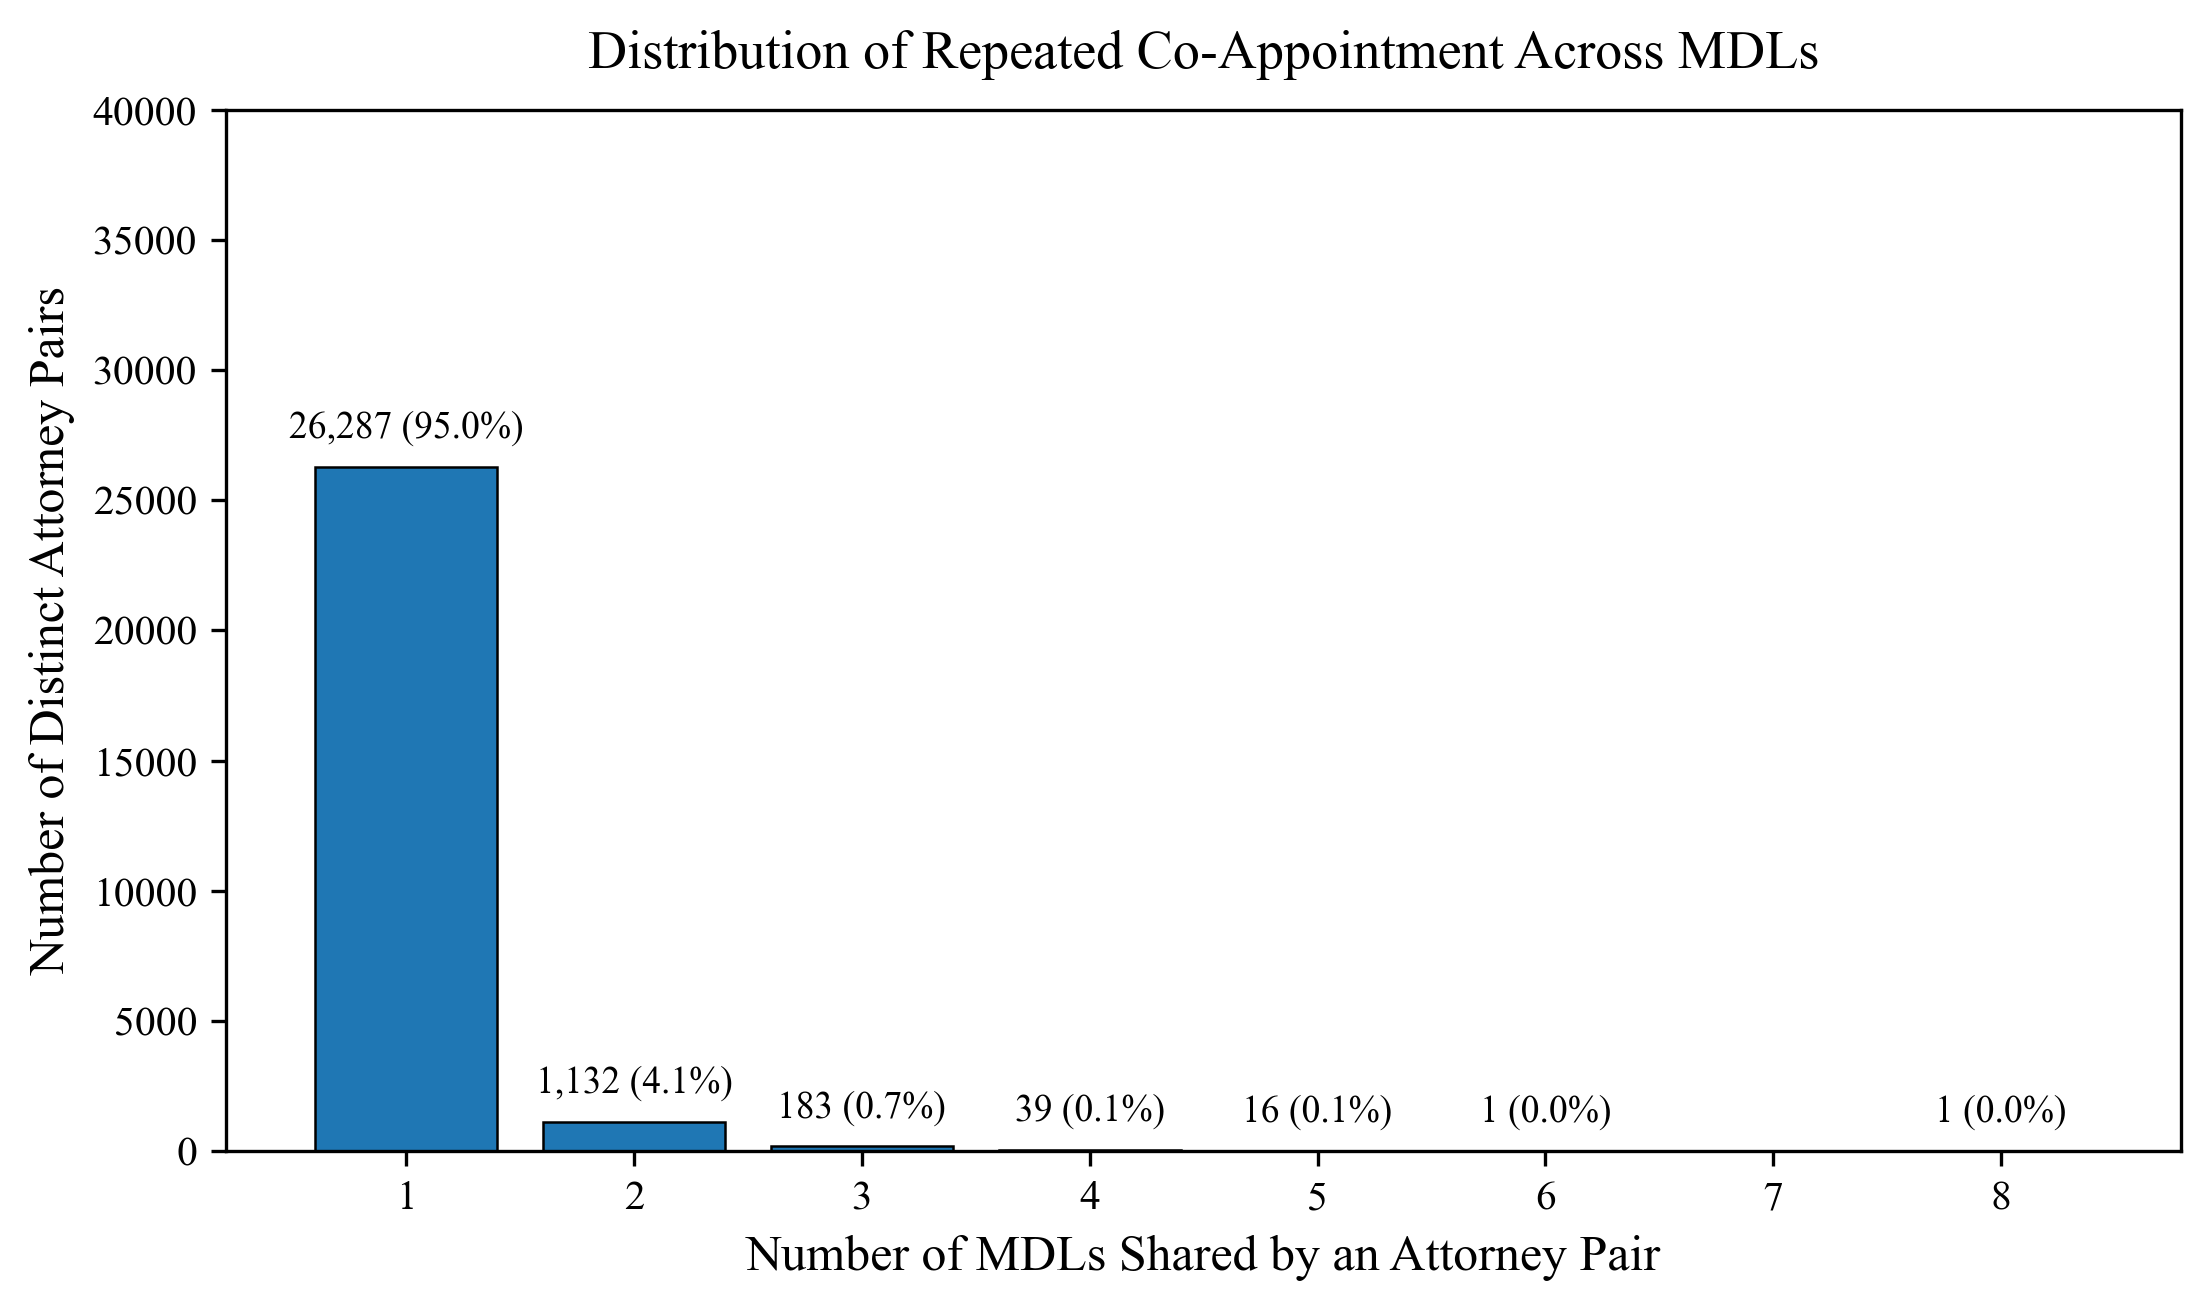

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

# ============================================================
# PLOT STYLE
# ============================================================

# Configure matplotlib for publication-quality output
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300,
    "axes.linewidth": 0.8,
    "axes.edgecolor": "black",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ============================================================
# INPUT
# ============================================================

df = attorney_x_mdl.copy()
df["attorney_id"] = df["attorney_id"].astype(str)
df["mdl_no_from_orders"] = df["mdl_no_from_orders"].astype(int)

# ============================================================
# 1. ALL DISTINCT ATTORNEY PAIRS
# ============================================================

# Generate all possible pairwise combinations of attorneys in dataset
attorneys = sorted(df["attorney_id"].unique())
all_pairs = list(combinations(attorneys, 2))

# ============================================================
# 2. MDL-LEVEL SLATES
# ============================================================

# For each MDL, extract the set of attorneys appointed to that case
mdl_slates = (
    df.groupby("mdl_no_from_orders")["attorney_id"]
      .apply(lambda x: set(x))
)

# ============================================================
# 3. COUNT SHARED MDLs (INCLUDING ZEROS INTERNALLY)
# ============================================================

# Initialize counter with all pairs at zero, then increment for each MDL where pair appears together
pair_counts = Counter({pair: 0 for pair in all_pairs})

for attorneys_in_mdl in mdl_slates:
    # For each MDL, count all pairs of attorneys appointed to that case
    for pair in combinations(sorted(attorneys_in_mdl), 2):
        pair_counts[pair] += 1

# Extract counts as series for analysis
shared_mdls = pd.Series(pair_counts.values())

# ============================================================
# 4. ZERO COUNT (REPORT IN TEXT)
# ============================================================

# Calculate total pairs with no shared MDLs (non-reporting metric)
n_zero_pairs = int((shared_mdls == 0).sum())
n_total_pairs = len(shared_mdls)

# ============================================================
# 5. DISTRIBUTION (REMOVE ZERO FROM PLOT)
# ============================================================

# Build distribution of co-appointment counts, excluding pairs that never co-appeared
dist = (
    shared_mdls[shared_mdls > 0]
    .value_counts()
    .sort_index()
)

# Fill gaps (e.g., if no pairs appear 3 times, insert 0 for that bin)
dist = dist.reindex(range(1, dist.index.max() + 1), fill_value=0)

n_nonzero_pairs = int(dist.sum())

# ============================================================
# 6. PLOT — BAR CHART WITH COUNTS + %
# ============================================================

fig, ax = plt.subplots(figsize=(7.5, 4.5))

bars = ax.bar(
    dist.index,
    dist.values,
    width=0.8,
    edgecolor="black",
    linewidth=0.6
)

ax.set_title("Distribution of Repeated Co-Appointment Across MDLs", pad=10)
ax.set_xlabel("Number of MDLs Shared by an Attorney Pair")
ax.set_ylabel("Number of Distinct Attorney Pairs")

ax.set_xticks(dist.index)

# Fix y-axis maximum for consistent layout across iterations
ax.set_ylim(0, 40000)

# Restore full frame (default removes top and right spines)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)

# ============================================================
# 7. ANNOTATE BARS (SLIGHTLY ABOVE)
# ============================================================

# Position labels 2% above the top of the y-axis
y_offset = 0.02 * 40000

for bar, k in zip(bars, dist.index):
    count = int(bar.get_height())
    if count > 0:
        # Calculate percentage of all co-appointed pairs
        pct = count / n_nonzero_pairs * 100
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            min(count + y_offset, 40000),
            f"{count:,} ({pct:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.tight_layout()
plt.show()

## 2.2 - Figure 7: Frequency of Co-Appointments of Top MDL Attorneys

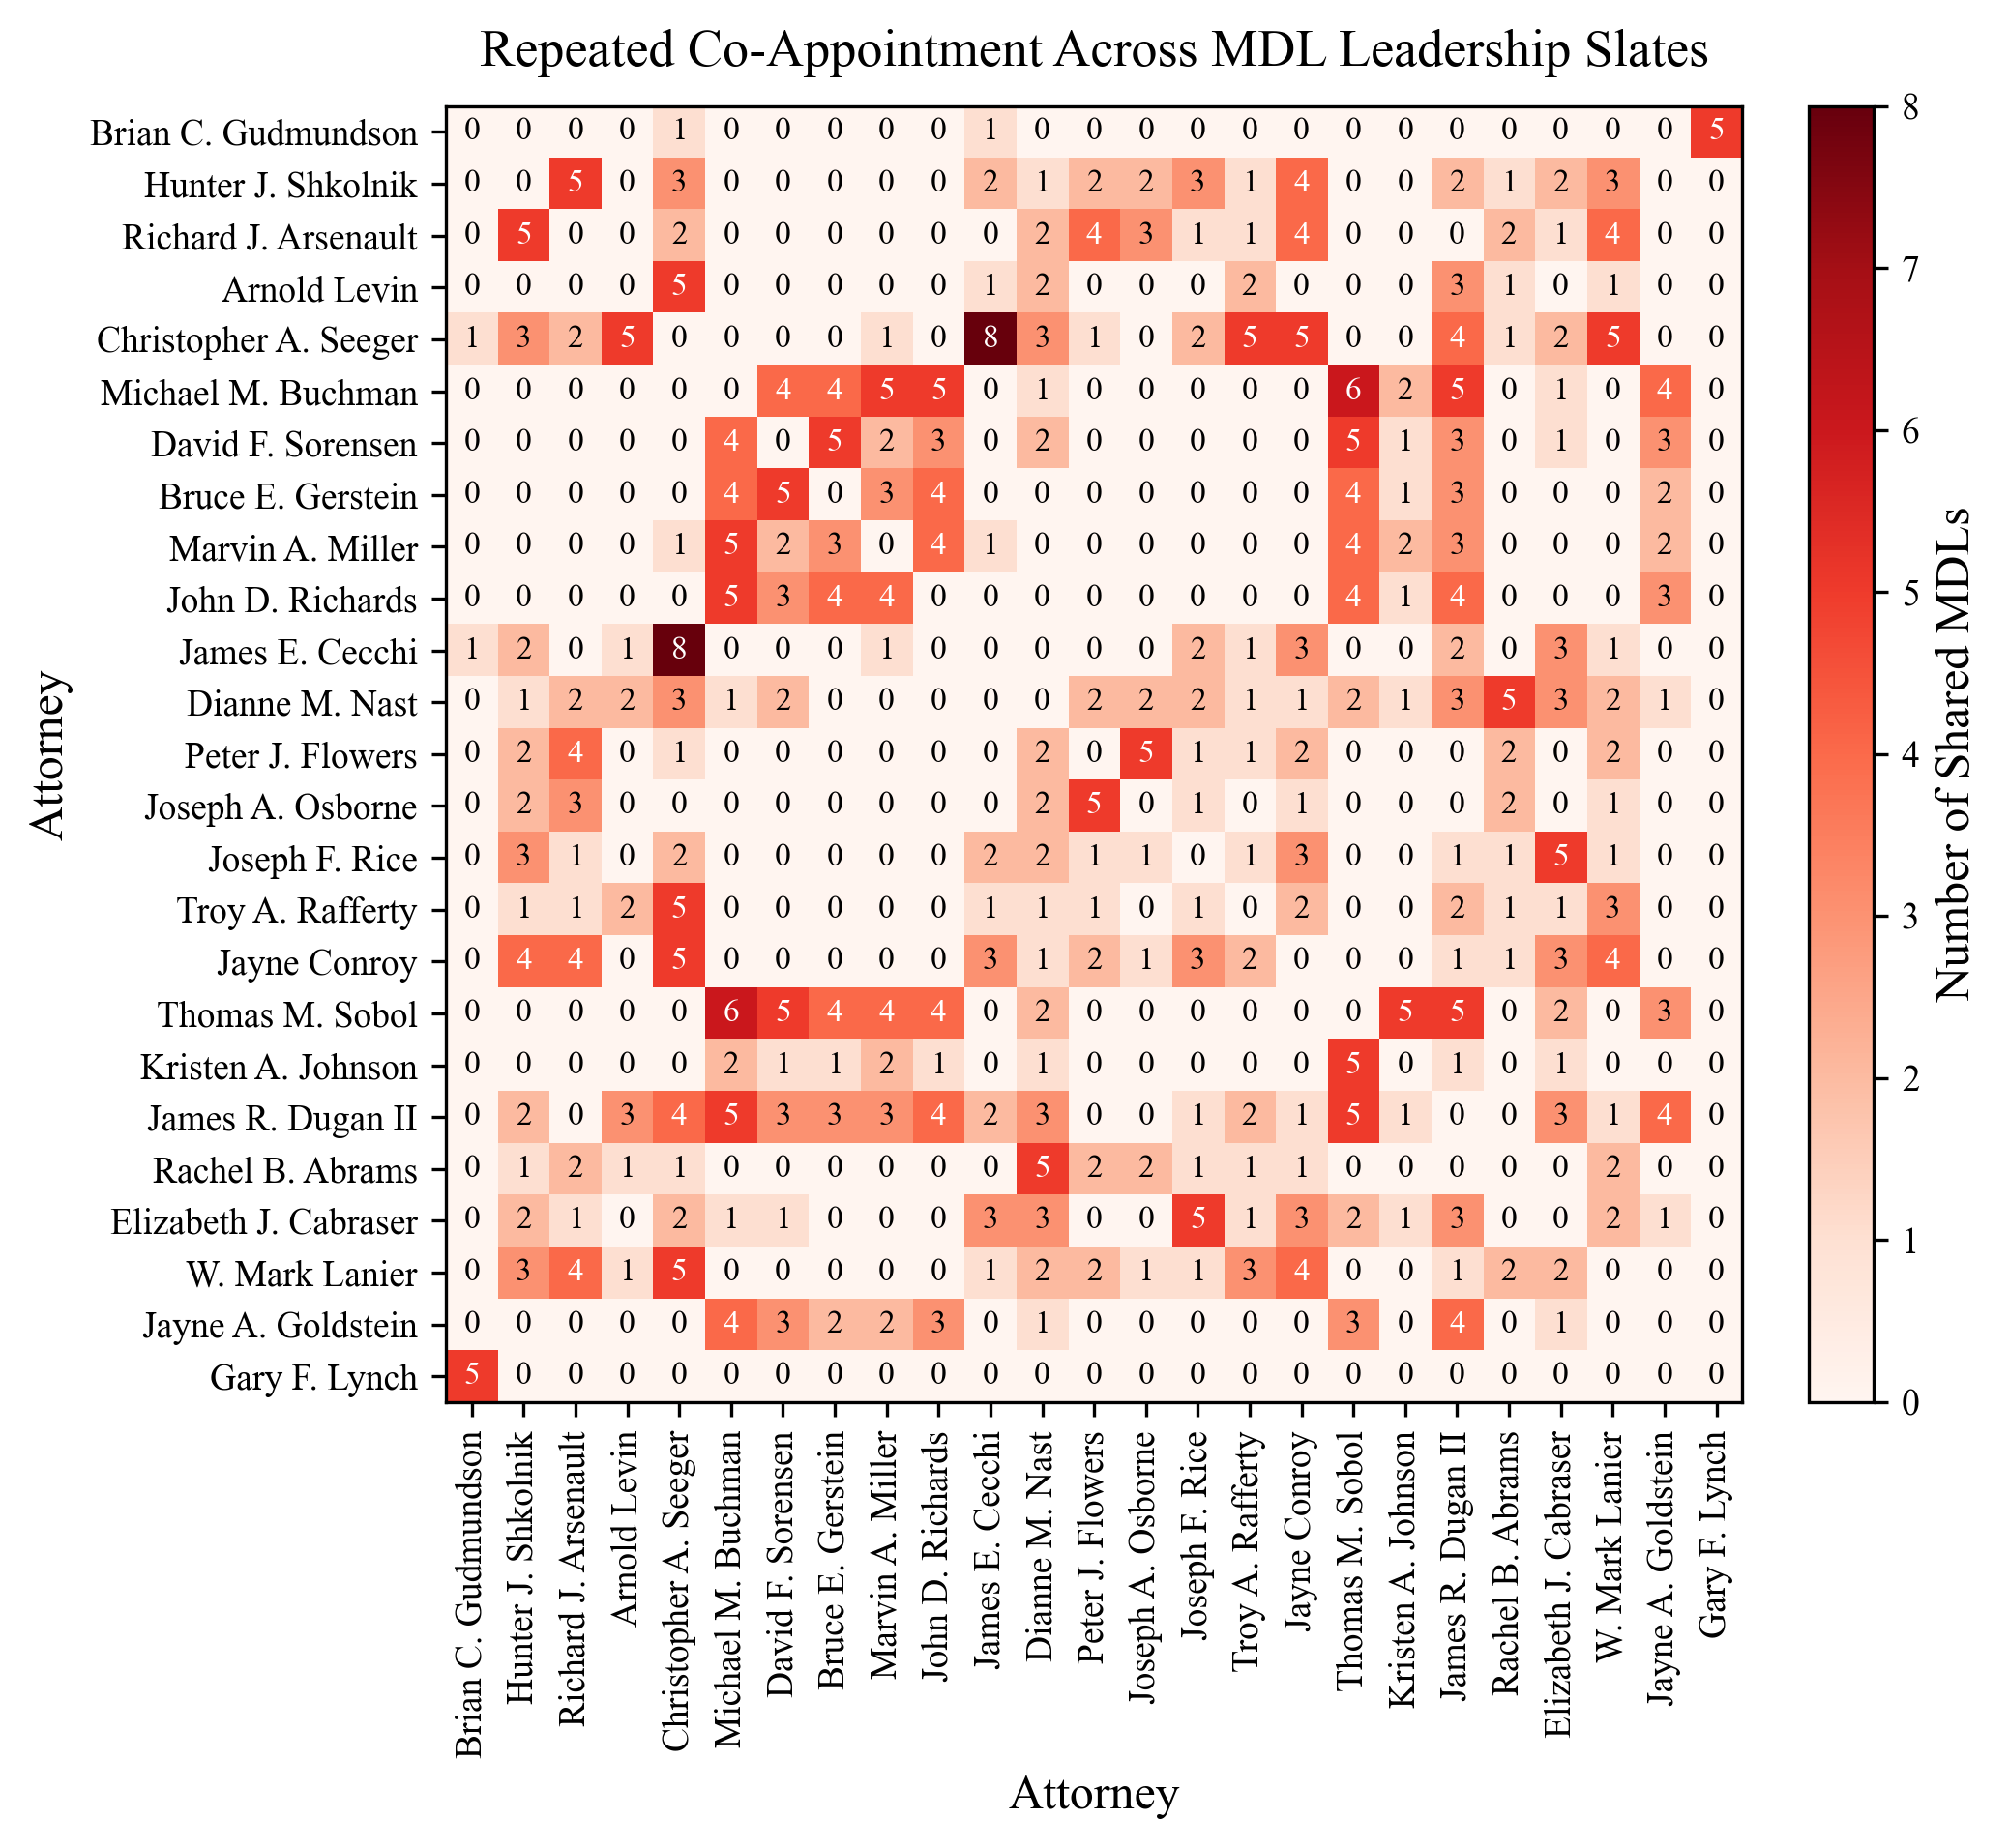

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

# ============================================================
# PLOT STYLE
# ============================================================

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.dpi": 300,
    "axes.linewidth": 0.8,
    "axes.edgecolor": "black",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ============================================================
# INPUT
# ============================================================

df = attorney_x_mdl.copy()

df["attorney_id"] = df["attorney_id"].astype(str)
df["mdl_no_from_orders"] = df["mdl_no_from_orders"].astype(int)
df["canonical_name"] = df["canonical_name"].astype(str)

# ============================================================
# 1. BUILD MDL-LEVEL SLATES
# ============================================================

# For each MDL, extract the sorted list of distinct attorneys appointed
mdl_slates = (
    df.groupby("mdl_no_from_orders")["attorney_id"]
      .apply(lambda x: sorted(set(x)))
)

# ============================================================
# 2. COUNT SHARED MDLs PER ATTORNEY PAIR
# ============================================================

# Count how many times each pair of attorneys appears together across MDLs
pair_counts = Counter()

for attorneys in mdl_slates:
    for a, b in combinations(attorneys, 2):
        pair_counts[(a, b)] += 1

# Convert to DataFrame for easier manipulation
pair_df = pd.DataFrame(
    [(a, b, c) for (a, b), c in pair_counts.items()],
    columns=["attorney_i", "attorney_j", "shared_mdls"]
)

# ============================================================
# 3. TOP 20 DISTINCT PAIRS
# ============================================================

# Identify the 20 pairs with most co-appointments
top20_pairs = (
    pair_df.sort_values("shared_mdls", ascending=False)
           .head(20)
)

# Extract unique attorneys from top 20 pairs
top_attorneys = sorted(
    set(top20_pairs["attorney_i"]).union(top20_pairs["attorney_j"])
)

# Create mapping from attorney ID to canonical name for labels
id_to_name = (
    df.drop_duplicates("attorney_id")
      .set_index("attorney_id")["canonical_name"]
)

# ============================================================
# 4. FULL MATRIX (ZEROS EVERYWHERE)
# ============================================================

# Pivot to create matrix of top attorneys only
matrix = (
    pair_df[
        pair_df["attorney_i"].isin(top_attorneys) &
        pair_df["attorney_j"].isin(top_attorneys)
    ]
    .pivot(index="attorney_i", columns="attorney_j", values="shared_mdls")
    .fillna(0)
)

# Transpose and add to make symmetric matrix (since pairs are stored one-way)
matrix = matrix.add(matrix.T, fill_value=0)

# Reindex to include all top attorneys (fills missing cells with 0)
matrix = matrix.reindex(index=top_attorneys, columns=top_attorneys, fill_value=0)
matrix = matrix.fillna(0)

# Replace attorney IDs with canonical names
matrix.index = [id_to_name.get(i, i) for i in matrix.index]
matrix.columns = [id_to_name.get(i, i) for i in matrix.columns]

# ============================================================
# 5. PLOT
# ============================================================

fig, ax = plt.subplots(figsize=(7.5, 6.5))

# Create heatmap with red color scale
im = ax.imshow(matrix.values, cmap="Reds", vmin=0)

# Force square aspect ratio for cells
ax.set_aspect("equal")

# Add colorbar with label
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Number of Shared MDLs")

# Set tick positions and labels
ax.set_xticks(range(len(matrix.columns)))
ax.set_yticks(range(len(matrix.index)))
ax.set_xticklabels(matrix.columns, rotation=90)
ax.set_yticklabels(matrix.index)

ax.set_title("Repeated Co-Appointment Across MDL Leadership Slates", pad=10)
ax.set_xlabel("Attorney")
ax.set_ylabel("Attorney")

# Add text annotations in each cell
max_val = matrix.values.max()

for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        val = int(matrix.values[i, j])
        # Use white text for dark cells, black for light cells
        ax.text(
            j, i, val,
            ha="center",
            va="center",
            fontsize=8,
            color="white" if val >= max_val * 0.5 else "black"
        )

plt.tight_layout()

# Restore full frame
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)

plt.show()


## 2.3 - Figure 8: Prevalence of One-Off Collaborations for Top MDL Attorneys

/var/folders/k7/b0_b7t6j6n72t68sh4s7t8400000gn/T/ipykernel_48369/348741838.py:125: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



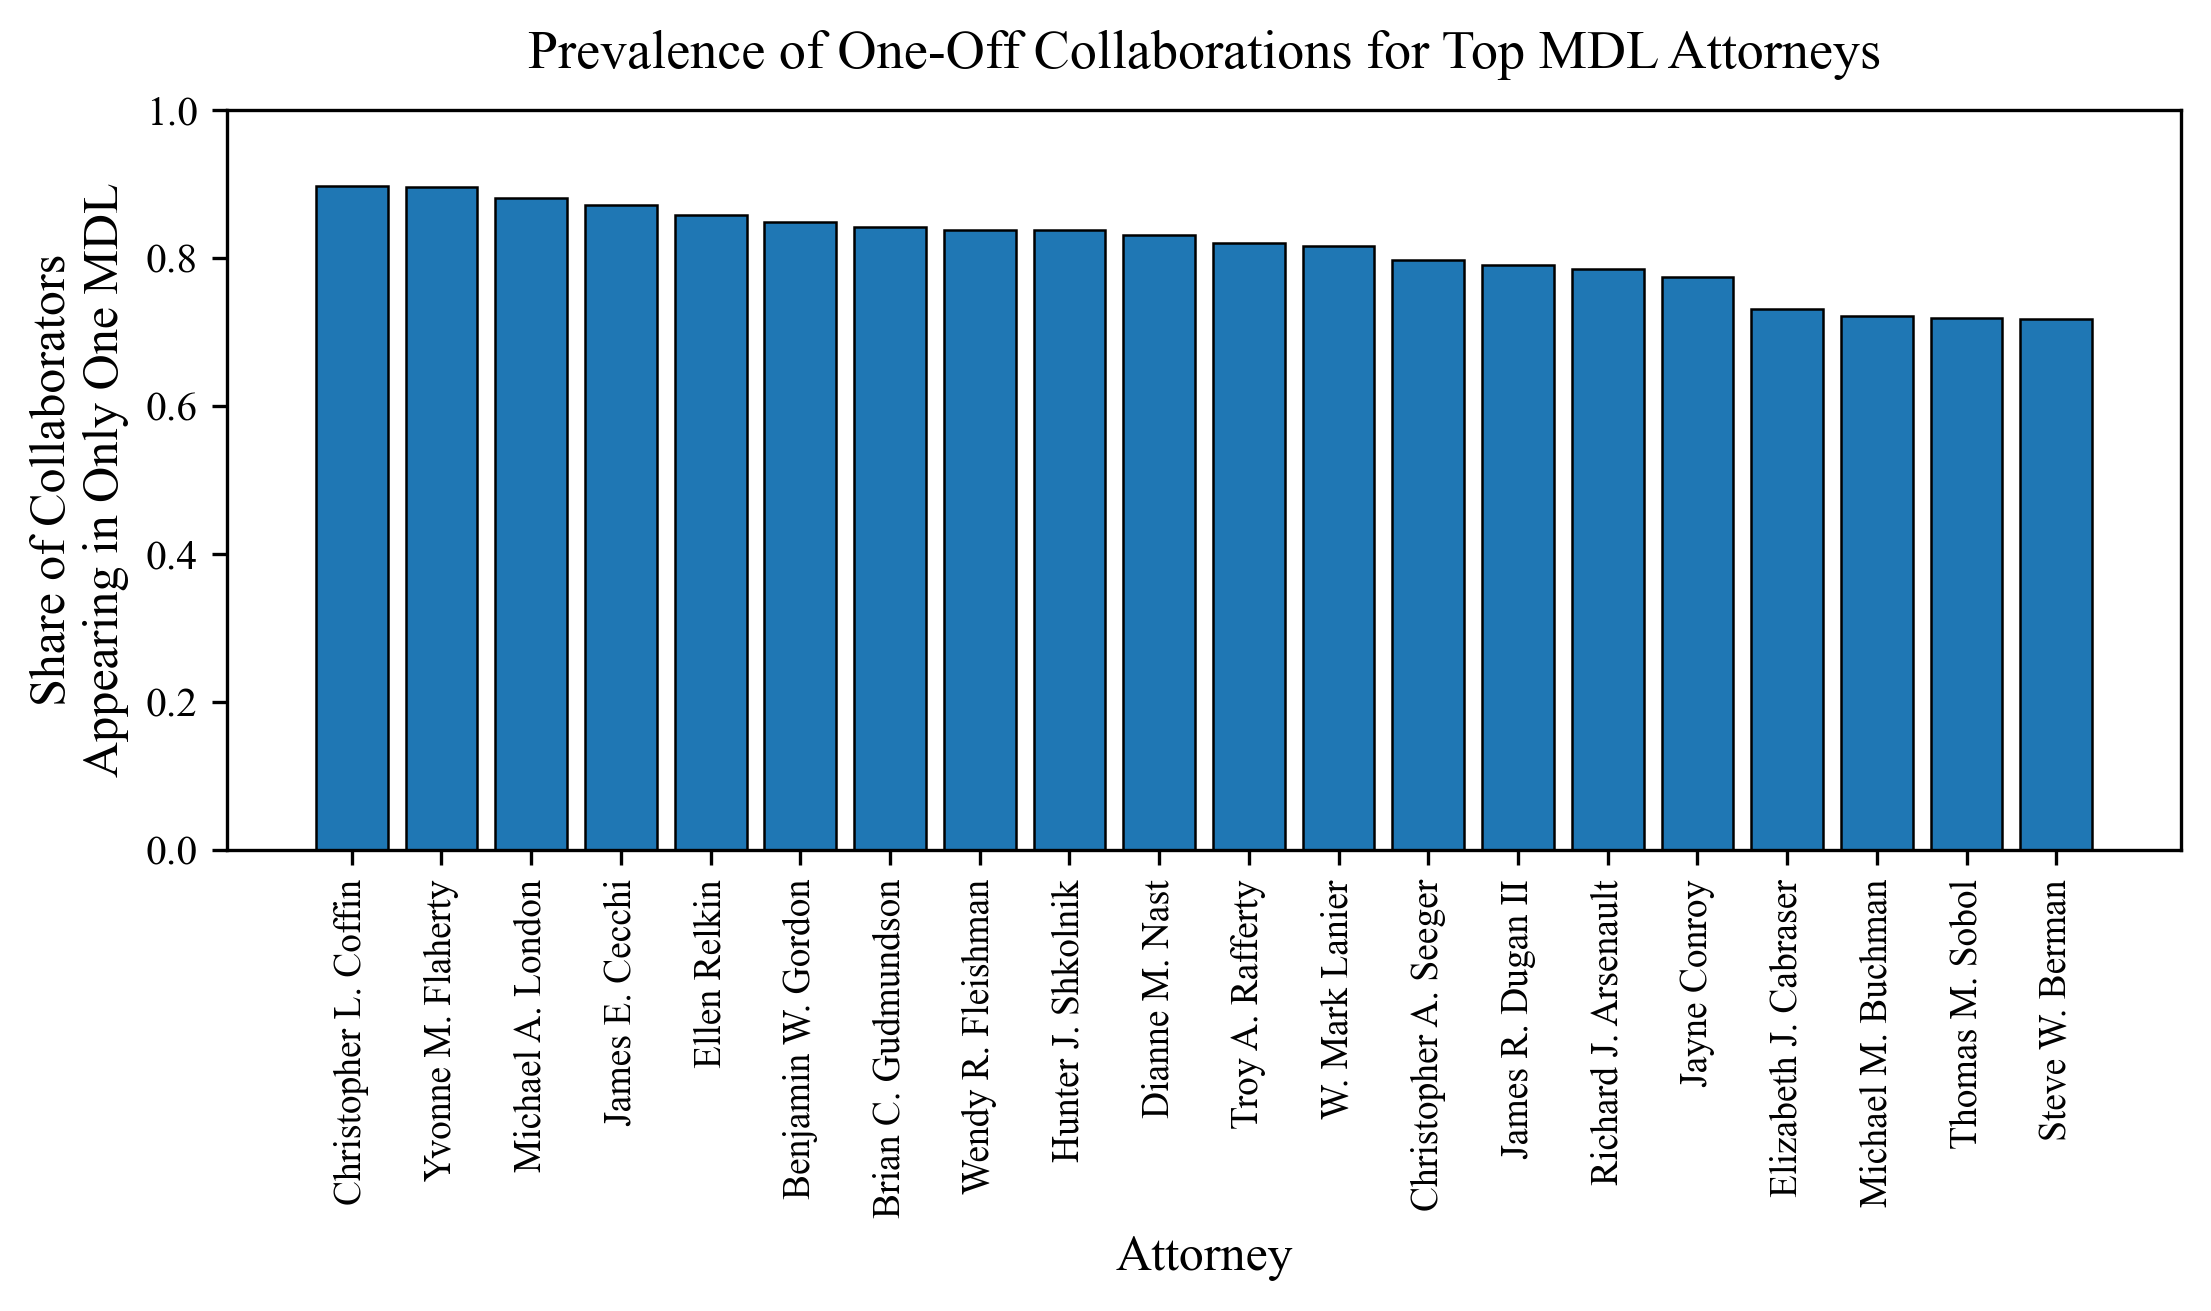

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# ============================================================
# PLOT STYLE
# ============================================================

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 9,
    "ytick.labelsize": 10,
    "figure.dpi": 300,
    "axes.linewidth": 0.8,
    "axes.edgecolor": "black",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ============================================================
# INPUT
# ============================================================

df = attorney_x_mdl.copy()
df["attorney_id"] = df["attorney_id"].astype(str)
df["mdl_no_from_orders"] = df["mdl_no_from_orders"].astype(int)
df["canonical_name"] = df["canonical_name"].astype(str)

# ============================================================
# TOP 20 ATTORNEYS BY NUMBER OF MDL APPEARANCES
# ============================================================

# Identify attorneys with most MDL appointments
top20_ids = (
    df.groupby("attorney_id")["mdl_no_from_orders"]
      .nunique()
      .sort_values(ascending=False)
      .head(20)
      .index
)

# Create mapping from attorney ID to name for labels
id_to_name = (
    df.drop_duplicates("attorney_id")
      .set_index("attorney_id")["canonical_name"]
)

# ============================================================
# BUILD MDL-LEVEL SLATES
# ============================================================

# For each MDL, extract the set of attorneys appointed to that case
mdl_slates = (
    df.groupby("mdl_no_from_orders")["attorney_id"]
      .apply(lambda x: set(x))
)

# ============================================================
# COMPUTE METRIC: Share of collaborators appearing only once
# ============================================================

# For each focal attorney, count how many times they work with each collaborator.
# A high share of "one-off" collaborators suggests diverse, non-recurring partnerships.
# A low share suggests a tight core of repeat collaborators.

rows = []

for focal in top20_ids:
    # Count how many MDLs each collaborator appears with focal attorney
    collaborator_counts = Counter()

    for attorneys in mdl_slates:
        if focal in attorneys:
            for other in attorneys:
                if other != focal:
                    collaborator_counts[other] += 1

    if len(collaborator_counts) == 0:
        continue

    n_collaborators = len(collaborator_counts)
    # Calculate proportion of collaborators who appear with focal attorney only once
    share_seen_once = (
        sum(1 for v in collaborator_counts.values() if v == 1)
        / n_collaborators
    )

    rows.append({
        "attorney": id_to_name.get(focal, focal),
        "share_seen_once": share_seen_once,
        "n_collaborators": n_collaborators,
    })

summary = (
    pd.DataFrame(rows)
    .sort_values("share_seen_once", ascending=False)
)

# ============================================================
# FIGURE — COLLABORATION DIVERSITY
# ============================================================

fig, ax = plt.subplots(figsize=(7.5, 4.5))

ax.bar(
    summary["attorney"],
    summary["share_seen_once"],
    edgecolor="black",
    linewidth=0.6
)

ax.set_title(
    "Prevalence of One-Off Collaborations for Top MDL Attorneys",
    pad=10
)
ax.set_ylabel(
    "Share of Collaborators\nAppearing in Only One MDL"
)
ax.set_xlabel("Attorney")

ax.set_ylim(0, 1.0)
ax.set_xticklabels(summary["attorney"], rotation=90)

# Restore full frame
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)

plt.tight_layout()
plt.show()

## 2.4 - Figure 9: Distribution of Co-Appointments for All MDL Firms

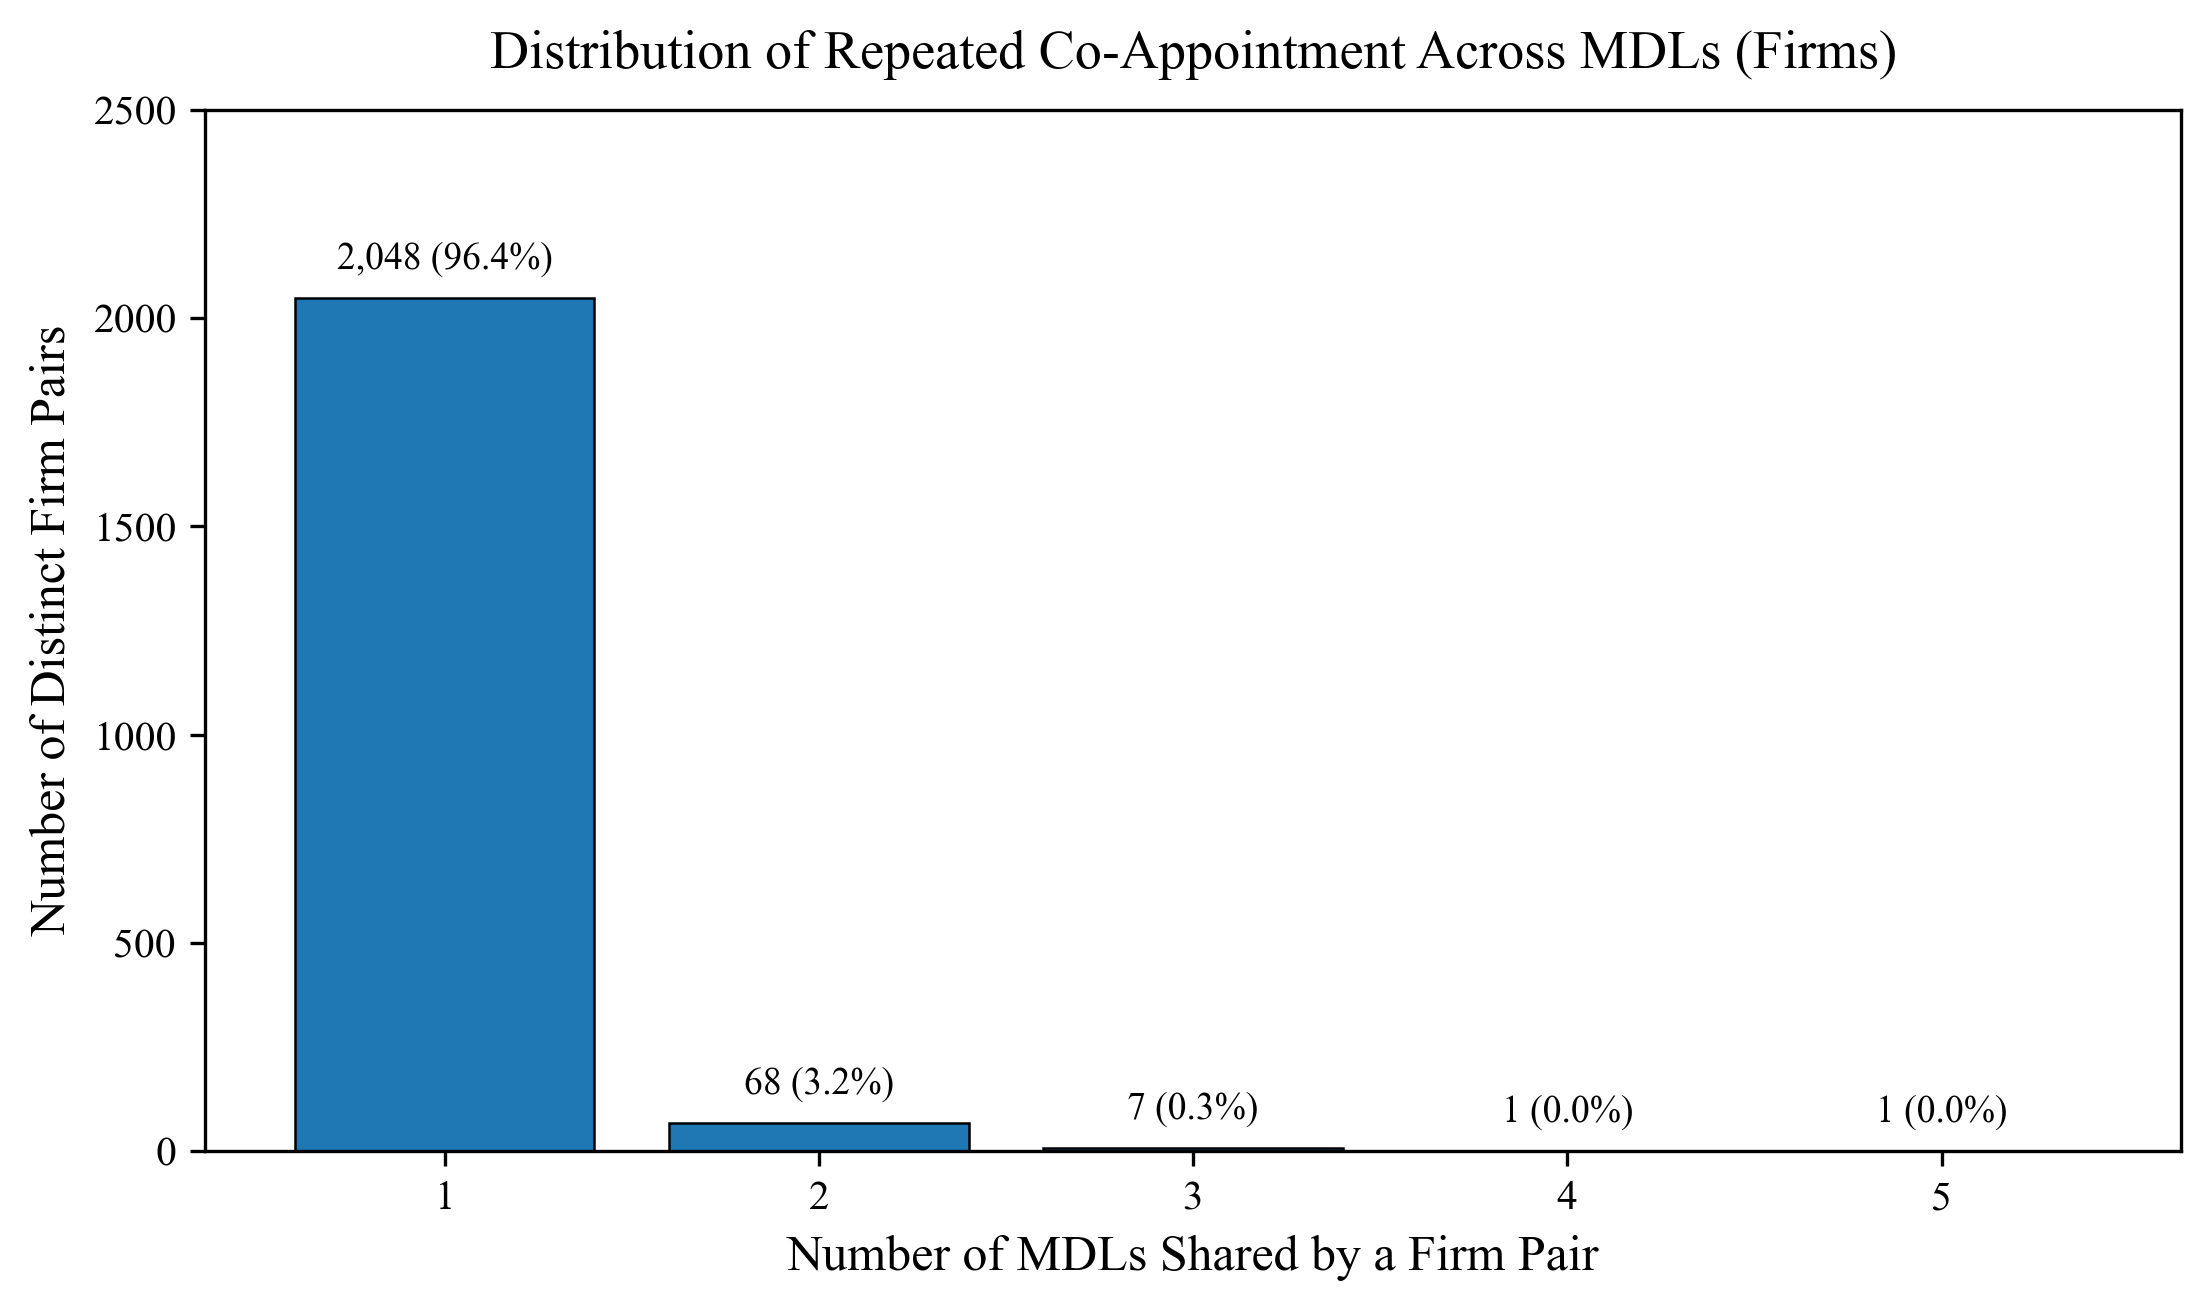

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

# ============================================================
# PLOT STYLE
# ============================================================

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300,
    "axes.linewidth": 0.8,
    "axes.edgecolor": "black",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ============================================================
# INPUT — FIRMS ONLY
# ============================================================

df = combined.copy()
df = df[df["unit"] == "FIRM"]

df["firm"] = df["firm"].astype(str)
df["mdl_no_from_orders"] = df["mdl_no_from_orders"].astype(int)

# ============================================================
# 1. ALL DISTINCT FIRM PAIRS
# ============================================================

# Generate all possible pairwise combinations of firms
firms = sorted(df["firm"].unique())
all_pairs = list(combinations(firms, 2))

# ============================================================
# 2. MDL-LEVEL FIRM SLATES
# ============================================================

# For each MDL, extract the set of distinct firms appointed
mdl_slates = (
    df.groupby("mdl_no_from_orders")["firm"]
      .apply(lambda x: set(x))
)

# ============================================================
# 3. COUNT SHARED MDLs
# ============================================================

# Initialize counter with all pairs at zero, then increment for each MDL
pair_counts = Counter({pair: 0 for pair in all_pairs})

for firms_in_mdl in mdl_slates:
    for pair in combinations(sorted(firms_in_mdl), 2):
        pair_counts[pair] += 1

shared_mdls = pd.Series(pair_counts.values())

# ============================================================
# 4. ZERO PAIRS (REPORT IN TEXT)
# ============================================================

n_zero_pairs = int((shared_mdls == 0).sum())
n_total_pairs = len(shared_mdls)

# ============================================================
# 5. DISTRIBUTION OF NON-ZERO CO-APPOINTMENTS
# ============================================================

# Count frequency of each co-appointment level (excluding zeros)
dist = (
    shared_mdls[shared_mdls > 0]
    .value_counts()
    .sort_index()
)

# Fill gaps in x-axis (e.g., if no pairs appear 3 times, insert 0)
dist = dist.reindex(range(1, dist.index.max() + 1), fill_value=0)

n_nonzero_pairs = int(dist.sum())

# ============================================================
# 6. PLOT — DISTRIBUTION OF CO-APPOINTMENTS
# ============================================================

fig, ax = plt.subplots(figsize=(7.5, 4.5))

bars = ax.bar(
    dist.index,
    dist.values,
    width=0.8,
    edgecolor="black",
    linewidth=0.6
)

ax.set_title("Distribution of Repeated Co-Appointment Across MDLs (Firms)", pad=10)
ax.set_xlabel("Number of MDLs Shared by a Firm Pair")
ax.set_ylabel("Number of Distinct Firm Pairs")

ax.set_xticks(dist.index)
ax.set_ylim(0, 2500)

# Restore full frame
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)

# Annotate bars with count and percentage
y_offset = 0.02 * 2500

for bar, k in zip(bars, dist.index):
    count = int(bar.get_height())
    if count > 0:
        pct = count / n_nonzero_pairs * 100
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            min(count + y_offset, 2500),
            f"{count:,} ({pct:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.tight_layout()
plt.show()

## 2.5 - Figure 10: Frequency of Co-Appointments of Top MDL Firms

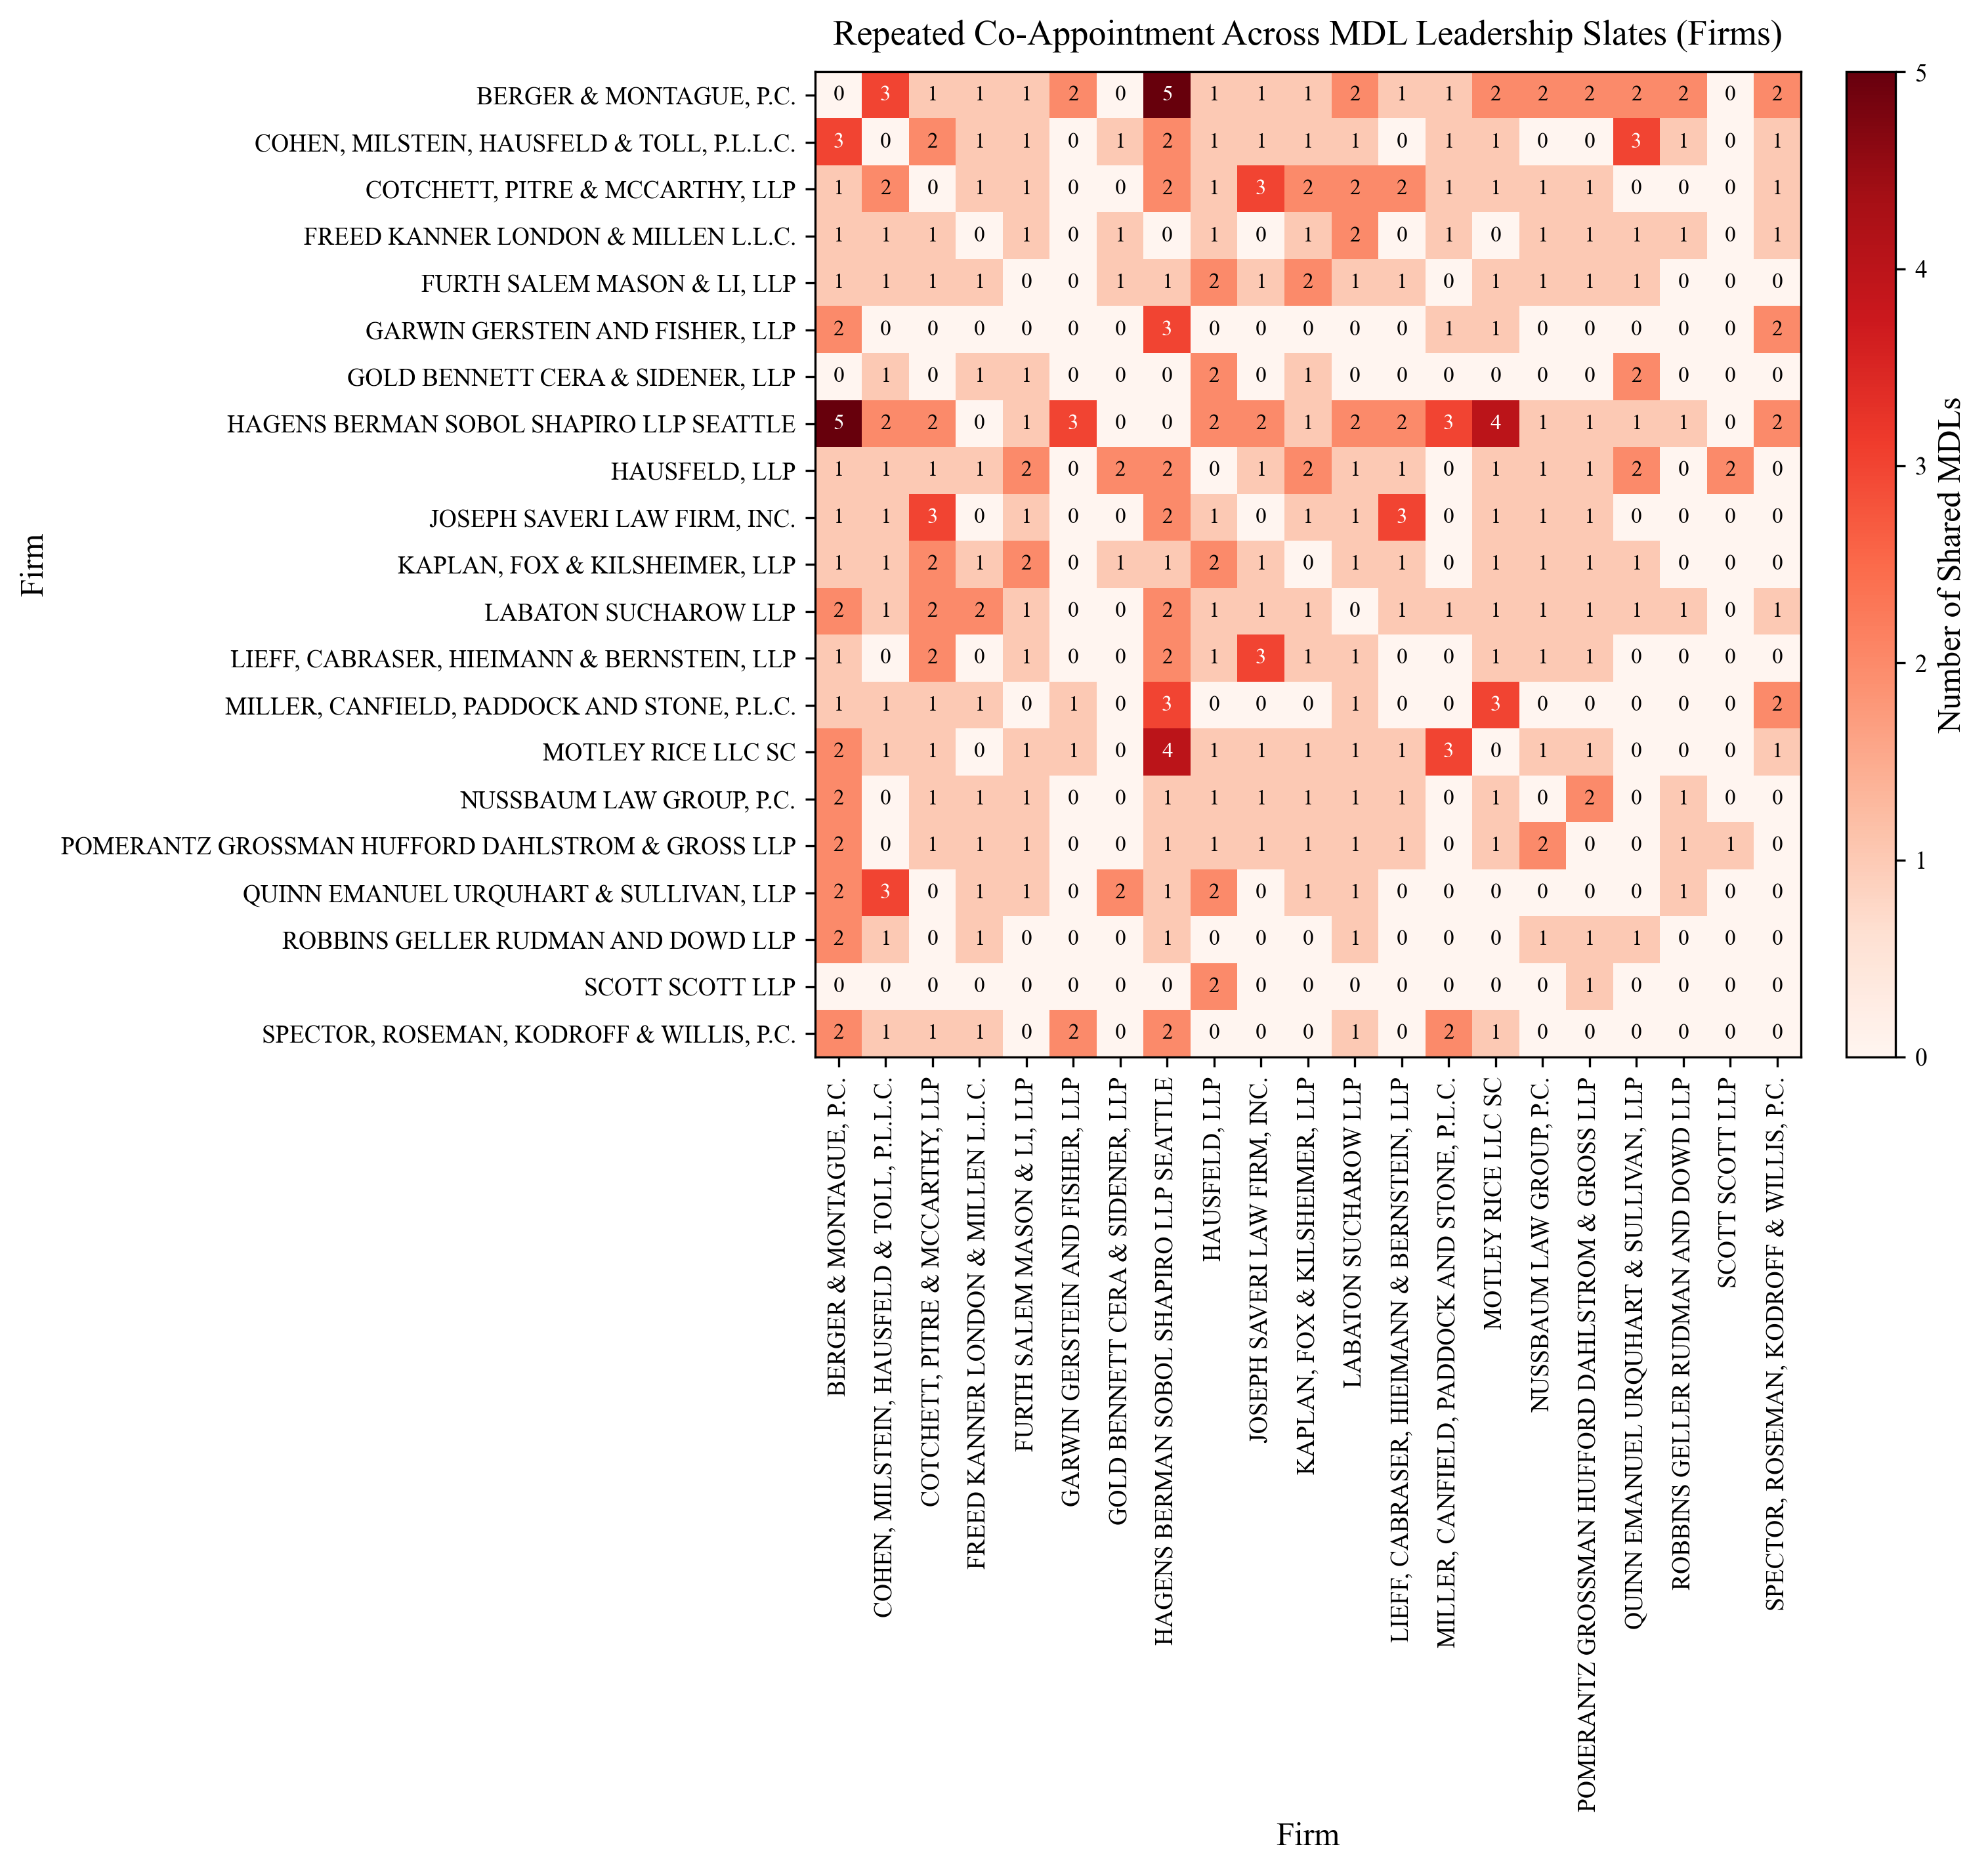

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

# ============================================================
# PLOT STYLE
# ============================================================

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.dpi": 300,
    "axes.linewidth": 0.8,
    "axes.edgecolor": "black",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ============================================================
# INPUT — FIRMS ONLY
# ============================================================

df = combined.copy()
df = df[df["unit"] == "FIRM"]
df["firm"] = df["firm"].astype(str)
df["mdl_no_from_orders"] = df["mdl_no_from_orders"].astype(int)

# ============================================================
# 1. BUILD MDL-LEVEL FIRM SLATES
# ============================================================

# For each MDL, extract sorted list of unique firms
mdl_slates = (
    df.groupby("mdl_no_from_orders")["firm"]
      .apply(lambda x: sorted(set(x)))
)

# ============================================================
# 2. COUNT SHARED MDLs PER FIRM PAIR
# ============================================================

# Count how many MDLs each pair of firms appears together in
pair_counts = Counter()
for firms in mdl_slates:
    for a, b in combinations(firms, 2):
        pair_counts[(a, b)] += 1

# Convert to DataFrame
pair_df = pd.DataFrame(
    [(a, b, c) for (a, b), c in pair_counts.items()],
    columns=["firm_i", "firm_j", "shared_mdls"]
)

# ============================================================
# 3. TOP 20 DISTINCT FIRM PAIRS
# ============================================================

# Identify 20 pairs with most co-appointments
top20_pairs = (
    pair_df.sort_values("shared_mdls", ascending=False)
           .head(20)
)

# Extract unique firms from top 20 pairs
top_firms = sorted(
    set(top20_pairs["firm_i"]).union(set(top20_pairs["firm_j"]))
)

# ============================================================
# 4. BUILD SYMMETRIC MATRIX
# ============================================================

# Pivot to matrix, keeping only top firms
matrix = (
    pair_df[
        pair_df["firm_i"].isin(top_firms) &
        pair_df["firm_j"].isin(top_firms)
    ]
    .pivot(index="firm_i", columns="firm_j", values="shared_mdls")
    .fillna(0)
)

# Make symmetric (pairs stored one-way; add transpose)
matrix = matrix.add(matrix.T, fill_value=0)

# Reindex to include all top firms (fills missing with 0)
matrix = matrix.reindex(index=top_firms, columns=top_firms, fill_value=0)

# Ensure clean numeric type before plotting
matrix = matrix.fillna(0).astype(int)

# ============================================================
# 5. PLOT — FIRM CO-APPOINTMENT HEATMAP
# ============================================================

fig, ax = plt.subplots(figsize=(7.5, 6.5))

im = ax.imshow(matrix.values, cmap="Reds", vmin=0)
ax.set_aspect("equal")

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Number of Shared MDLs")

ax.set_xticks(range(len(matrix.columns)))
ax.set_yticks(range(len(matrix.index)))
ax.set_xticklabels(matrix.columns, rotation=90)
ax.set_yticklabels(matrix.index)

ax.set_title(
    "Repeated Co-Appointment Across MDL Leadership Slates (Firms)",
    pad=10
)
ax.set_xlabel("Firm")
ax.set_ylabel("Firm")

# Restore full frame
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)

# Annotate cells with counts
max_val = matrix.values.max()
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        val = int(matrix.values[i, j])
        ax.text(
            j, i, val,
            ha="center",
            va="center",
            fontsize=8,
            color="white" if val >= max_val * 0.5 and val > 0 else "black"
        )

plt.show()

## 2.6 - Figure 11: Frequency of Actual Co-Appointments vs. Those Expected Under Chance Alone

Observed total additional co-appointments (plaintiff side): 1691
P-value (one-sided): 0.0000


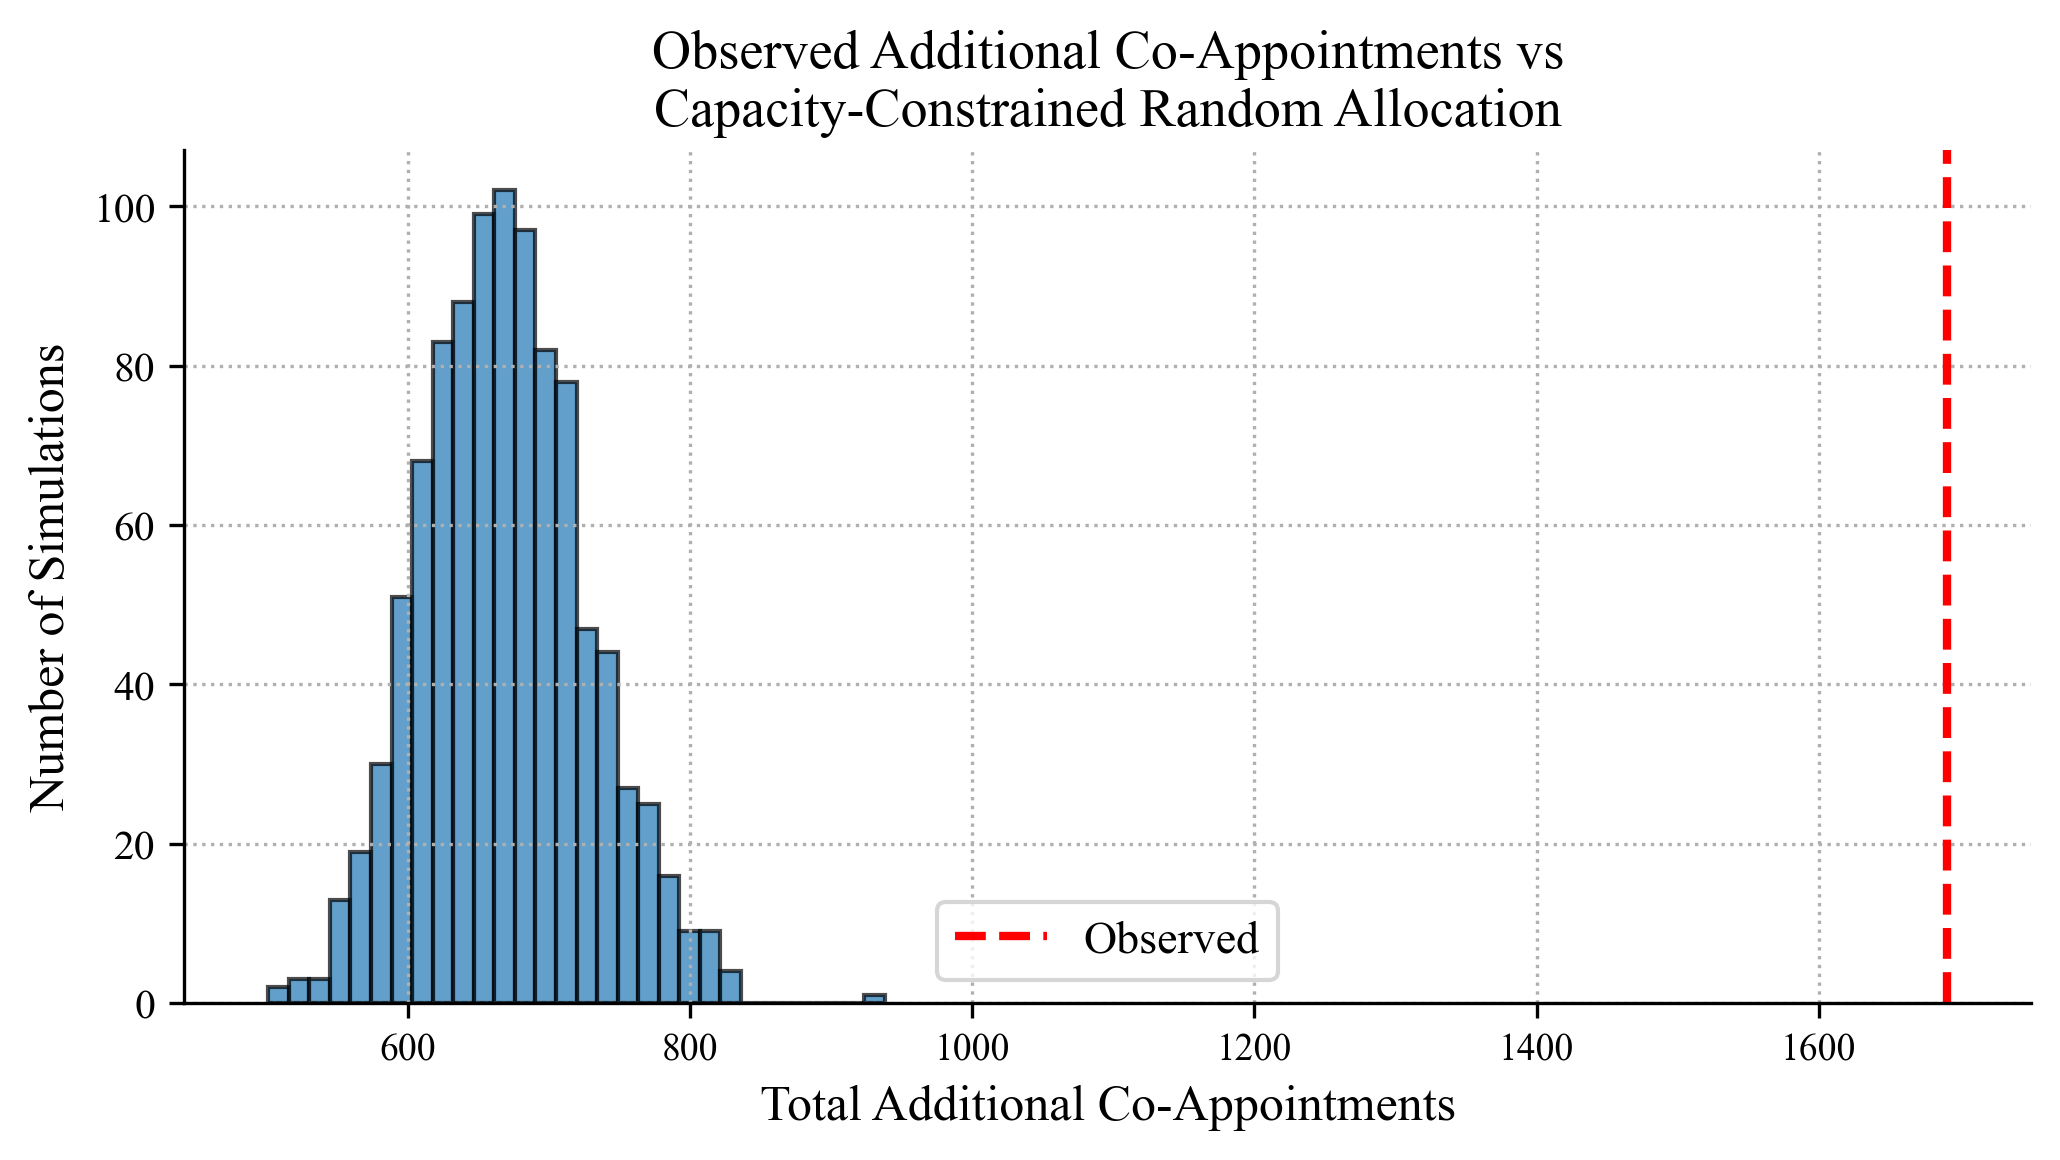

In [96]:
import pandas as pd
import numpy as np
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt

# ============================================================
# PLOT STYLE
# ============================================================

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 9,
    "ytick.labelsize": 10,
    "figure.dpi": 300,
    "axes.linewidth": 0.8,
    "axes.edgecolor": "black",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ============================================================
# 0. INPUT DATA
# ============================================================

# Load plaintiff-side attorney appointments (one row per attorney × MDL pair)
df = attorney_x_mdl.copy()
df = df[df["plaintiff_defendant"] == "plaintiff"]

df["attorney_id"] = df["attorney_id"].astype(str)
df["mdl_no_from_orders"] = df["mdl_no_from_orders"].astype(int)

edges = df[["attorney_id", "mdl_no_from_orders"]].drop_duplicates()

# ============================================================
# 1. OBSERVED ALLOCATION
# ============================================================

# Map each MDL to its slate of attorneys
observed_mdl_to_attorneys = (
    edges.groupby("mdl_no_from_orders")["attorney_id"]
    .apply(list)
)

# ============================================================
# 2. STATISTICAL TEST: ADDITIONAL CO-APPOINTMENTS
# ============================================================

# CONCEPTUAL FRAMEWORK:
# ─────────────────────────────────────────────────────────
# When two attorneys are appointed to the same MDL, we count that as one
# "co-appointment." However, when the same pair is appointed to multiple MDLs,
# only the first pairing is mechanically required by the system; subsequent
# pairings are "additional" and might indicate preferential selection.
#
# Example: if Attorneys A and B appear together in 5 MDLs, that's 1 required
# co-appointment + 4 additional (discretionary) co-appointments.
#
# This test asks: is the observed number of additional co-appointments
# significantly higher than expected under random allocation (conditional on
# observed attorney capacity and MDL sizes)?

def count_additional_coappointments(mdl_to_attorneys):
    """
    Count discretionary (beyond-first) co-appointments.
    
    For each pair of attorneys, subtract 1 from their co-appointment count
    (the "first" mechanically-required pairing), then sum the remainder.
    """
    pair_counts = Counter()

    for attorneys in mdl_to_attorneys:
        # Unique attorneys in this MDL
        unique_attorneys = sorted(set(attorneys))
        # Count all pairs in this MDL
        for a, b in combinations(unique_attorneys, 2):
            pair_counts[(a, b)] += 1

    # Subtract 1 from each pair (the required first co-appointment),
    # but don't go below 0
    return sum(max(c - 1, 0) for c in pair_counts.values())

# ============================================================
# 3. OBSERVED TEST STATISTIC
# ============================================================

observed_additional = count_additional_coappointments(
    observed_mdl_to_attorneys.values
)

print(f"Observed total additional co-appointments (plaintiff side): {observed_additional}")

# ============================================================
# 4. NULL MODEL: CAPACITY-CONSTRAINED RANDOM ALLOCATION
# ============================================================

# NULL HYPOTHESIS:
# Attorneys are allocated to MDLs uniformly at random, subject only to:
# (a) each attorney must appear in exactly their observed number of MDLs
# (b) each MDL must have exactly its observed slate size
#
# This preserves the marginal constraints (how many MDLs each attorney
# appears in, how many seats each MDL has) while randomizing the specific
# pairings. If observed co-appointments exceed what this random model
# predicts, it suggests non-random (preferential) pairing.

# Count capacity constraints: how many MDLs each attorney appears in
attorney_capacity = (
    edges.groupby("attorney_id")["mdl_no_from_orders"]
    .nunique()
    .to_dict()
)

# Count MDL sizes: number of attorneys in each MDL (plaintiff side)
mdl_sizes = (
    edges.groupby("mdl_no_from_orders")["attorney_id"]
    .nunique()
    .to_dict()
)

# Sanity check: total attorney appearances equals total slots to fill
assert sum(attorney_capacity.values()) == sum(mdl_sizes.values())

mdls = list(mdl_sizes.keys())

# ============================================================
# 5. RANDOM ALLOCATION FUNCTION
# ============================================================

def random_allocation(seed=None):
    """
    Randomly allocate attorneys to MDLs while respecting capacity constraints.
    
    Algorithm:
    1. Create "stubs" - a list of attorney IDs where each attorney appears
       exactly as many times as their observed capacity
    2. Randomly shuffle the stubs
    3. Distribute shuffled stubs to MDLs, assigning each MDL its required size
    
    This ensures all marginal constraints are satisfied while randomizing
    the actual attorney-MDL pairings.
    """
    rng = np.random.default_rng(seed)

    # Build stub list: each attorney appears as many times as their capacity
    stubs = []
    for attorney, cap in attorney_capacity.items():
        stubs.extend([attorney] * cap)

    # Randomly shuffle stubs
    rng.shuffle(stubs)

    # Distribute stubs to MDLs in order
    allocation = {}
    idx = 0

    for mdl in mdls:
        size = mdl_sizes[mdl]
        allocation[mdl] = stubs[idx:idx + size]
        idx += size

    return allocation

# ============================================================
# 6. NULL DISTRIBUTION (MONTE CARLO SIMULATION)
# ============================================================

# Run 1,000 random allocations and compute test statistic for each
n_sim = 1000
null_distribution = []

for s in range(n_sim):
    sim_allocation = random_allocation(seed=s)
    stat = count_additional_coappointments(
        sim_allocation.values()
    )
    null_distribution.append(stat)

null_distribution = np.array(null_distribution)

# ============================================================
# 7. P-VALUE (ONE-SIDED TEST)
# ============================================================

# Count how many simulations had additional co-appointments >= observed
# This is a one-sided test: Do observed co-appointments exceed chance?

p_value = (null_distribution >= observed_additional).mean()

print(f"P-value (one-sided): {p_value:.4f}")

# ============================================================
# 8. VISUALIZATION: NULL DISTRIBUTION
# ============================================================

plt.figure(figsize=(7, 4))

# Histogram of simulated test statistics
plt.hist(
    null_distribution,
    bins=30,
    edgecolor="black",
    alpha=0.7
)

# Mark observed value
plt.axvline(
    observed_additional,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Observed"
)

plt.xlabel("Total Additional Co-Appointments")
plt.ylabel("Number of Simulations")
plt.title(
    "Observed Additional Co-Appointments vs\n"
    "Capacity-Constrained Random Allocation"
)

plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

## 2.7 - Figure 12: New MDL Entrants Over Time

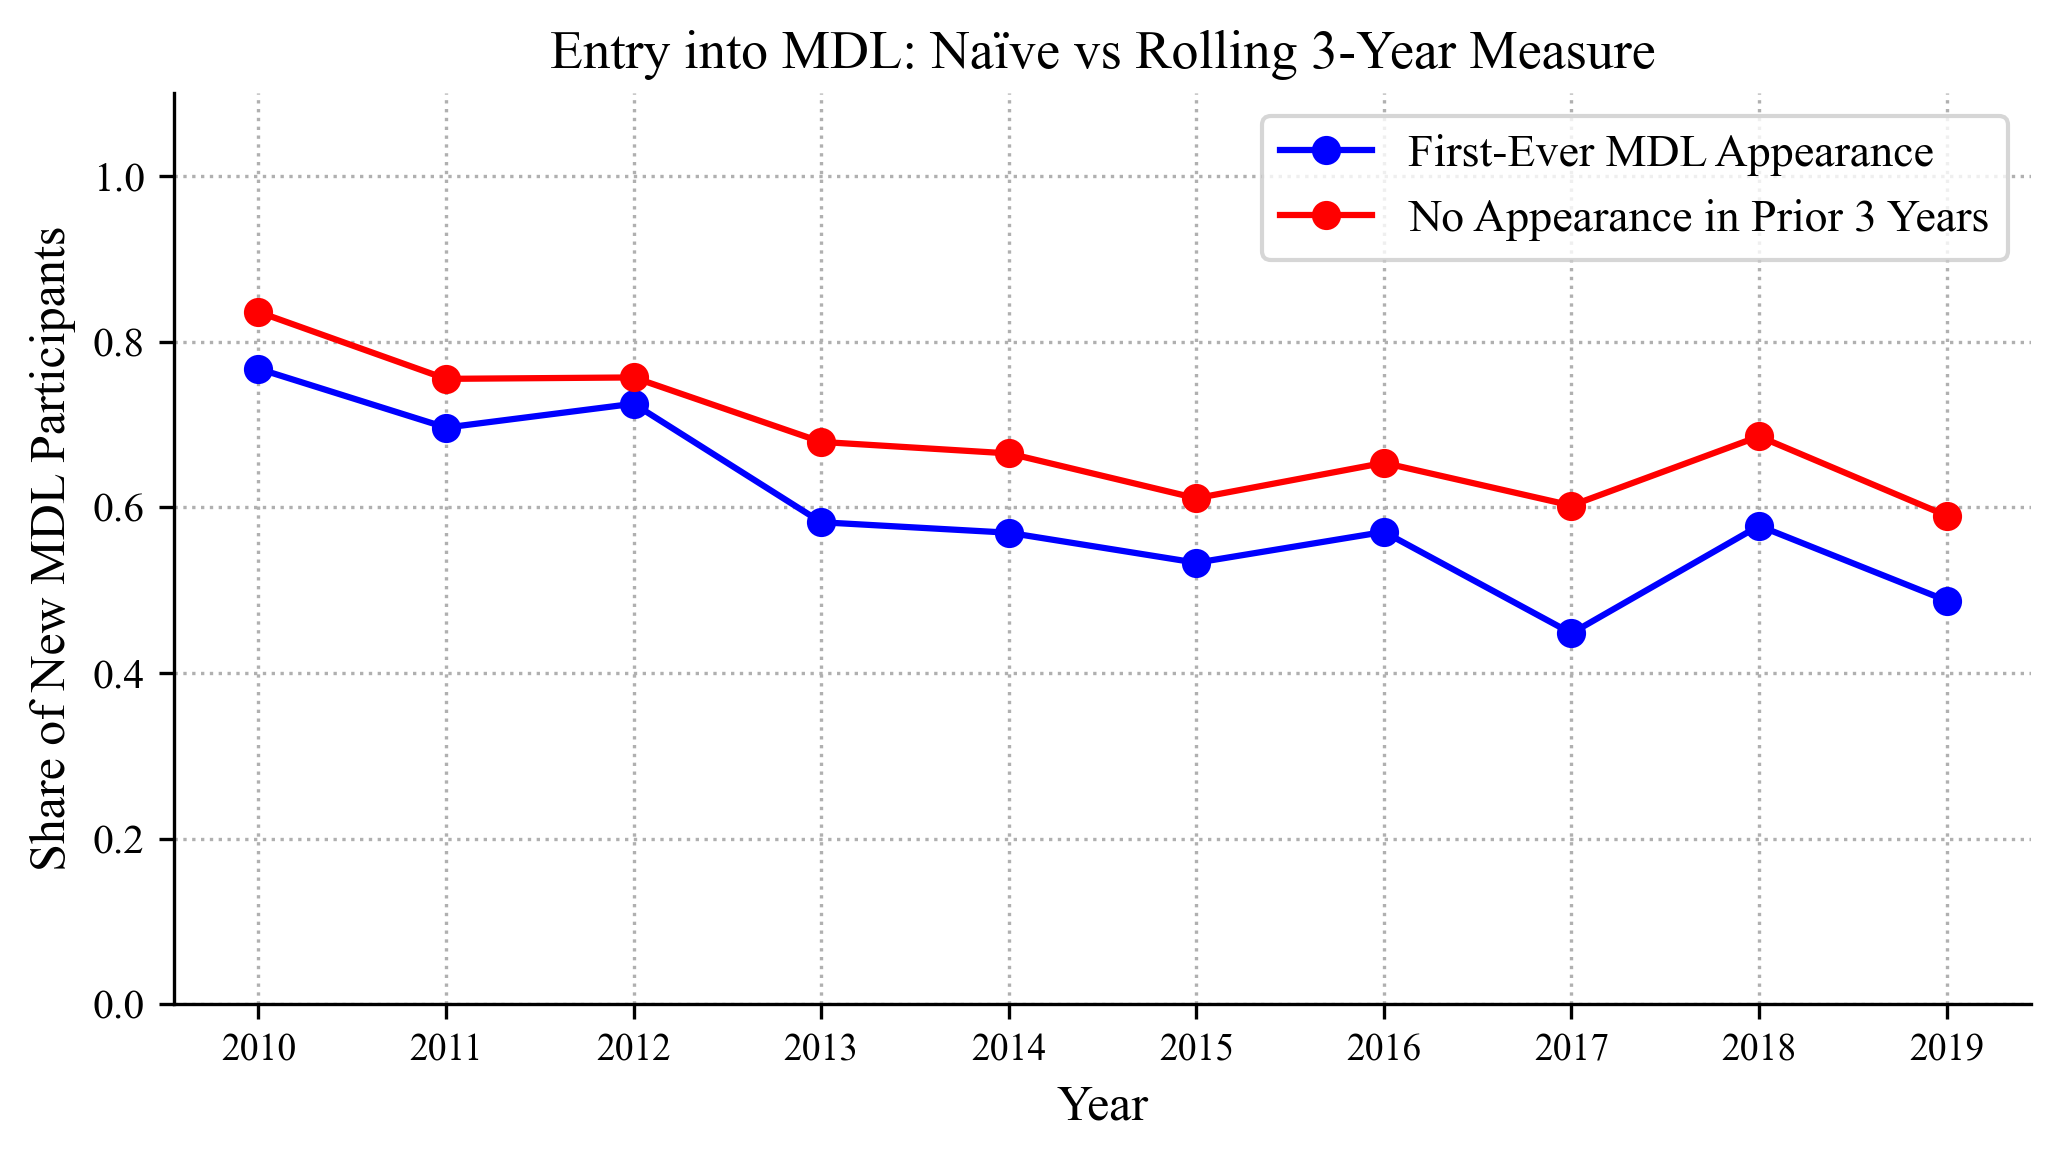

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 1. MERGE ATTORNEY APPOINTMENTS WITH MDL DATES
# ============================================================
mdls = clean_column_names(pd.read_csv(data_dir / "mdls.csv"))

# Join attorney-MDL pairs with MDL filing and transfer dates
df = attorney_x_mdl.merge(
    mdls[["mdl_no", "date_filed", "date_transferred"]],
    left_on="mdl_no_from_orders",
    right_on="mdl_no",
    how="left"
)

# ============================================================
# 2. STANDARDIZE DATES AND EXTRACT YEAR
# ============================================================

# Convert to datetime; use transfer date (when MDL was consolidated),
# fall back to filing date if transfer not available
df["date_transferred"] = pd.to_datetime(df["date_transferred"], errors="coerce")
df["date_filed"] = pd.to_datetime(df["date_filed"], errors="coerce")

df["mdl_date"] = df["date_transferred"].fillna(df["date_filed"])
df["year"] = df["mdl_date"].dt.year.astype("Int64")

# Drop records without year information
df = df.dropna(subset=["year"])

# ============================================================
# 3. NAÏVE MEASURE: FIRST-EVER MDL APPEARANCE
# ============================================================

# For each attorney, identify the first year they appear in any MDL
first_year = (
    df.groupby("attorney_id")["year"]
      .min()
      .rename("first_year")
      .reset_index()
)

df_naive = df.merge(first_year, on="attorney_id", how="left")
df_naive["is_first_time"] = (df_naive["year"] == df_naive["first_year"]).astype(int)

# Count total and first-time attorneys per year
yearly_attorneys = (
    df_naive.groupby("year")["attorney_id"]
    .nunique()
)

yearly_first_time = (
    df_naive[df_naive["is_first_time"] == 1]
    .groupby("year")["attorney_id"]
    .nunique()
)

naive = pd.concat(
    [yearly_attorneys, yearly_first_time],
    axis=1
).fillna(0)

naive.columns = ["n_attorneys", "n_first_time"]
naive["share_first_time"] = naive["n_first_time"] / naive["n_attorneys"]

# ============================================================
# 4. ROLLING 3-YEAR MEASURE: NEW ENTRANTS
# ============================================================

# Alternative measure: attorneys appearing in year Y but not in Y-1, Y-2, Y-3.
# This captures return of experienced attorneys and distinguishes them from
# true newcomers. Requires data from 2007+; first observation in 2010.

df_rolling = df[df["year"] >= 2007][["attorney_id", "year"]].drop_duplicates()

WINDOW = 3
records = []

years = sorted(df_rolling["year"].unique())

for y in years:
    # Skip first WINDOW years (insufficient prior history)
    if y < 2007 + WINDOW:
        continue

    # Attorneys active in year y
    active_now = set(df_rolling[df_rolling["year"] == y]["attorney_id"])
    
    # Attorneys active in any of the prior 3 years
    active_past = set(
        df_rolling[df_rolling["year"].isin([y-1, y-2, y-3])]["attorney_id"]
    )

    if len(active_now) == 0:
        continue

    # New entrants = active now but not in prior 3 years
    records.append({
        "year": y,
        "share_new_3yr": len(active_now - active_past) / len(active_now)
    })

rolling = pd.DataFrame(records).set_index("year")

# ============================================================
# 5. ALIGN YEARS AND FILL GAPS
# ============================================================

# Restrict to years where both measures are available
start_year = max(naive.index.min(), rolling.index.min())
end_year = min(naive.index.max(), rolling.index.max())

years = range(int(start_year), int(end_year) + 1)

# Reindex to ensure consistent year coverage
naive = naive.reindex(years, fill_value=0)
rolling = rolling.reindex(years, fill_value=0)

# ============================================================
# 6. PLOT — NAÏVE VS ROLLING MEASURE
# ============================================================

plt.figure(figsize=(7, 4))

plt.plot(
    naive.index,
    naive["share_first_time"],
    marker="o",
    color="blue",
    label="First-Ever MDL Appearance"
)

plt.plot(
    rolling.index,
    rolling["share_new_3yr"],
    marker="o",
    color="red",
    label="No Appearance in Prior 3 Years"
)

plt.xlabel("Year")
plt.ylabel("Share of New MDL Participants")
plt.title("Entry into MDL: Naïve vs Rolling 3-Year Measure")

plt.xticks(years)
plt.ylim(0, 1.1)
plt.grid(True, linestyle=":")
plt.legend(frameon=True)

plt.tight_layout()
plt.show()

## 2.8 - Figure 13: Variation in Judges’ Appointments of First-Time Leaders

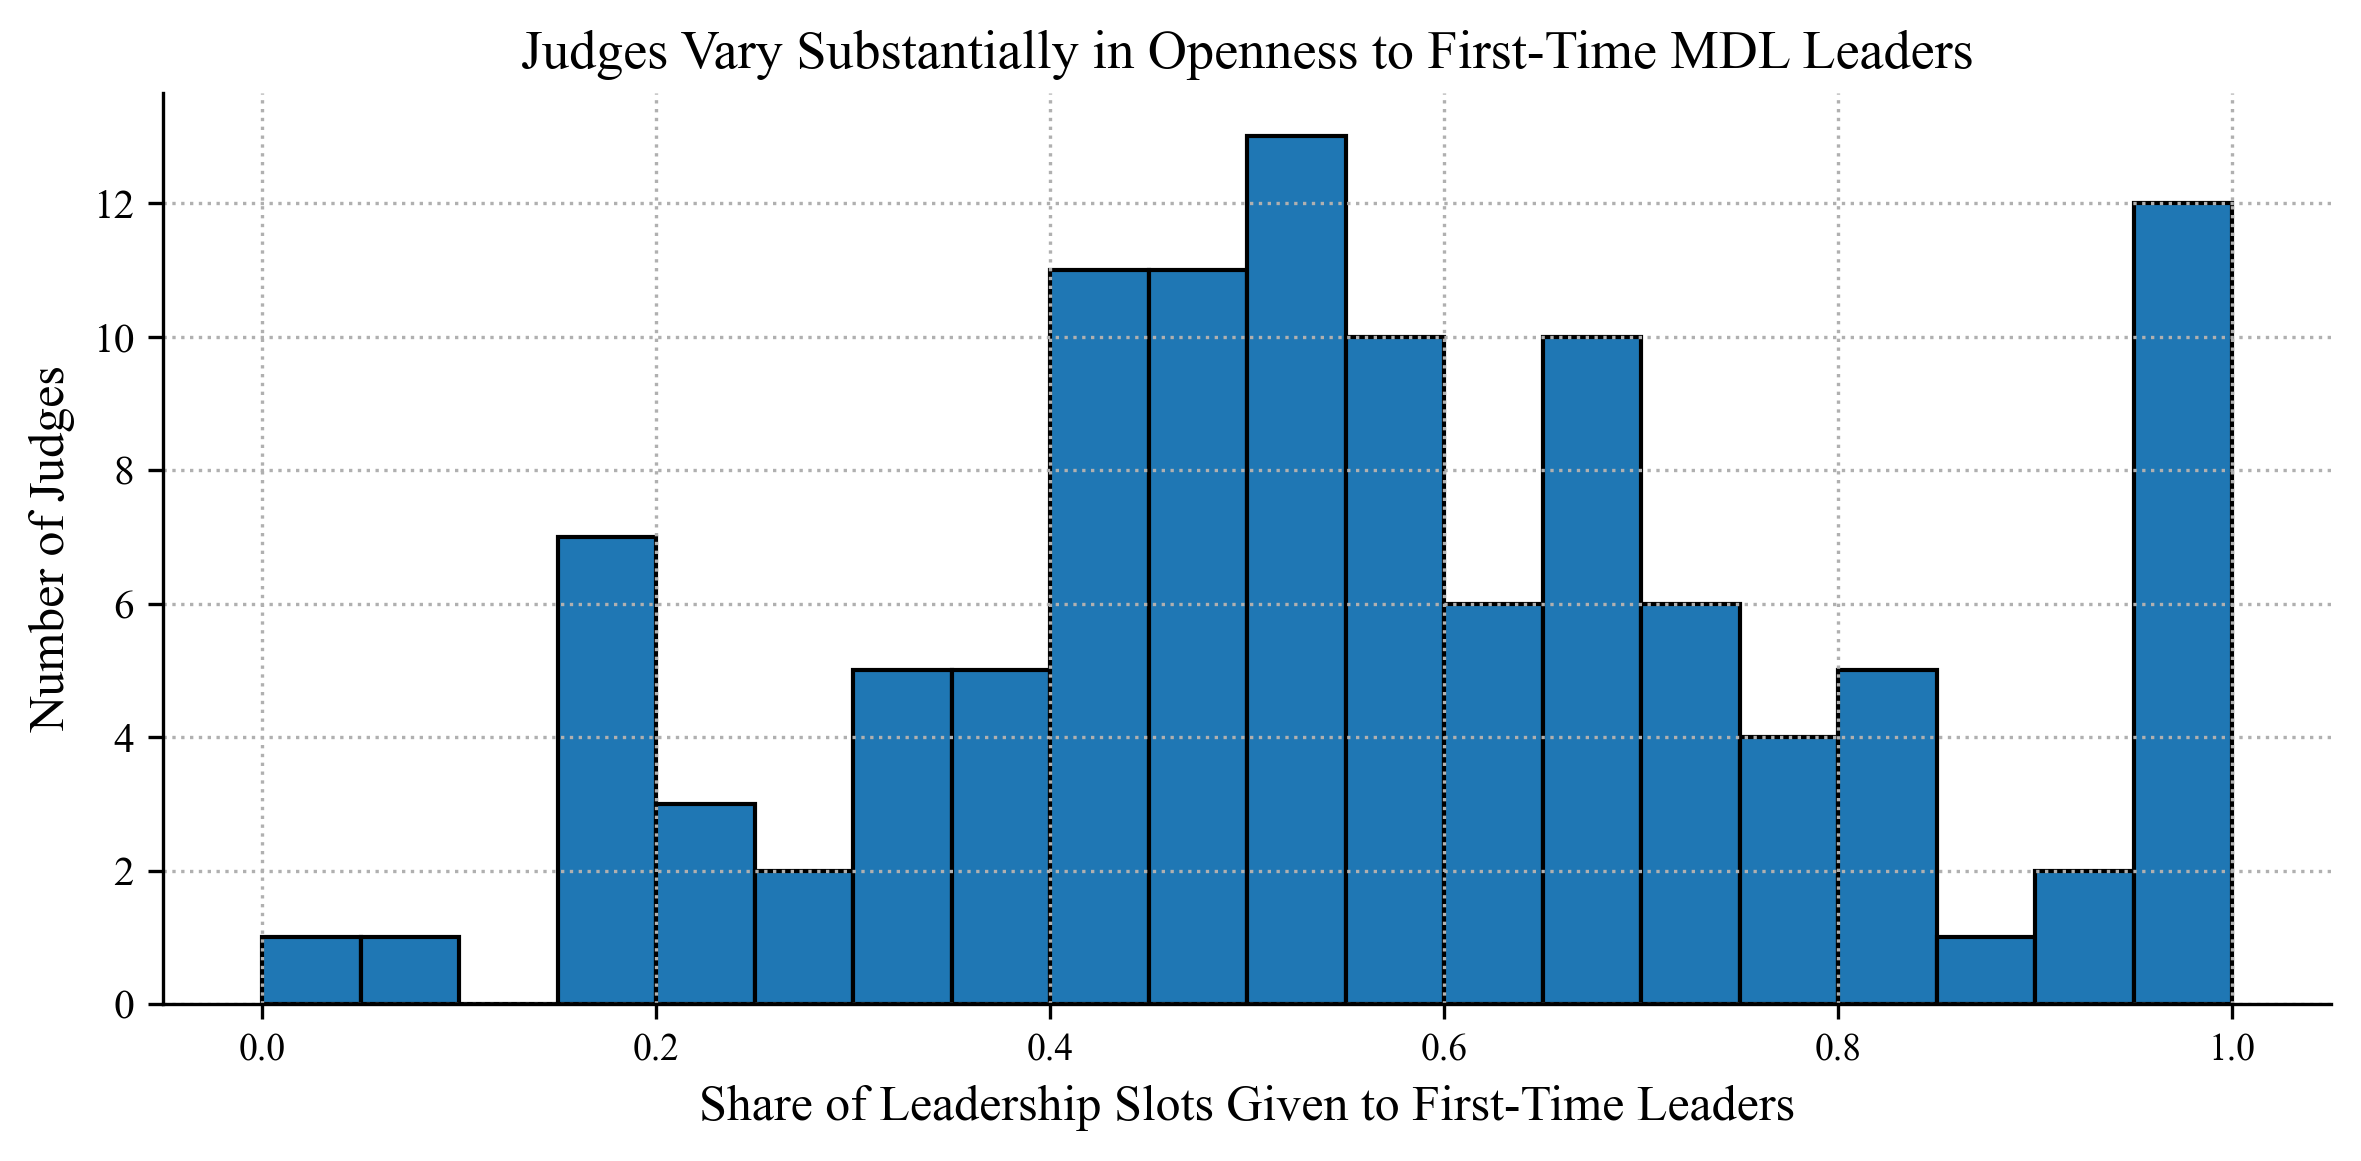

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ============================================================
# 1. MERGE ATTORNEY APPOINTMENTS WITH JUDGE DATA
# ============================================================

# Join attorney-MDL records with judge assigned to each MDL
df = attorney_x_mdl.merge(
    orders[["mdl_no", "judge"]],
    left_on="mdl_no_from_orders",
    right_on="mdl_no",
    how="left"
)

# ============================================================
# 2. DATA CLEANING
# ============================================================

# Drop records missing judge, attorney, or MDL information
df = df.dropna(subset=["judge", "attorney_id", "mdl_no"])

# Standardize types
df["attorney_id"] = df["attorney_id"].astype(str)
df["mdl_no"] = df["mdl_no"].astype(int)
df["judge"] = df["judge"].astype(str)

# ============================================================
# 3. IDENTIFY FIRST-TIME MDL APPEARANCE
# ============================================================

# For each attorney, find the lowest MDL number they appear in
# (MDL numbers increase over time, so this approximates first appearance)
first_mdl = (
    df.groupby("attorney_id")["mdl_no"]
      .min()
      .rename("first_mdl")
)

df = df.merge(first_mdl, on="attorney_id", how="left")

# Flag appointments where attorney appears in their first MDL
df["is_first_time"] = (df["mdl_no"] == df["first_mdl"]).astype(int)

# ============================================================
# 4. JUDGE-LEVEL ENTRY OPENNESS
# ============================================================

# For each judge, count total leadership appointments and appointments
# given to attorneys appearing in an MDL for the first time
judge_entry = (
    df.groupby("judge")
      .agg(
          total_appointments=("attorney_id", "count"),
          first_time_appointments=("is_first_time", "sum")
      )
      .reset_index()
)

# Calculate share of slots given to newcomers
judge_entry["entry_share"] = (
    judge_entry["first_time_appointments"]
    / judge_entry["total_appointments"]
)

# Filter judges with minimal caseload (threshold can be adjusted)
judge_entry = judge_entry[judge_entry["total_appointments"] >= 10]

# Display top judges by openness to first-time leaders
judge_entry.sort_values("entry_share", ascending=False).head(10)

# ============================================================
# 5. PLOT — DISTRIBUTION OF JUDGE OPENNESS
# ============================================================

plt.figure(figsize=(8, 4))

plt.hist(
    judge_entry["entry_share"],
    bins=20,
    edgecolor="black"
)

plt.xlabel("Share of Leadership Slots Given to First-Time Leaders")
plt.ylabel("Number of Judges")
plt.title(
    "Judges Vary Substantially in Openness to First-Time MDL Leaders"
)

# Force integer y-axis ticks (no fractional judge counts)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

# 3 - Figures (Appendix)

## 3.1 Figure 1: Geographic Distribution of Individual MDL Appointments by Bar State

In [99]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# ============================================================
# 1. LOAD AND MERGE DATA
# ============================================================

# Load attorney data and merge with appointments
attorneys = clean_column_names(pd.read_csv(data_dir / "attorneys.csv"))

appointments_attorneys = appointments.merge(
    attorneys,
    how='left',
    left_on='attorney',
    right_on='attorney_identifier'
)

# ============================================================
# 2. EXTRACT AND CLEAN BAR STATE DATA
# ============================================================

# Use correct attorney_id column (may be attorney_id_x after merge)
attorney_id_col = 'attorney_id_x' if 'attorney_id_x' in appointments_attorneys.columns else 'attorney_id'

# Select attorney ID and bar state columns, drop missing values
tmp = appointments_attorneys[[attorney_id_col, 'bar_states']].dropna()
tmp = tmp.rename(columns={attorney_id_col: 'attorney_id'})

# Convert to string and split on semicolon (attorneys may have multiple bars)
tmp['bar_states'] = tmp['bar_states'].astype(str)
tmp['bar_list'] = tmp['bar_states'].str.split(';')

# Explode into separate rows (one bar entry per row)
tmp = tmp.explode('bar_list')

# Clean whitespace
tmp['bar_list'] = tmp['bar_list'].str.strip()

# Extract state code (first two characters, uppercase)
tmp['state'] = tmp['bar_list'].str[:2].str.upper()

# Extract bar admission year (4-digit number at end of string)
tmp['bar_year'] = tmp['bar_list'].str.extract(r'(\d{4})$')[0].astype('Int64')

# Keep relevant columns and count by state
expanded = tmp[['attorney_id', 'state', 'bar_year']]
state_counts = expanded['state'].value_counts().rename_axis('state').reset_index(name='count')

print(f"Total states represented: {len(state_counts)}")
print(state_counts.head(10))

# ============================================================
# 3. STATE CENTROIDS FOR MAPPING
# ============================================================

# Define geographic center points for each US state (for label placement)
state_centers = pd.DataFrame({
    'state': ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY'],
    'lat':    [32.8,61.3,34.2,35.2,36.8,39.6,41.6,39.0,27.8,32.7,20.8,44.1,40.0,40.3,42.0,38.5,37.5,31.2,45.3,39.0,42.3,43.3,46.7,32.6,38.5,46.9,41.5,39.5,43.2,40.1,34.8,43.0,35.8,47.5,40.4,35.6,44.0,41.2,41.7,33.8,44.4,35.7,31.0,39.3,44.3,37.7,47.3,38.6,44.5,43.1],
    'lon':    [-86.8,-149.5,-111.9,-92.3,-119.4,-105.3,-72.7,-75.5,-81.7,-83.1,-157.5,-114.7,-89.0,-86.1,-93.5,-98.0,-85.0,-91.9,-69.0,-76.8,-71.8,-84.7,-94.5,-89.7,-92.4,-110.4,-99.7,-116.6,-71.6,-74.7,-105.0,-75.5,-78.7,-100.5,-82.8,-97.5,-120.6,-77.8,-71.6,-80.9,-100.3,-86.4,-100.0,-78.5,-72.7,-79.0,-120.5,-80.5,-89.6,-107.3]
})

# Merge state counts with geographic coordinates
merged = pd.merge(state_counts, state_centers, on='state', how='left')

# ============================================================
# 4. CREATE CHOROPLETH MAP
# ============================================================

# Create choropleth with state abbreviations as locations
choromap = px.choropleth(
    merged,
    locations='state',
    locationmode='USA-states',
    color='count',
    color_continuous_scale='YlOrBr',
    scope='usa',
    title='Appointments by Bar State'
)

# Add state abbreviation labels at geographic centroids
choromap.add_trace(go.Scattergeo(
    locationmode='USA-states',
    lon=merged['lon'],
    lat=merged['lat'],
    text=merged['state'],
    mode='text',
    textfont=dict(size=10, color='black'),
    showlegend=False
))

# Update layout styling
choromap.update_layout(
    geo=dict(bgcolor='rgba(0,0,0,0)'),
    coloraxis_colorbar=dict(title='Appointments')
)

choromap.show()


Total states represented: 55
  state  count
0    NY   1207
1    CA    719
2    PA    719
3    DC    692
4    TX    646
5    FL    580
6    NJ    539
7    IL    447
8    LA    301
9    MN    287


## 3.2 - Figure 2: Individual MDL Appointments by Bar State

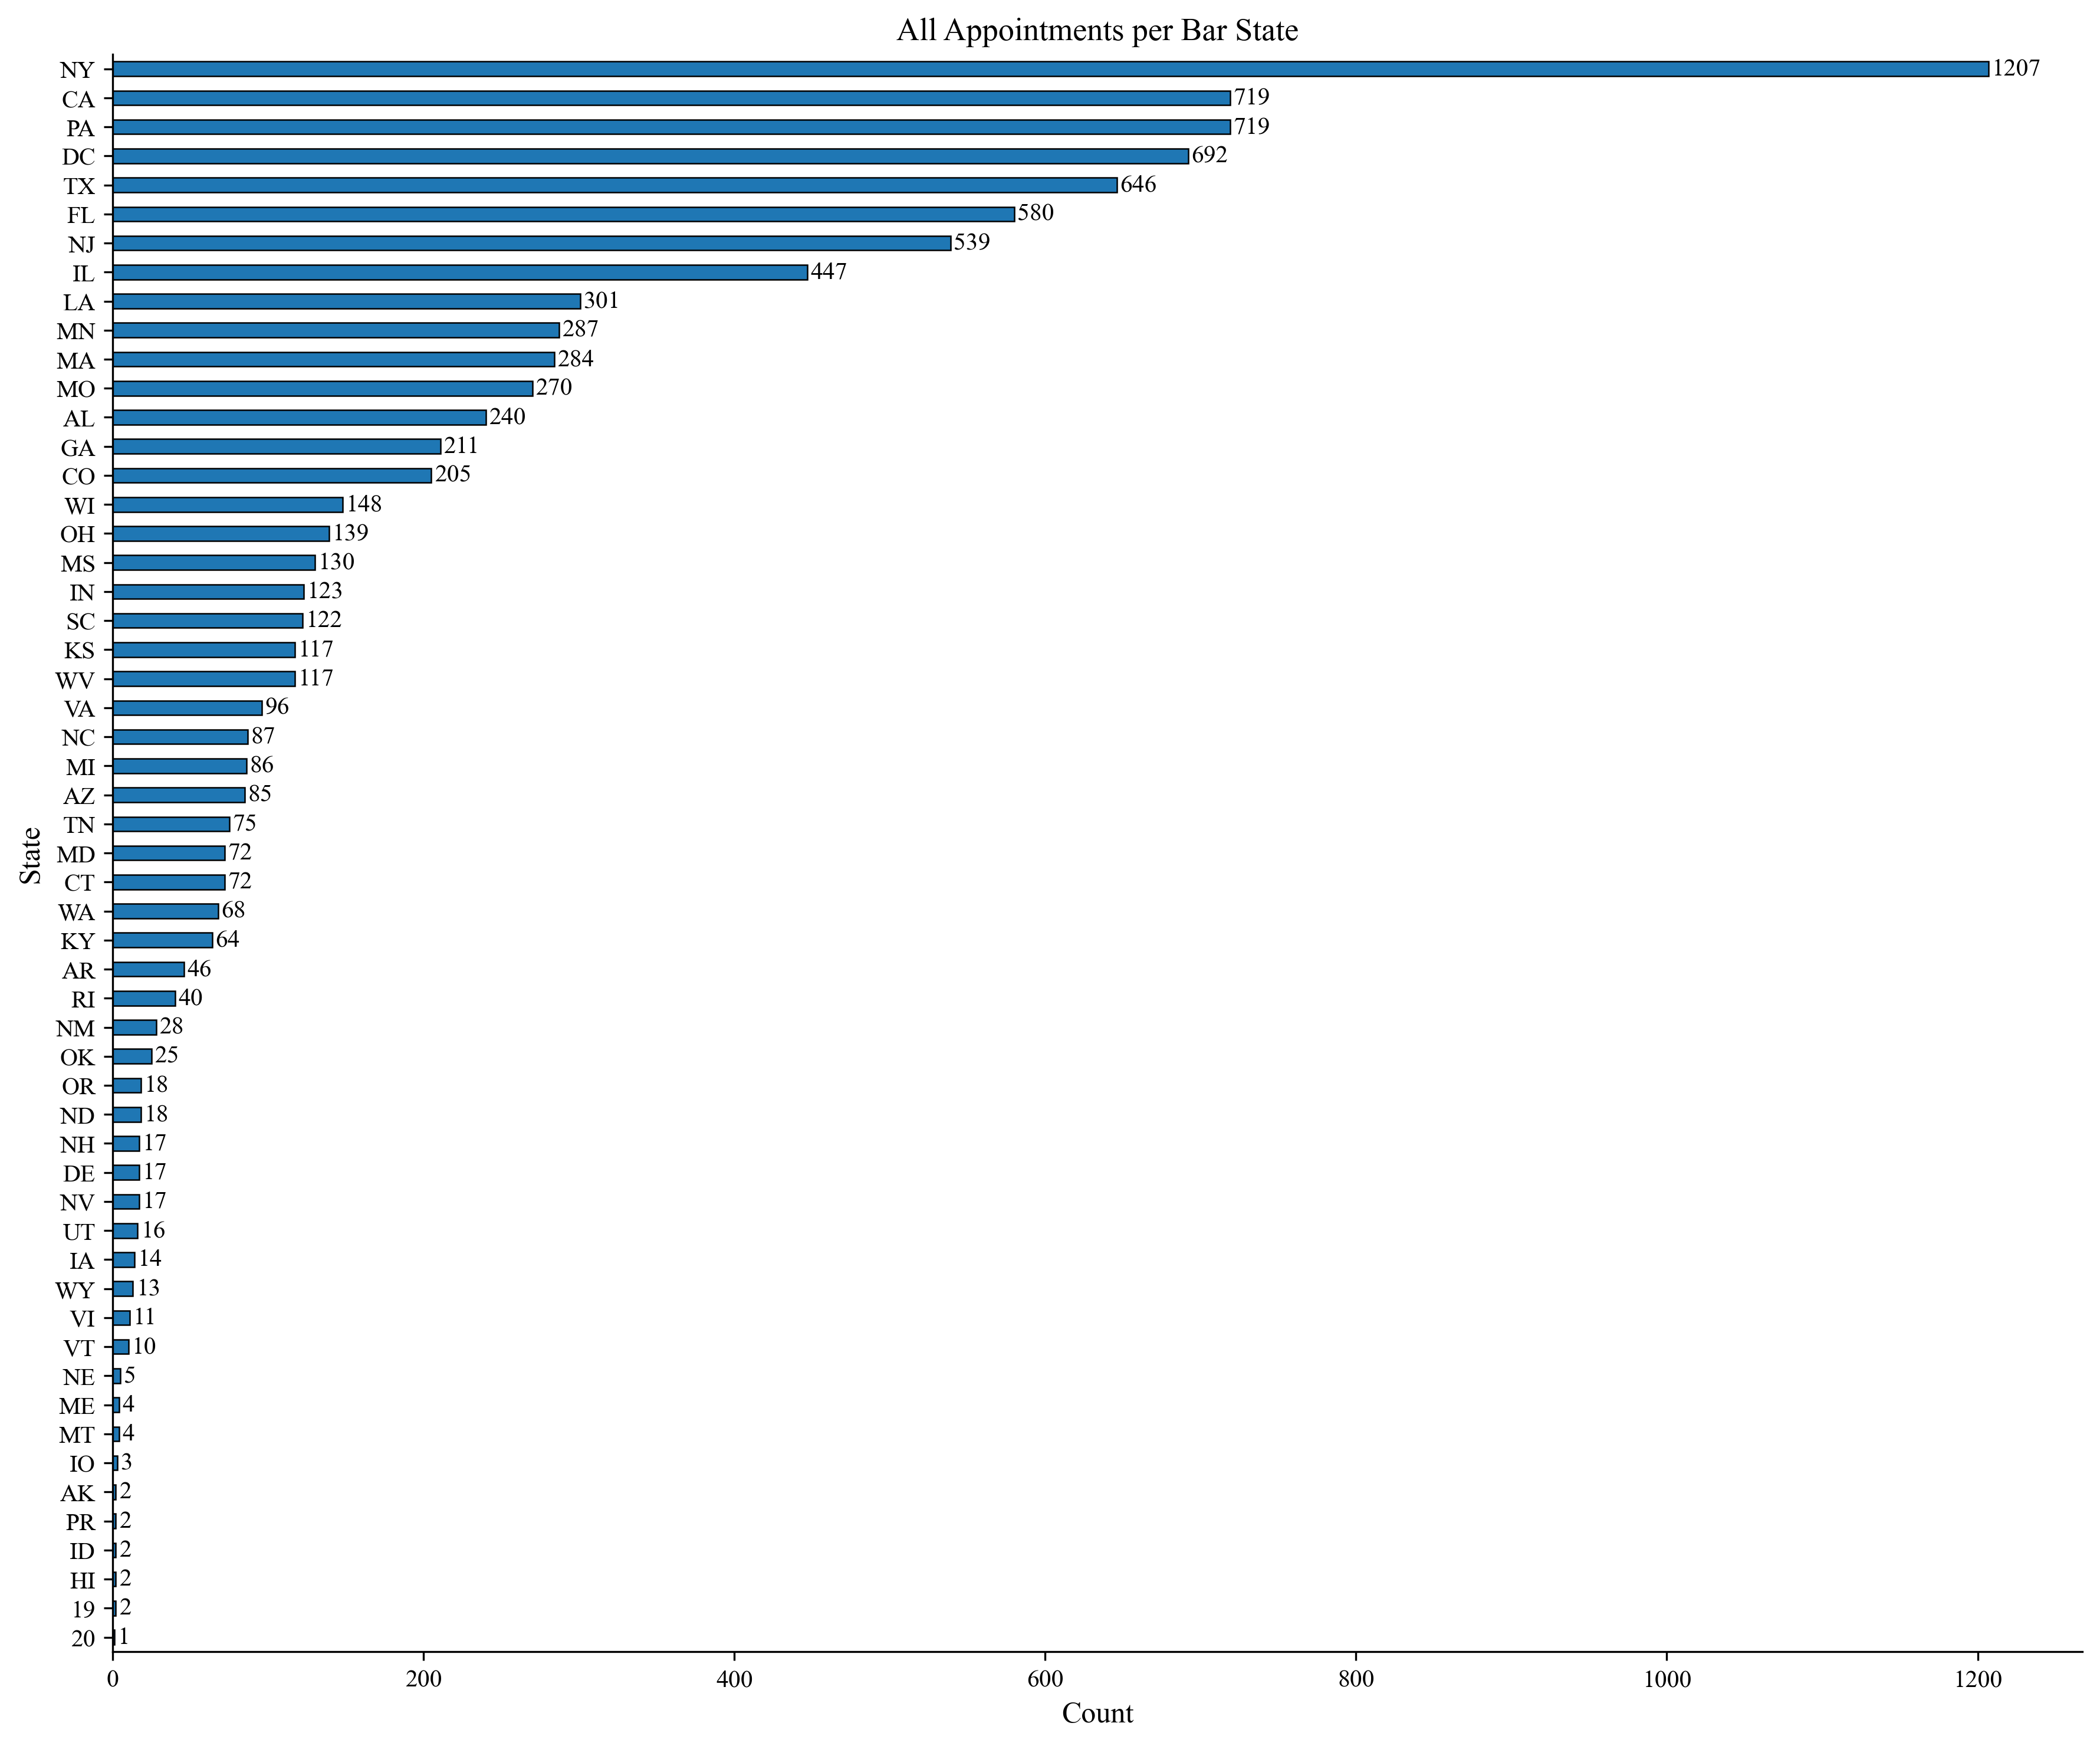

In [100]:
import matplotlib.pyplot as plt

# ============================================================
# PLOT STYLE
# ============================================================

# Configure matplotlib globally for publication-quality output
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300,
    "axes.linewidth": 0.8,
    "axes.edgecolor": "black",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ============================================================
# 1. EXTRACT AND CLEAN BAR STATE DATA
# ============================================================

# Use correct attorney_id column (from appointments or attorneys table)
attorney_id_col = 'attorney_id_x' if 'attorney_id_x' in appointments_attorneys.columns else 'attorney_id'

# Select attorney ID and bar state columns, drop missing values
tmp_all = appointments_attorneys[[attorney_id_col, 'bar_states']].dropna()
tmp_all = tmp_all.rename(columns={attorney_id_col: 'attorney_id'})

# Convert bar_states to string and split on semicolon (multiple bars per attorney)
tmp_all['bar_states'] = tmp_all['bar_states'].astype(str)
tmp_all['bar_list'] = tmp_all['bar_states'].str.split(';')

# Explode list into separate rows (one bar entry per row)
tmp_all = tmp_all.explode('bar_list')

# Clean whitespace and extract state code (first two characters)
tmp_all['bar_list'] = tmp_all['bar_list'].str.strip()
tmp_all['state'] = tmp_all['bar_list'].str[:2].str.upper()

# ============================================================
# 2. COUNT APPOINTMENTS BY STATE
# ============================================================

# Count frequency of each state, sort ascending for horizontal bar chart
all_state_counts = (
    tmp_all['state']
    .value_counts()
    .sort_values(ascending=True)
)

# ============================================================
# 3. PLOT — HORIZONTAL BAR CHART
# ============================================================

plt.figure(figsize=(12, 10))

# Create horizontal bar chart with black edges on bars
all_state_counts.plot(kind='barh', edgecolor='black', linewidth=0.6)

plt.title("All Appointments per Bar State")
plt.xlabel("Count")
plt.ylabel("State")

# Add value labels at end of each bar
for i, v in enumerate(all_state_counts):
    plt.text(v + 2, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 3.3 - Figure 3: Geographic Distribution of Individual MDL Appointments by Bar State (Lead Counsel)

In [101]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# ============================================================
# 1. FILTER TO LEAD COUNSEL APPOINTMENTS ONLY
# ============================================================

lead_only = appointments_attorneys[
    appointments_attorneys['appointment_types']
    .fillna('')
    .str.contains('LeadCounsel', case=False)
]

# ============================================================
# 2. EXTRACT AND CLEAN BAR STATE DATA
# ============================================================

# Use correct attorney_id column
attorney_id_col = 'attorney_id_x' if 'attorney_id_x' in lead_only.columns else 'attorney_id'

# Select attorney ID and bar state columns, drop missing values
tmp = lead_only[[attorney_id_col, 'bar_states']].dropna()
tmp = tmp.rename(columns={attorney_id_col: 'attorney_id'})

# Convert to string and split on semicolon
tmp['bar_states'] = tmp['bar_states'].astype(str)
tmp['bar_list'] = tmp['bar_states'].str.split(';')

# Explode into separate rows
tmp = tmp.explode('bar_list')

# Clean whitespace and extract state code
tmp['bar_list'] = tmp['bar_list'].str.strip()
tmp['state'] = tmp['bar_list'].str[:2].str.upper()

# ============================================================
# 3. COUNT LEAD COUNSEL APPOINTMENTS BY STATE
# ============================================================

state_counts = tmp['state'].value_counts().rename_axis('state').reset_index(name='count')

# ============================================================
# 4. STATE CENTROIDS FOR MAPPING
# ============================================================

state_centers = pd.DataFrame({
    'state': ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY'],
    'lat': [32.8,61.3,34.2,35.2,36.8,39.6,41.6,39.0,27.8,32.7,20.8,44.1,40.0,40.3,42.0,38.5,37.5,31.2,45.3,39.0,42.3,43.3,46.7,32.6,38.5,46.9,41.5,39.5,43.2,40.1,34.8,43.0,35.8,47.5,40.4,35.6,44.0,41.2,41.7,33.8,44.4,35.7,31.0,39.3,44.3,37.7,47.3,38.6,44.5,43.1],
    'lon': [-86.8,-149.5,-111.9,-92.3,-119.4,-105.3,-72.7,-75.5,-81.7,-83.1,-157.5,-114.7,-89.0,-86.1,-93.5,-98.0,-85.0,-91.9,-69.0,-76.8,-71.8,-84.7,-94.5,-89.7,-92.4,-110.4,-99.7,-116.6,-71.6,-74.7,-105.0,-75.5,-78.7,-100.5,-82.8,-97.5,-120.6,-77.8,-71.6,-80.9,-100.3,-86.4,-100.0,-78.5,-72.7,-79.0,-120.5,-80.5,-89.6,-107.3]
})

merged = pd.merge(state_counts, state_centers, on='state', how='left')

# ============================================================
# 5. CREATE CHOROPLETH MAP
# ============================================================

fig = px.choropleth(
    merged,
    locations='state',
    locationmode='USA-states',
    color='count',
    color_continuous_scale='Reds',
    scope='usa',
    title='LeadCounsel Appointments by Bar State'
)

fig.add_trace(go.Scattergeo(
    locationmode='USA-states',
    lon=merged['lon'],
    lat=merged['lat'],
    text=merged['state'],
    mode='text',
    textfont=dict(size=10, color='black'),
    showlegend=False
))

fig.update_layout(
    geo=dict(bgcolor='rgba(0,0,0,0)'),
    coloraxis_colorbar=dict(title="LeadCounsel Count")
)

fig.show()

## 3.4 - Figure 4: Individual MDL Appointments by Bar State (Lead Counsel)

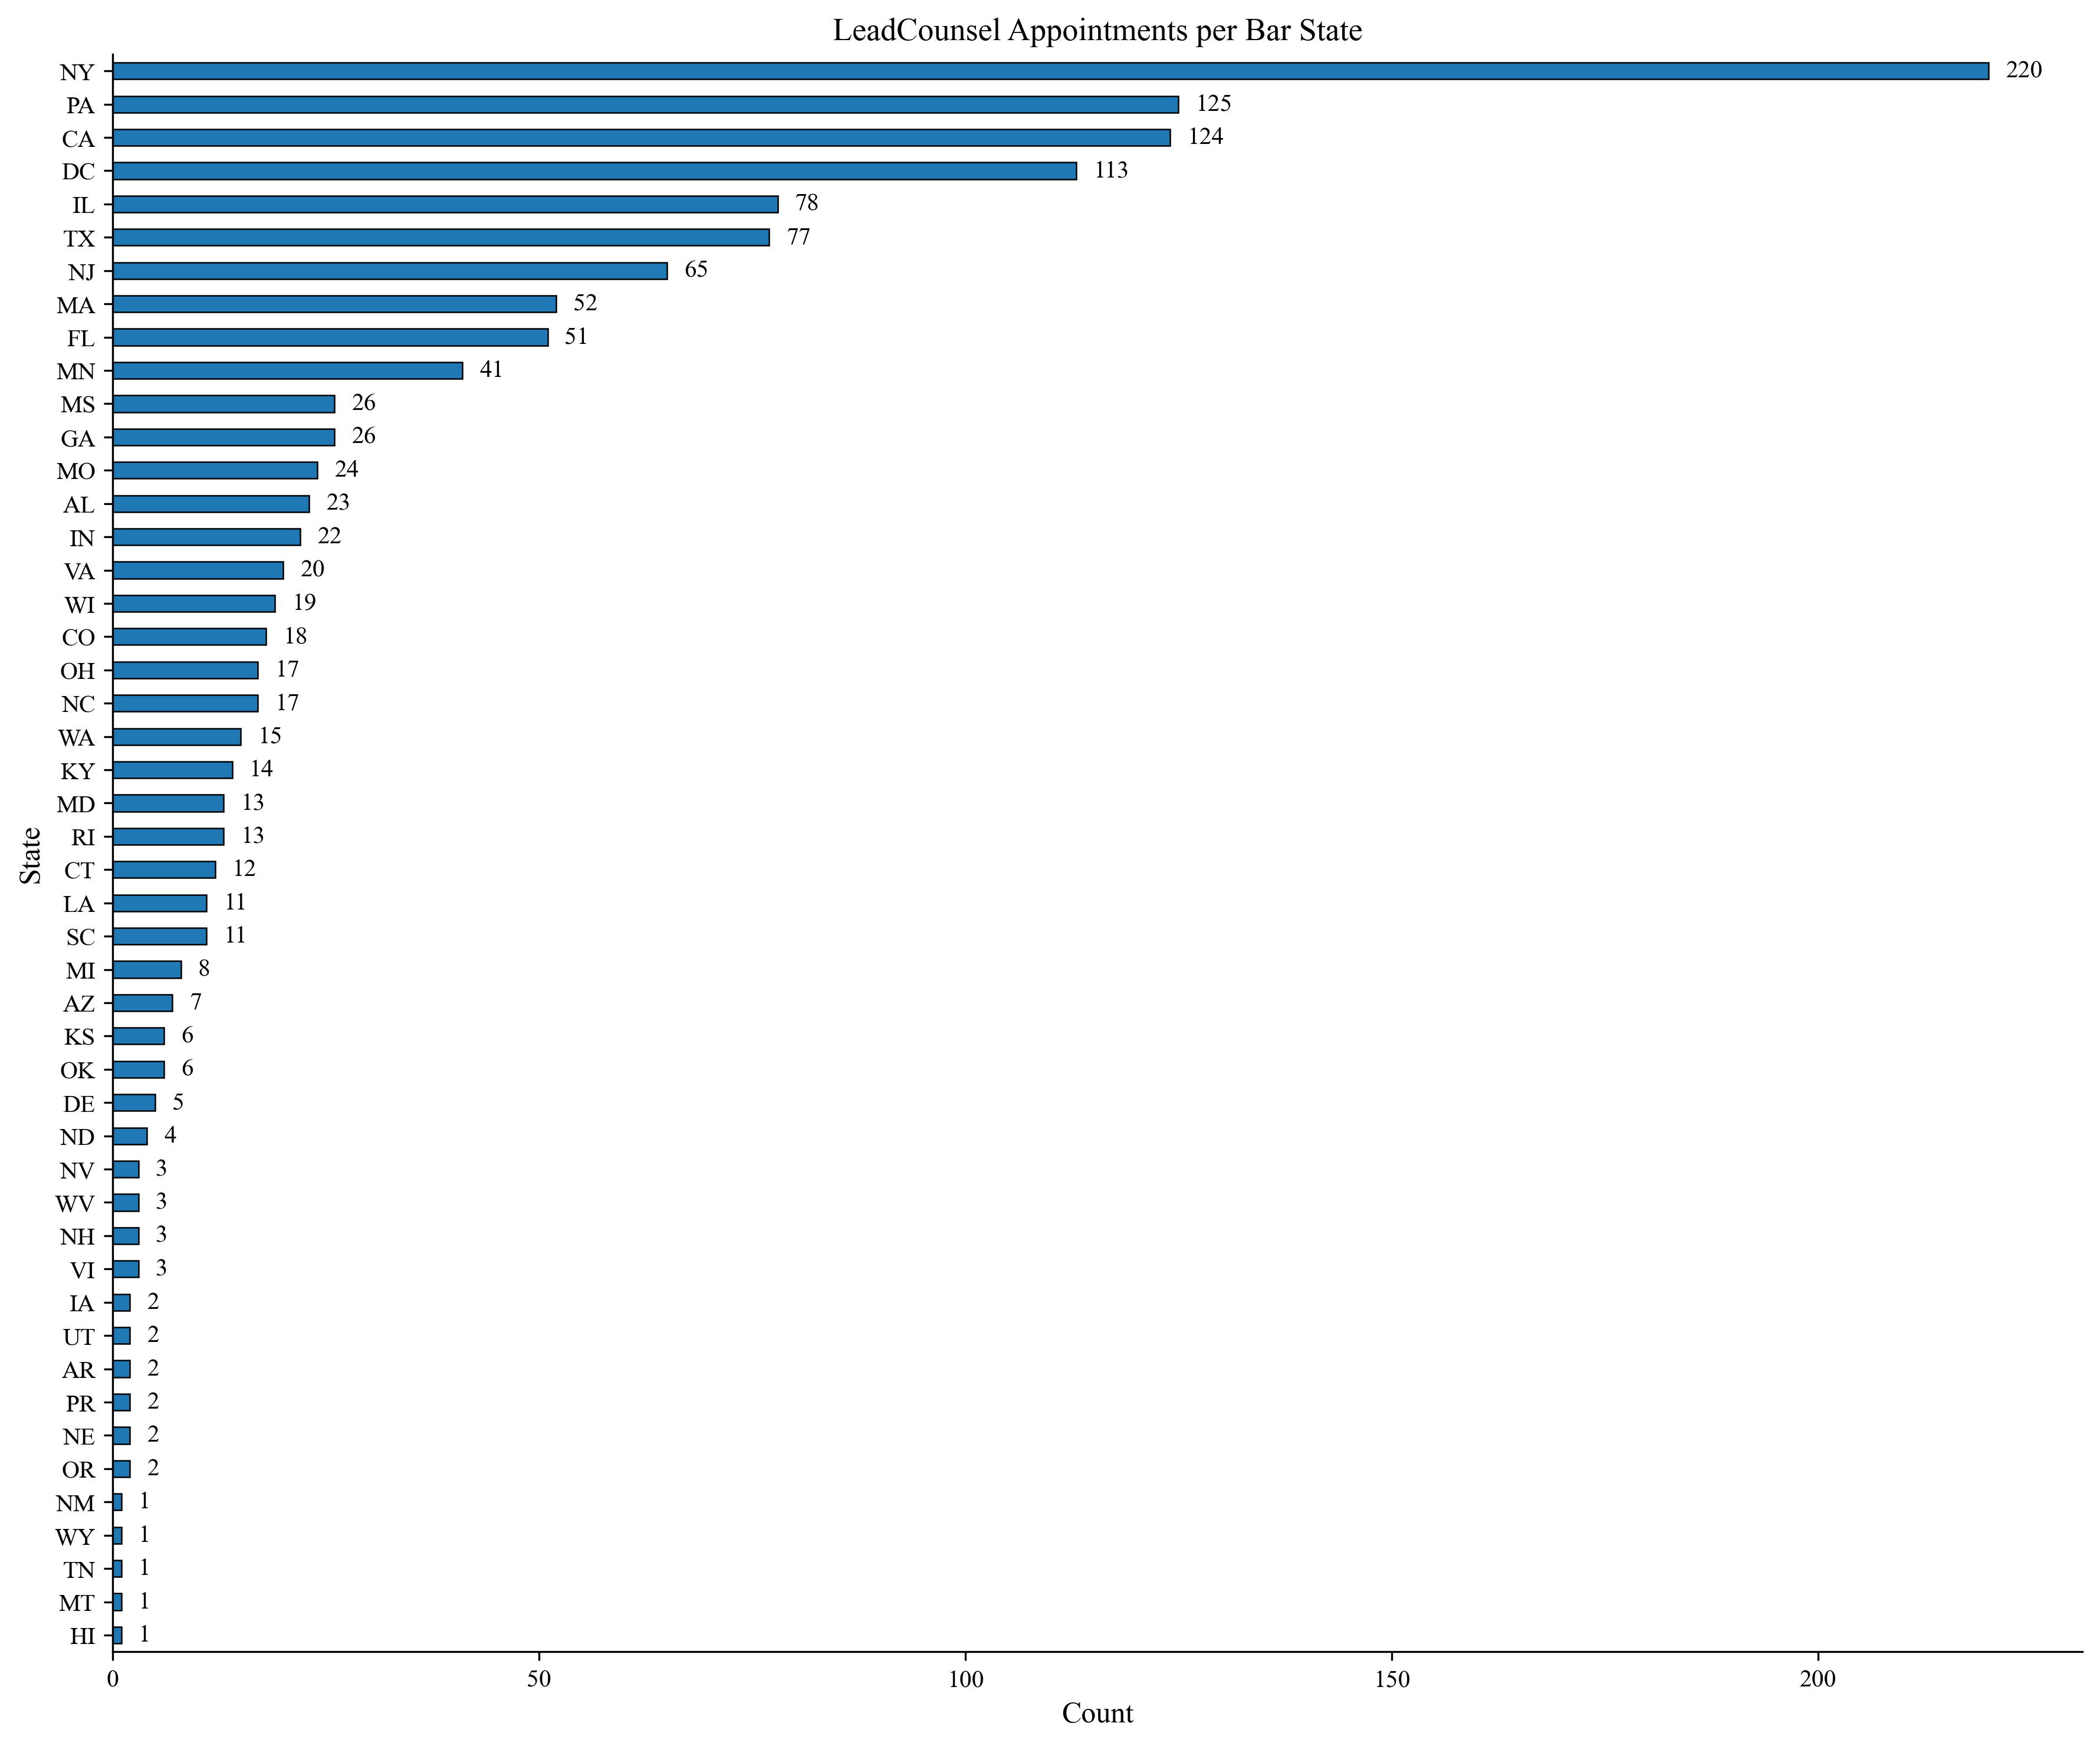

In [102]:
import matplotlib.pyplot as plt

# ============================================================
# PLOT STYLE
# ============================================================

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300,
    "axes.linewidth": 0.8,
    "axes.edgecolor": "black",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ============================================================
# 1. FILTER TO LEAD COUNSEL APPOINTMENTS ONLY
# ============================================================

# Select only appointments where attorney has LeadCounsel role
lead_only = appointments_attorneys[
    appointments_attorneys['appointment_types']
    .fillna('')
    .str.contains('LeadCounsel', case=False)
]

# ============================================================
# 2. EXTRACT AND CLEAN BAR STATE DATA
# ============================================================

# Use correct attorney_id column (may be attorney_id_x after merge)
attorney_id_col = 'attorney_id_x' if 'attorney_id_x' in lead_only.columns else 'attorney_id'

# Select attorney ID and bar state columns, drop missing values
tmp_lead = lead_only[[attorney_id_col, 'bar_states']].dropna()
tmp_lead = tmp_lead.rename(columns={attorney_id_col: 'attorney_id'})

# Convert to string and split on semicolon (multiple bars per attorney)
tmp_lead['bar_states'] = tmp_lead['bar_states'].astype(str)
tmp_lead['bar_list'] = tmp_lead['bar_states'].str.split(';')

# Explode into separate rows (one bar entry per row)
tmp_lead = tmp_lead.explode('bar_list')

# Clean whitespace and extract state code (first two characters, uppercase)
tmp_lead['bar_list'] = tmp_lead['bar_list'].str.strip()
tmp_lead['state'] = tmp_lead['bar_list'].str[:2].str.upper()

# ============================================================
# 3. COUNT LEAD COUNSEL APPOINTMENTS BY STATE
# ============================================================

# Count frequency of each state for LeadCounsel appointments, sort ascending
lead_state_counts = (
    tmp_lead['state']
    .value_counts()
    .sort_values(ascending=True)
)

# ============================================================
# 4. PLOT — HORIZONTAL BAR CHART
# ============================================================

plt.figure(figsize=(12, 10))

# Create horizontal bar chart with black edges on bars
lead_state_counts.plot(kind='barh', edgecolor='black', linewidth=0.6)

plt.title("LeadCounsel Appointments per Bar State")
plt.xlabel("Count")
plt.ylabel("State")

# Add value labels at end of each bar
for i, v in enumerate(lead_state_counts):
    plt.text(v + 2, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 3.5 - Figure 5: Gender distribution (All appointments)

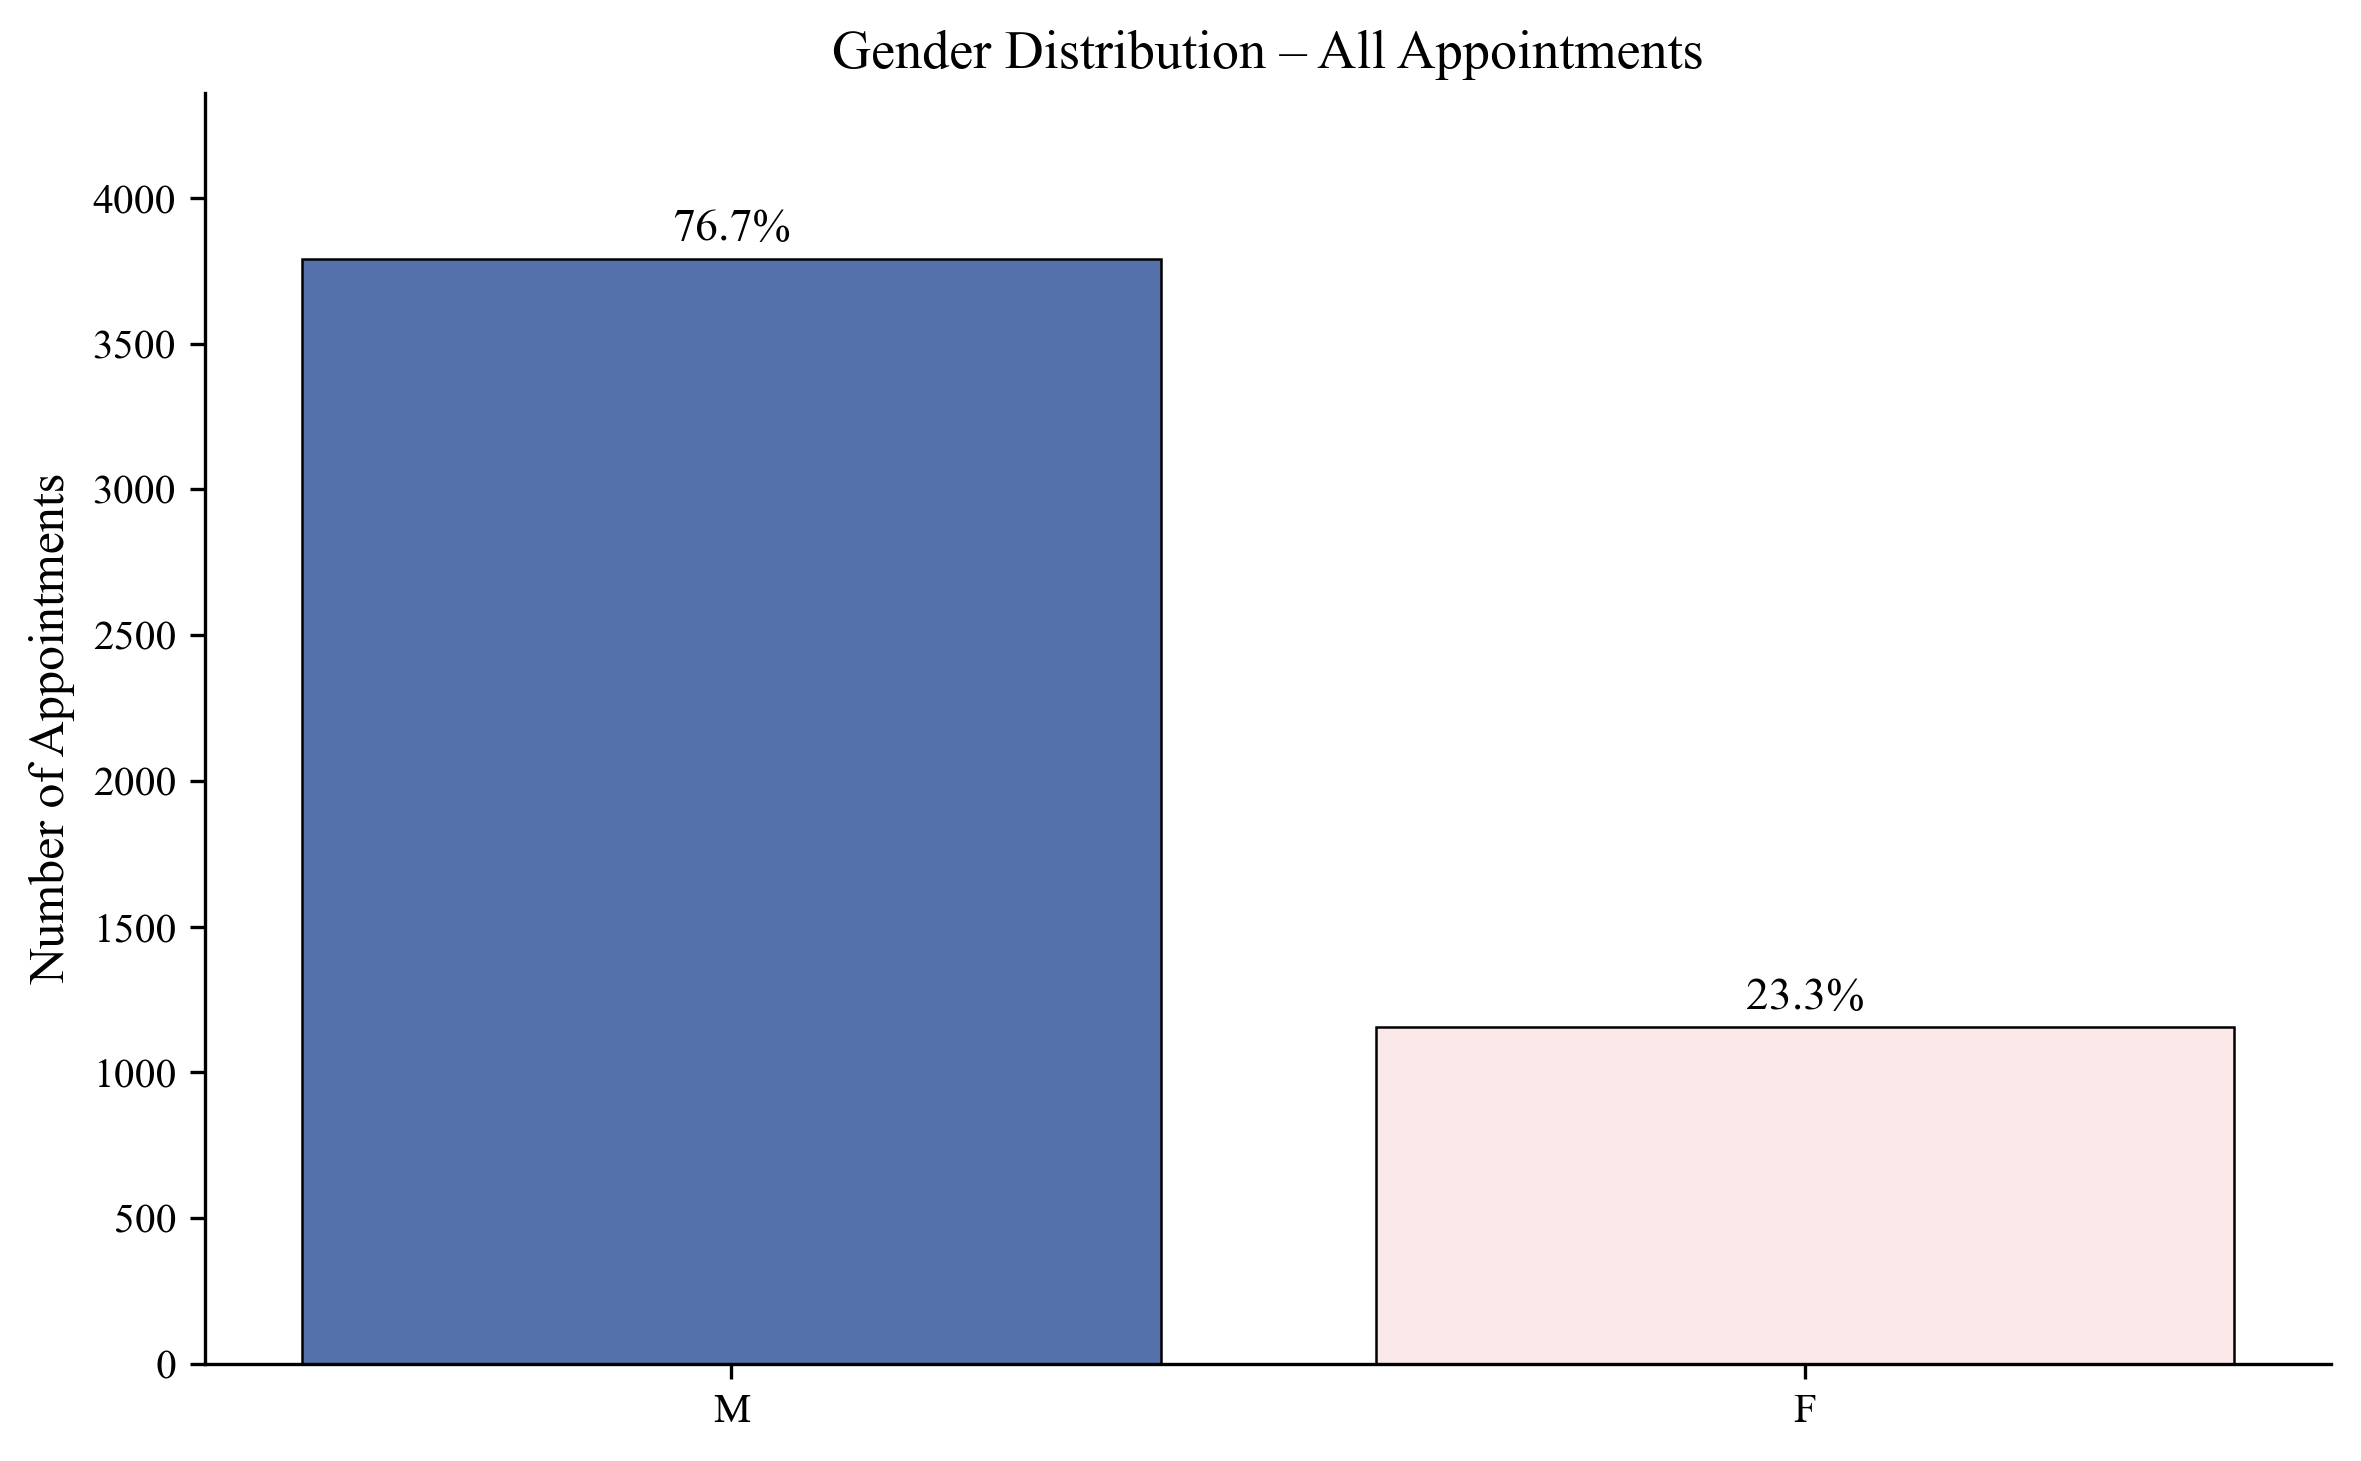

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# PLOT STYLE
# ============================================================

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300,
    "axes.linewidth": 0.8,
    "axes.edgecolor": "black",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ============================================================
# 1. FILTER TO BINARY GENDER (M/F ONLY)
# ============================================================

def filter_binary_gender(df):
    """Extract only appointments with M or F gender designation."""
    df = df.copy()
    df['gender'] = df['gender'].astype(str).str.strip().str.upper()
    return df[df['gender'].isin(['M', 'F'])]

# ============================================================
# 2. PREPARE GENDER DISTRIBUTION DATA
# ============================================================

# Filter all appointments to binary gender
checked_filtered = filter_binary_gender(appointments_attorneys)

# Further filter to LeadCounsel appointments only (optional)
lead_filtered = checked_filtered[
    checked_filtered['appointment_types'].fillna('').str.contains('LeadCounsel', case=False)
]

# ============================================================
# 3. GENDER DISTRIBUTION PLOTTING FUNCTION
# ============================================================

def plot_gender_distribution(df, title):
    """
    Create vertical bar chart of gender distribution with percentage labels.
    """
    # Count appointments by gender and calculate percentages
    gender_counts = df['gender'].value_counts()
    gender_perc = (gender_counts / gender_counts.sum() * 100).round(1)
    
    # Sort for consistent layout (M first, then F)
    gender_counts = gender_counts.sort_values(ascending=False)
    gender_perc = gender_perc[gender_counts.index]

    # Map colors: blue for M, pink for F
    colors = gender_counts.index.map(lambda g: '#5471AB' if g == 'M' else '#FBE8E9')

    # Create vertical bar chart
    plt.figure(figsize=(8, 5))
    bars = plt.bar(gender_counts.index, gender_counts.values, color=colors, edgecolor='black', linewidth=0.6)
    
    plt.title(title)
    plt.ylabel("Number of Appointments")
    plt.ylim(0, gender_counts.max() * 1.15)

    # Annotate bars with percentage labels above bars
    for bar, pct in zip(bars, gender_perc):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 30, f"{pct}%", 
                ha='center', va='bottom', fontsize=11)

    plt.tight_layout()
    plt.show()

# ============================================================
# 4. GENERATE PLOTS
# ============================================================

# All appointments
plot_gender_distribution(checked_filtered, "Gender Distribution – All Appointments")


## Figure 6: Gender distribution (Lead Counsel)

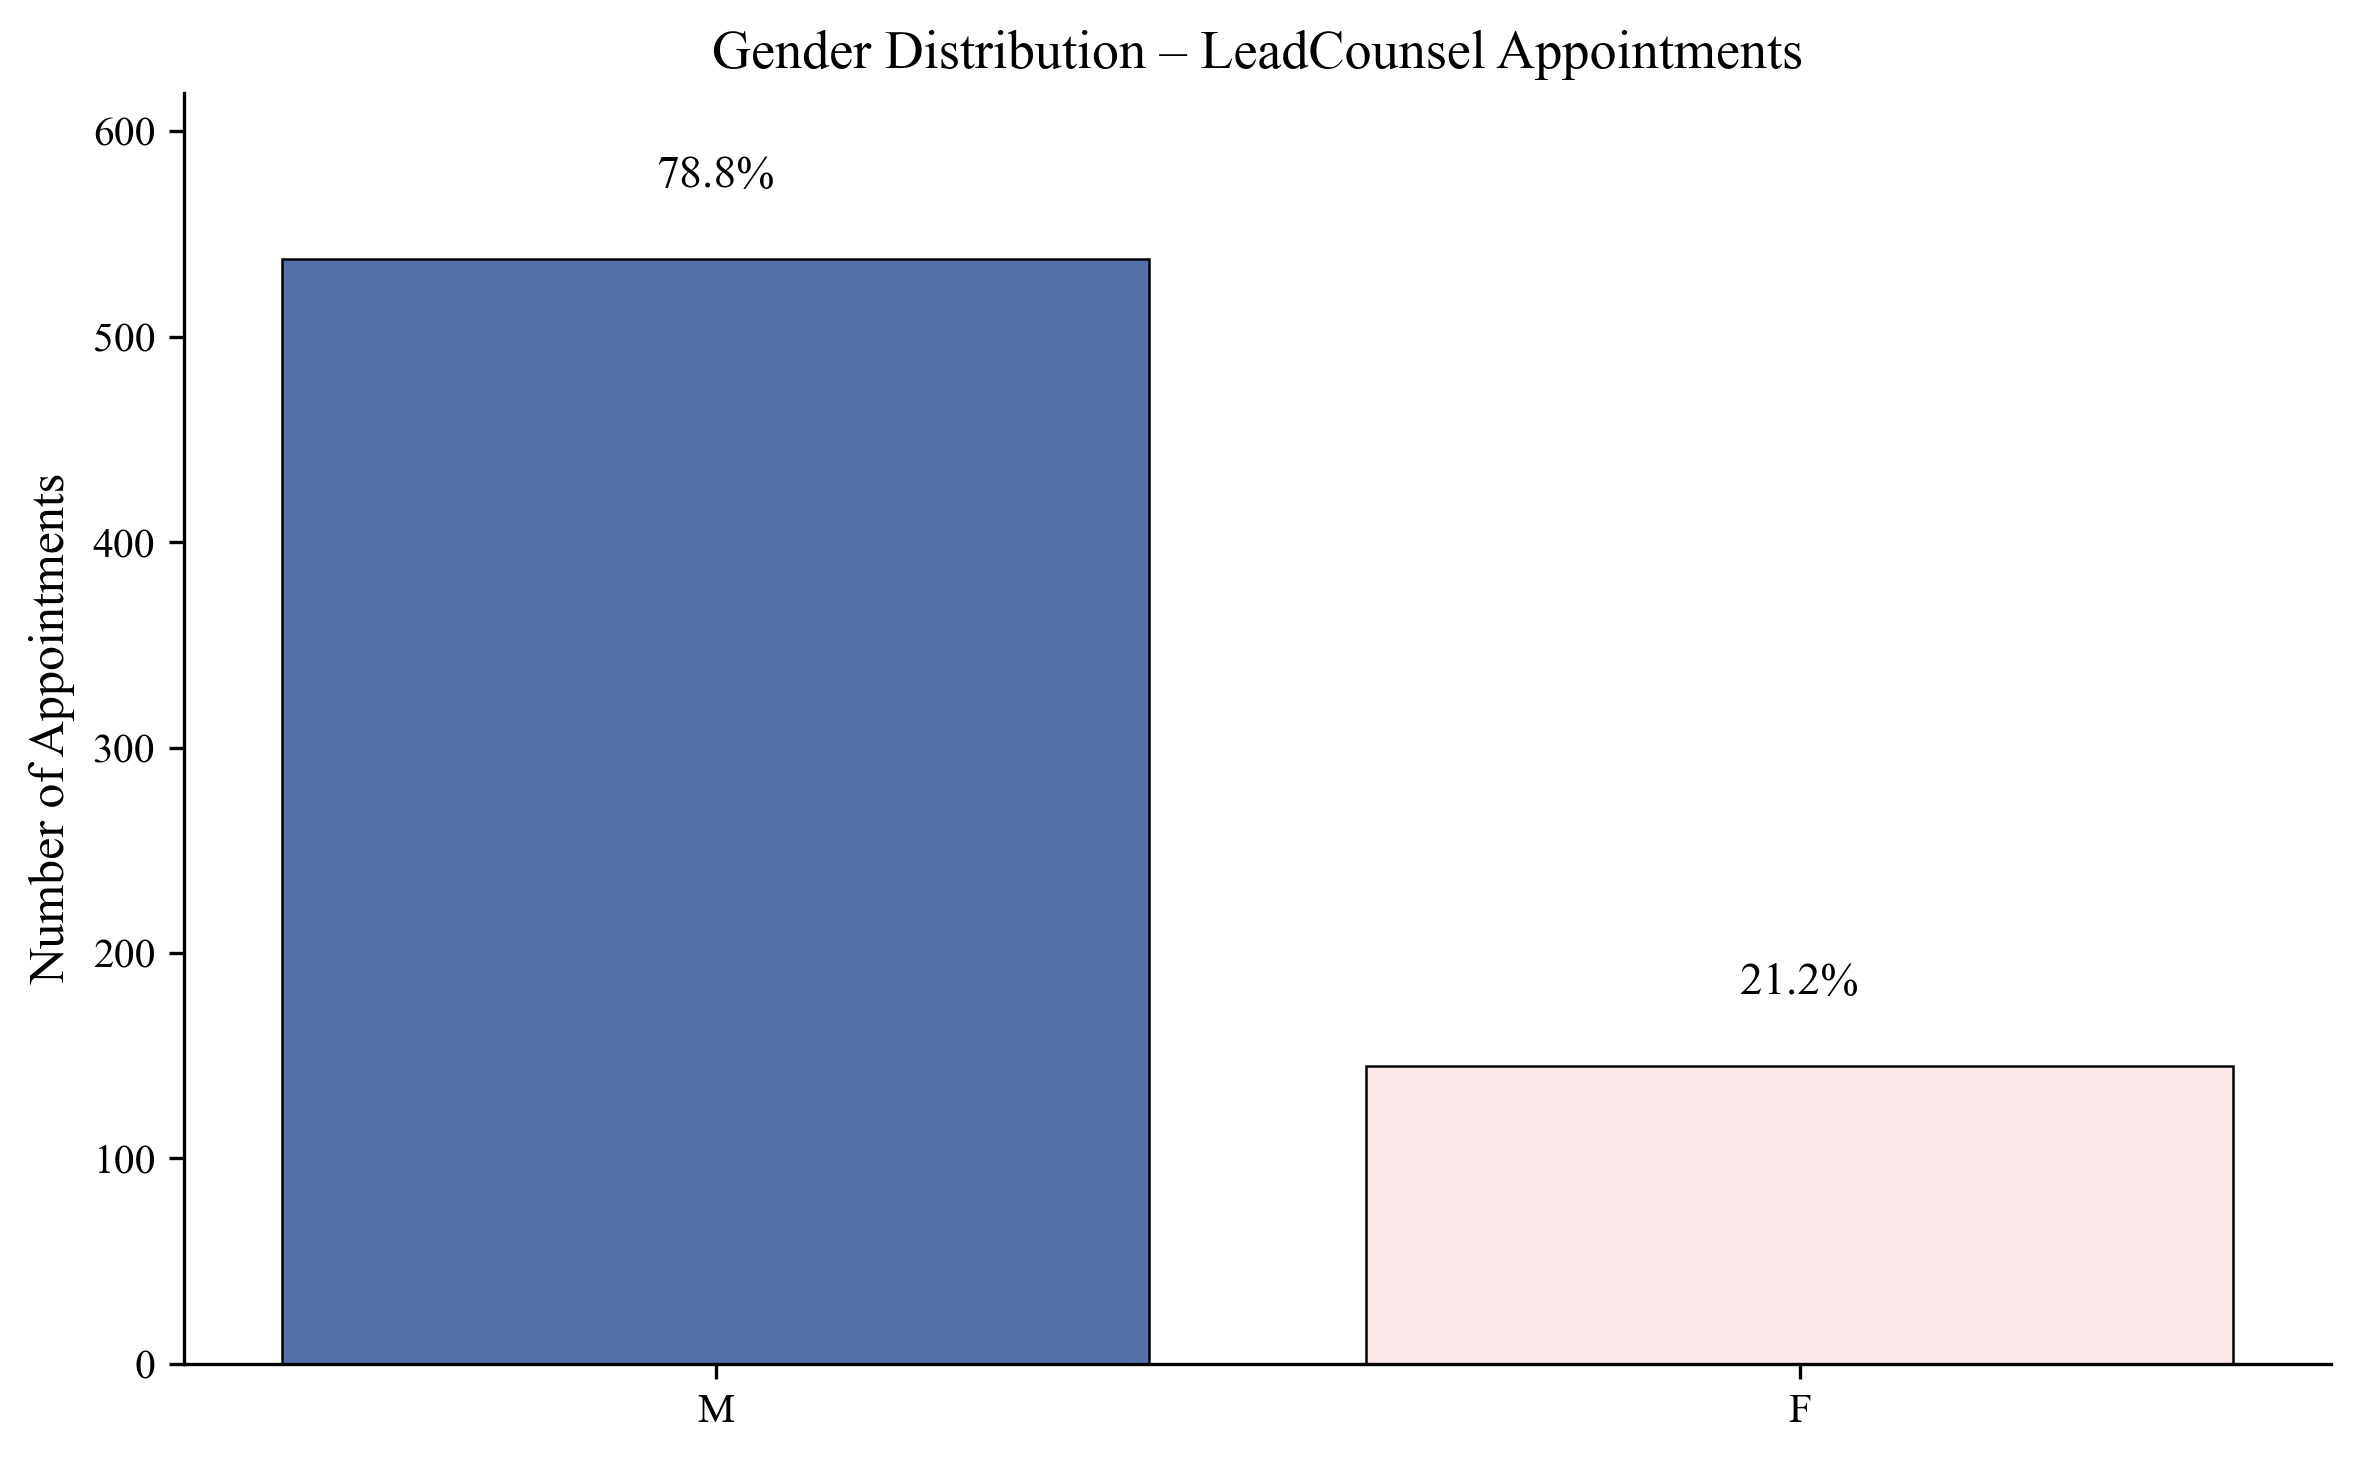

In [104]:
# LeadCounsel appointments (optional)
if len(lead_filtered) > 0:
    plot_gender_distribution(lead_filtered, "Gender Distribution – LeadCounsel Appointments")

## 3.7 - Figure 7: Age distribution (All roles)

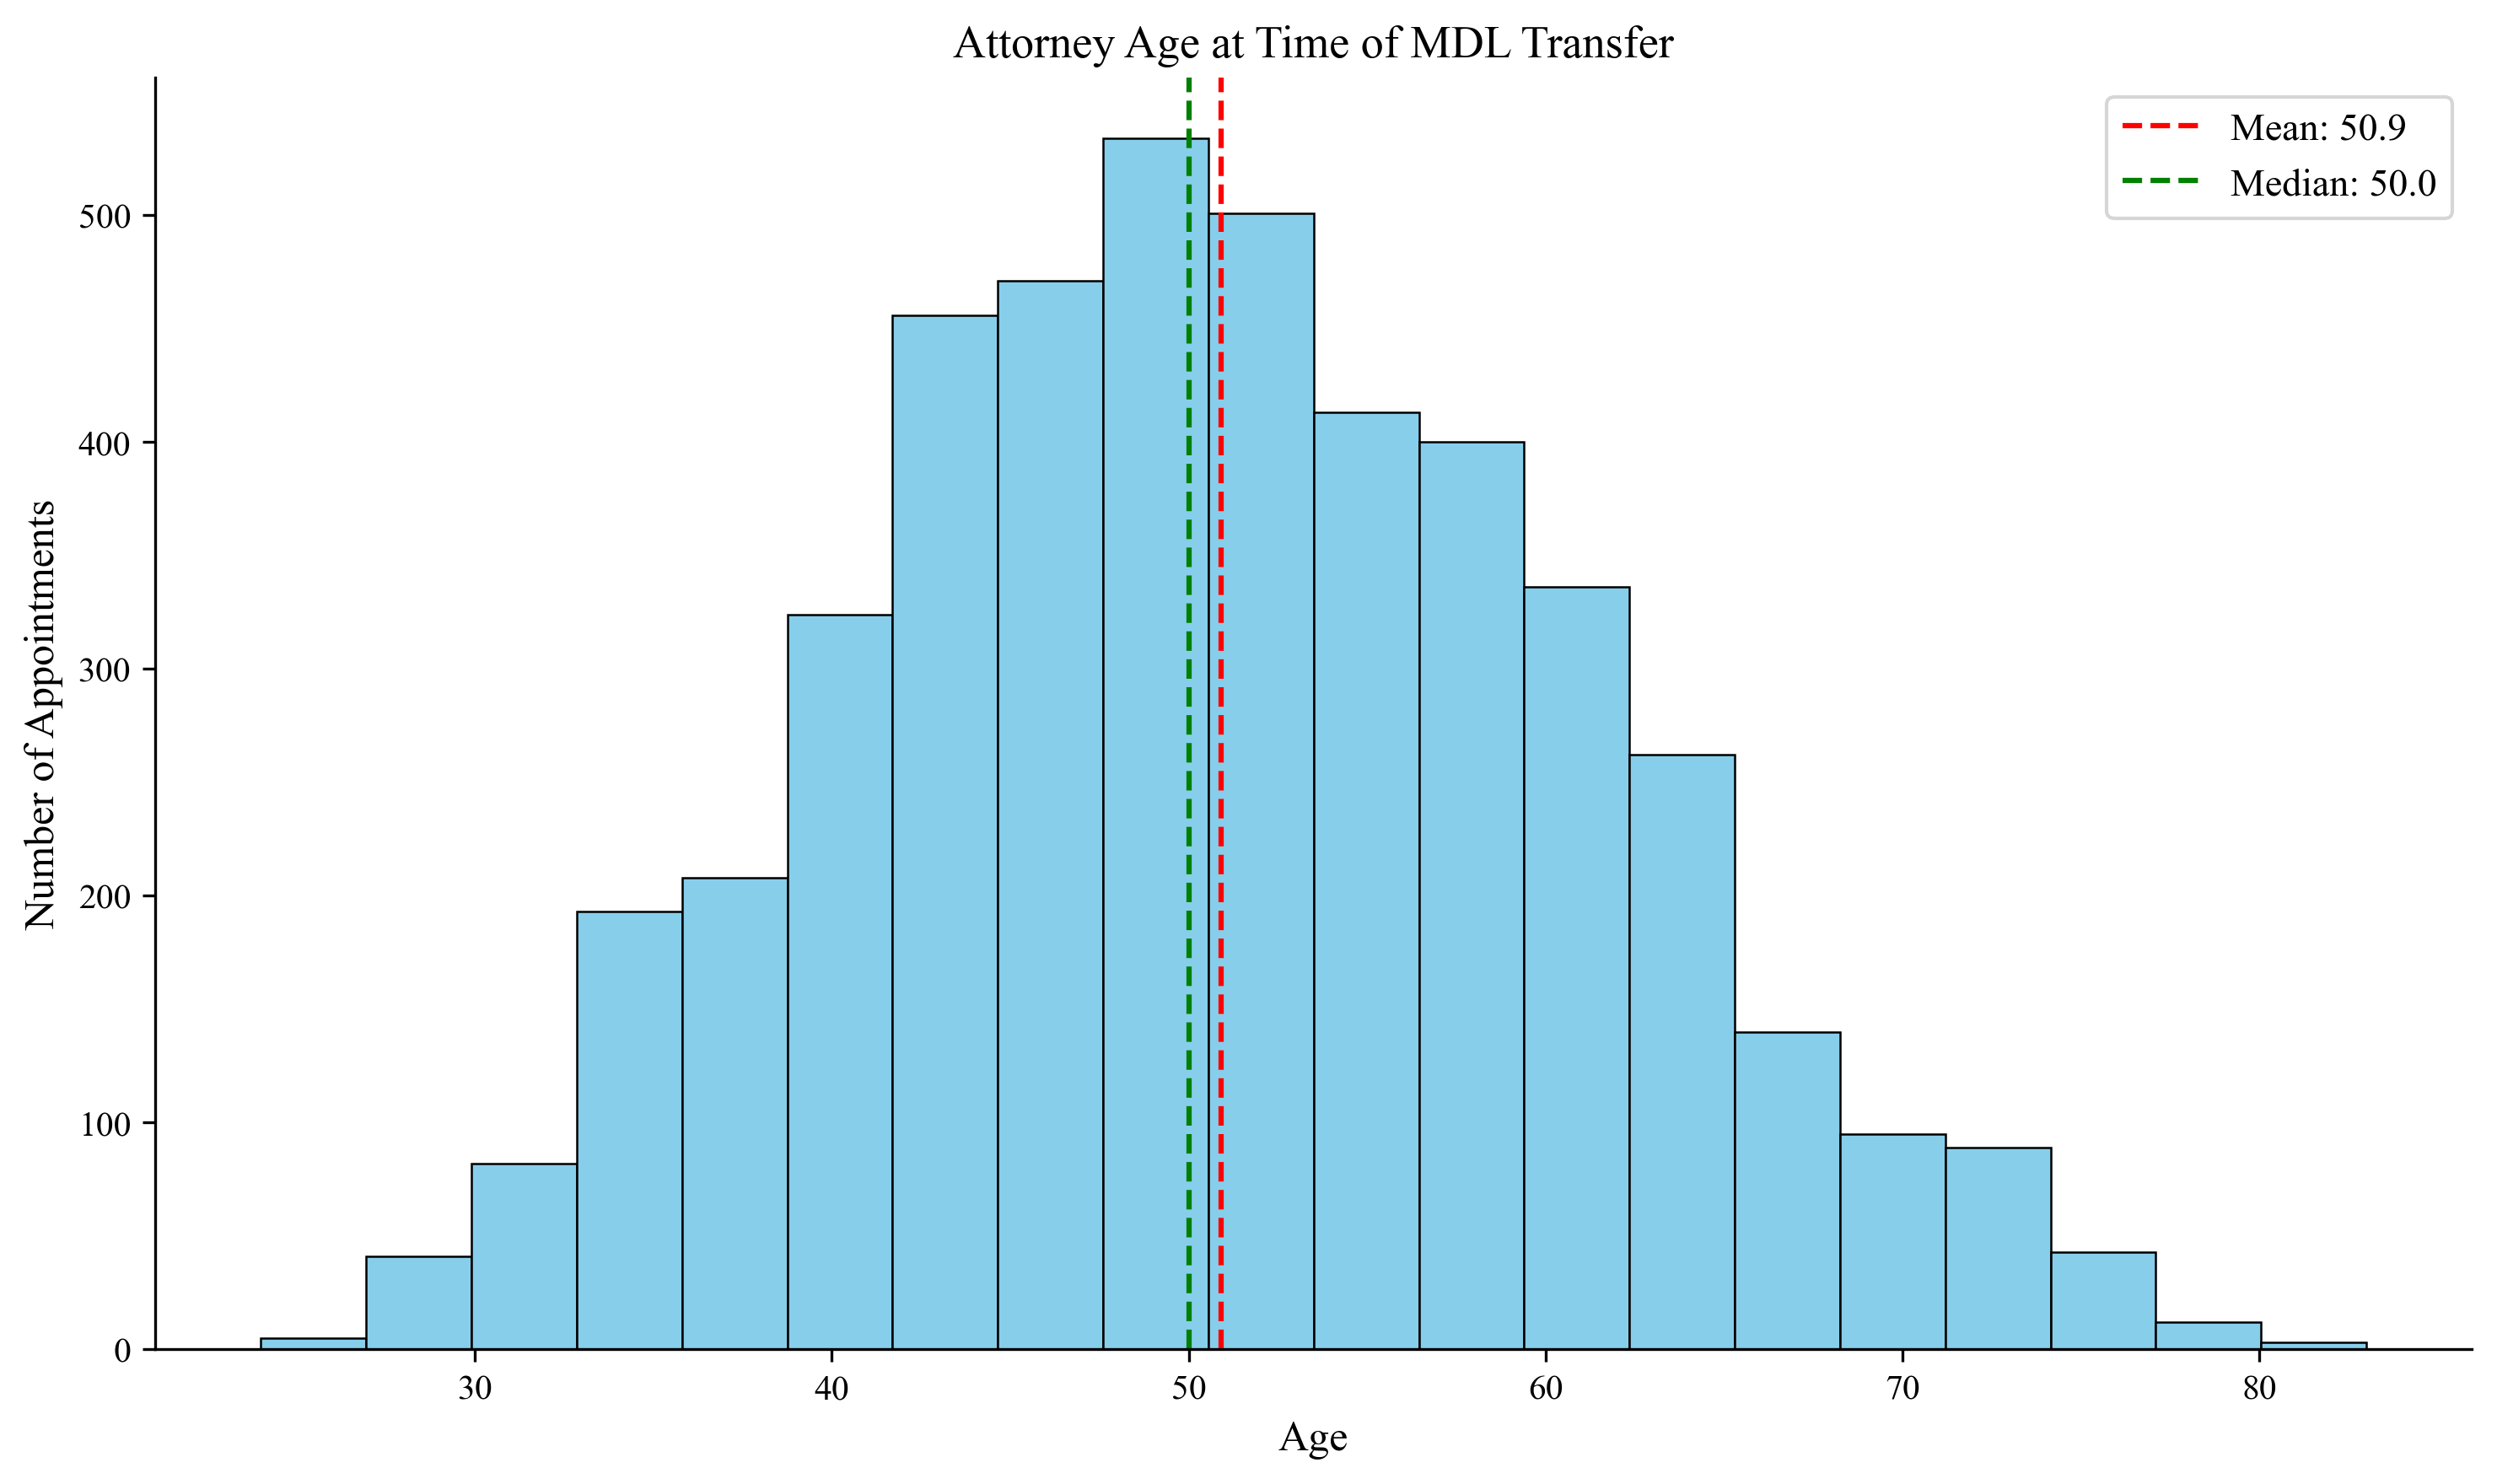

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# PLOT STYLE
# ============================================================

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300,
    "axes.linewidth": 0.8,
    "axes.edgecolor": "black",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ============================================================
# 1. CONVERT DATE COLUMNS TO DATETIME
# ============================================================

# Convert date columns, coerce invalid dates to NaT
mdls['date_transferred'] = pd.to_datetime(mdls['date_transferred'], errors='coerce')
mdls['date_filed'] = pd.to_datetime(mdls['date_filed'], errors='coerce')

# ============================================================
# 2. MERGE APPOINTMENTS WITH MDL TRANSFER DATES
# ============================================================

# Join appointments with MDL information to get transfer dates
merged = appointments_attorneys.merge(
    mdls[['mdl_no', 'date_filed', 'date_transferred']],
    how='left',
    left_on='mdl_no_from_orders',
    right_on='mdl_no'
)

# ============================================================
# 3. CALCULATE ATTORNEY AGE AT TIME OF MDL TRANSFER
# ============================================================

# Drop records missing birth year or transfer date
merged = merged.dropna(subset=['birth_year', 'date_transferred'])

# Convert birth year to integer
merged['birth_year'] = merged['birth_year'].astype(int)

# Calculate age as difference between transfer year and birth year
merged['age_at_transfer'] = merged['date_transferred'].dt.year - merged['birth_year']

# ============================================================
# 4. CALCULATE SUMMARY STATISTICS
# ============================================================

# Calculate mean and median age at transfer
mean_age = merged['age_at_transfer'].mean()
median_age = merged['age_at_transfer'].median()

# ============================================================
# 5. PLOT HISTOGRAM WITH MEAN AND MEDIAN
# ============================================================

plt.figure(figsize=(10, 6))

# Create histogram with 20 bins
plt.hist(merged['age_at_transfer'], bins=20, color='skyblue', edgecolor='black', linewidth=0.6)

# Add vertical lines for mean and median
plt.axvline(mean_age, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_age:.1f}')
plt.axvline(median_age, color='green', linestyle='--', linewidth=1.5, label=f'Median: {median_age:.1f}')

plt.title('Attorney Age at Time of MDL Transfer')
plt.xlabel('Age')
plt.ylabel('Number of Appointments')
plt.legend()
plt.tight_layout()
plt.show()

## 3.8 - Figure 8: Age distribution (Lead Counsel)

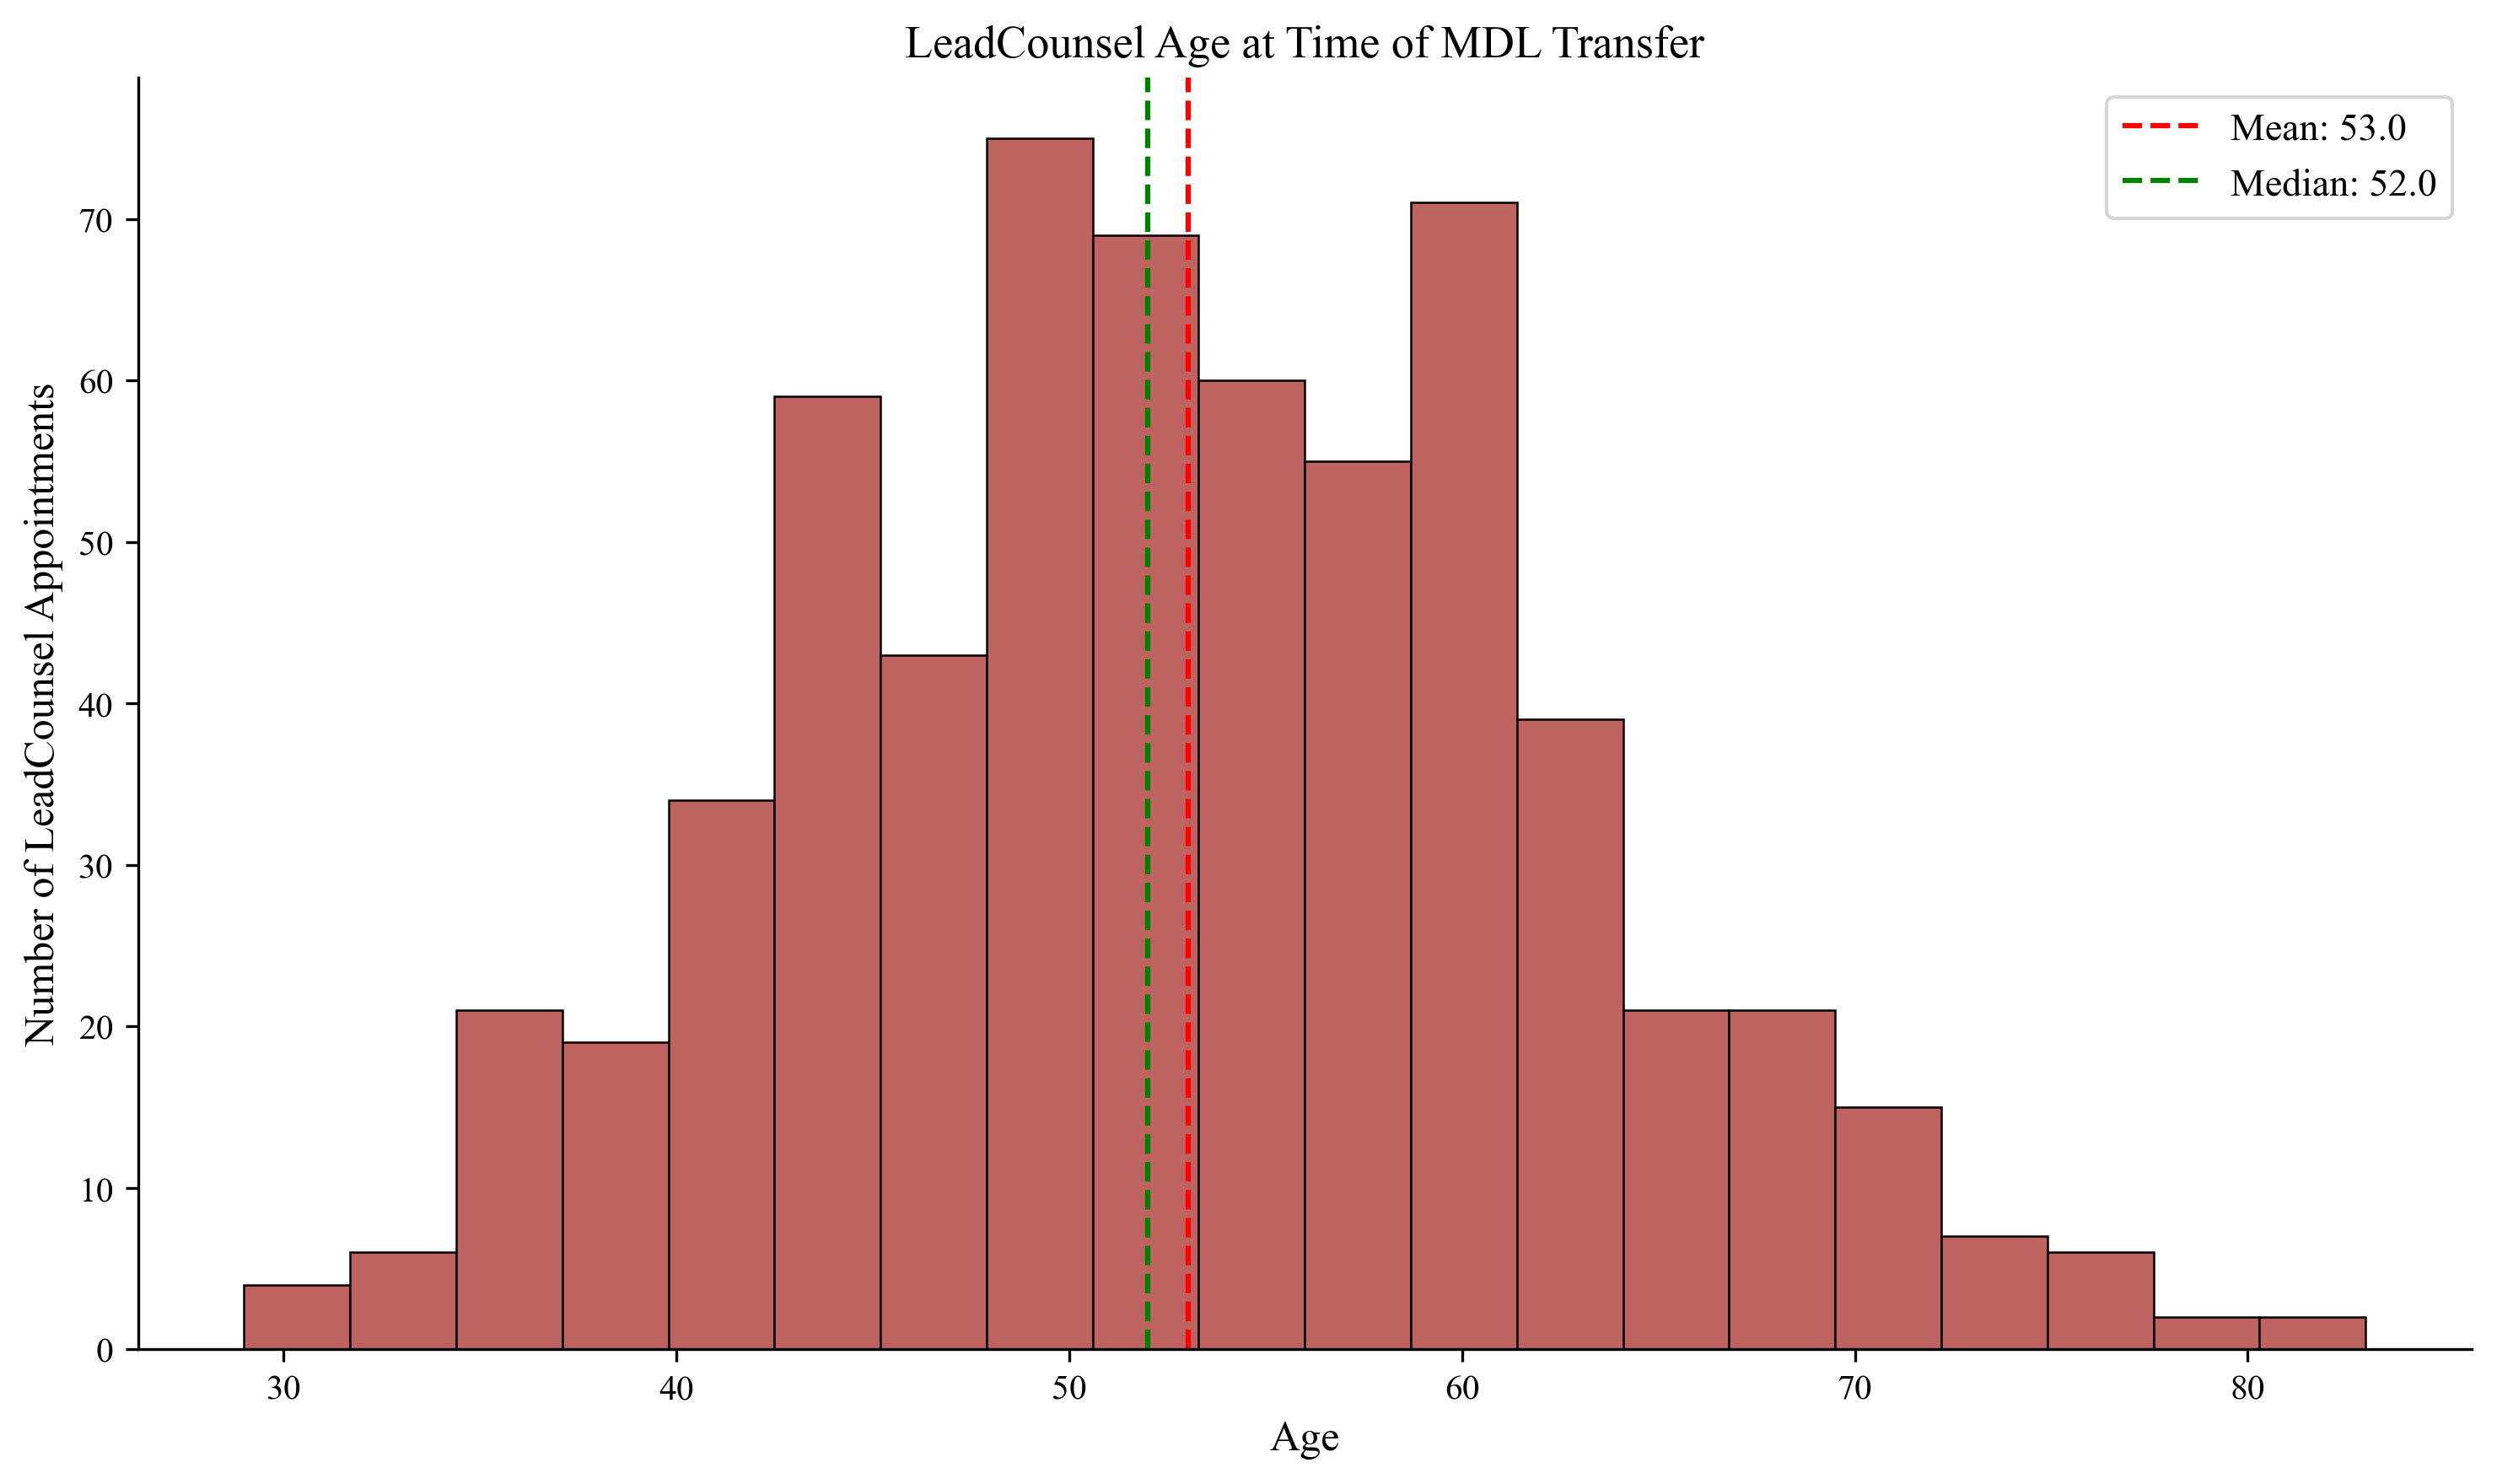

In [106]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# PLOT STYLE
# ============================================================

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300,
    "axes.linewidth": 0.8,
    "axes.edgecolor": "black",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ============================================================
# 1. FILTER TO LEAD COUNSEL APPOINTMENTS ONLY
# ============================================================

# Select only appointments where attorney has LeadCounsel role
lead = appointments_attorneys[
    appointments_attorneys['appointment_types']
    .fillna('')
    .str.contains('LeadCounsel', case=False)
].copy()

# ============================================================
# 2. MERGE WITH MDLs TO GET TRANSFER DATES
# ============================================================

# Convert transfer date column to datetime
mdls['date_transferred'] = pd.to_datetime(mdls['date_transferred'], errors='coerce')

# Join appointments with MDL transfer dates
lead = lead.merge(
    mdls[['mdl_no', 'date_transferred']],
    how='left',
    left_on='mdl_no_from_orders',
    right_on='mdl_no'
)

# ============================================================
# 3. CALCULATE ATTORNEY AGE AT TIME OF MDL TRANSFER
# ============================================================

# Drop records missing birth year or transfer date
lead = lead.dropna(subset=['birth_year', 'date_transferred'])

# Convert birth year to integer
lead['birth_year'] = lead['birth_year'].astype(int)

# Calculate age as difference between transfer year and birth year
lead['age_at_transfer'] = lead['date_transferred'].dt.year - lead['birth_year']

# ============================================================
# 4. CALCULATE SUMMARY STATISTICS
# ============================================================

# Calculate mean and median age at transfer
mean_age = lead['age_at_transfer'].mean()
median_age = lead['age_at_transfer'].median()

# ============================================================
# 5. PLOT HISTOGRAM WITH MEAN AND MEDIAN
# ============================================================

plt.figure(figsize=(10, 6))

# Create histogram with 20 bins
plt.hist(lead['age_at_transfer'], bins=20, color='#BF6360', edgecolor='black', linewidth=0.6)

# Add vertical lines for mean and median
plt.axvline(mean_age, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_age:.1f}')
plt.axvline(median_age, color='green', linestyle='--', linewidth=1.5, label=f'Median: {median_age:.1f}')

plt.title('LeadCounsel Age at Time of MDL Transfer')
plt.xlabel('Age')
plt.ylabel('Number of LeadCounsel Appointments')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Cycling in Attorney Leadership Roles



In [107]:
import pandas as pd
import numpy as np

# ============================================================
# 0. INITIALIZE DATA
# ============================================================

appts = appointments.copy()

# Restrict to plaintiff-side appointments only
appts = appts[appts["plaintiff_defendant"] == "Plaintiff"]

# ============================================================
# 1. IDENTIFY CANONICAL ATTORNEY NAME COLUMN
# ============================================================

# Find column containing attorney names (naming varies by data version)
cn_candidates = [c for c in appts.columns if "canonical" in c.lower()]

if len(cn_candidates) == 0:
    cn_candidates = [c for c in appts.columns if "first_last" in c.lower()]

canonical_col = cn_candidates[0]
appts["canonical_name"] = appts[canonical_col].astype(str).str.strip()

# ============================================================
# 2. PARSE APPOINTMENT TYPES COLUMN
# ============================================================

# Convert appointment_types to list format (may arrive as string, list, or NaN)
def ensure_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    if isinstance(x, str) and x.startswith("["):
        try:
            return eval(x)
        except:
            return []
    return [x]

appts["appointment_types"] = appts["appointment_types"].apply(ensure_list)

# ============================================================
# 3. ASSIGN STABLE FIRM PER ATTORNEY
# ============================================================

# Coerce firm column to list format
appts["firm"] = appts["firm"].apply(lambda x: x if isinstance(x, list) else [x])

def clean_firm_string(f):
    """Convert firm name to uppercase; handle missing values."""
    if f is None:
        return None
    f = str(f).strip()
    if f.lower() in ["", "nan", "none"]:
        return None
    return f.upper()

appts["firm_clean_list"] = appts["firm"].apply(
    lambda L: [clean_firm_string(i) for i in L if clean_firm_string(i) is not None]
)

def choose_stable_firm(firm_lists):
    """Select most frequent firm across all appointments for an attorney."""
    flat = [f for sub in firm_lists for f in sub if f is not None]
    if len(flat) == 0:
        return None
    return pd.Series(flat).value_counts().idxmax()

# Group by attorney and assign most common firm
stable_firms = (
    appts.groupby("attorney_id")["firm_clean_list"]
    .apply(choose_stable_firm)
    .reset_index()
    .rename(columns={"firm_clean_list": "stable_firm"})
)

appts = appts.merge(stable_firms, on="attorney_id", how="left")

# ============================================================
# 4. CONSOLIDATE MDL NUMBERS
# ============================================================

# Merge related pelvic mesh litigation into single category (MDL 9999)
pelvic_mesh_mdls = [2187, 2325, 2326, 2327, 2387, 2440]
appts["mdl_no_from_orders"] = appts["mdl_no_from_orders"].replace(
    pelvic_mesh_mdls, 9999
)

# ============================================================
# 5. AGGREGATE TO ATTORNEY × MDL LEVEL
# ============================================================

# Helper function: extract first non-empty value from list
def uniq_first(lst):
    cleaned = [v for v in lst if v not in ["", "nan", "none", None]]
    return cleaned[0] if len(cleaned) else None

# Collapse multiple appointment records into one attorney-MDL observation
final = (
    appts.groupby(["attorney_id", "mdl_no_from_orders"])
    .agg({
        "attorney": uniq_first,
        "canonical_name": uniq_first,
        "appointment_types": lambda x: sorted({
            i for L in x for i in L 
            if i not in ["", None, "nan"]
        }),
        "stable_firm": uniq_first,
    })
    .reset_index()
)

final = final.rename(columns={"stable_firm": "firm"})

# ============================================================
# 6. CLASSIFY LEAD VS SUPPORTING COUNSEL
# ============================================================

# Flag appointments marked as "LeadCounsel" in appointment types
def is_lead(appt_types):
    return "LeadCounsel" in appt_types

final["is_lead"] = final["appointment_types"].apply(is_lead)

# ============================================================
# RESULT
# ============================================================

final.head()


,attorney_id,mdl_no_from_orders,attorney,canonical_name,appointment_types,firm,is_lead
0,1,1431,1-Charles S. Zimmerman,Charles S. Zimmerman,[LeadCounsel],"ZIMMERMAN REED, PLLP",True
1,1,2323,1-Charles S. Zimmerman,Charles S. Zimmerman,[Management],"ZIMMERMAN REED, PLLP",False
2,1,2441,1-Charles S. Zimmerman,Charles S. Zimmerman,[LeadCounsel],"ZIMMERMAN REED, PLLP",True
3,1,2492,1-Charles S. Zimmerman,Charles S. Zimmerman,[Management],"ZIMMERMAN REED, PLLP",False
4,1,2522,1-Charles S. Zimmerman,Charles S. Zimmerman,"[LeadCounsel, Settlement]","ZIMMERMAN REED, PLLP",True


In [108]:
import pandas as pd
import itertools

# ============================================================
# 1. EXTRACT RELEVANT COLUMNS
# ============================================================

df = final[["mdl_no_from_orders", "attorney_id", "is_lead"]].copy()

rows = []

# ============================================================
# 2. BUILD PAIR-LEVEL DATASET
# ============================================================

# For each MDL, examine all pairs of attorneys and classify their relative ranks
for mdl, g in df.groupby("mdl_no_from_orders"):
    # Map each attorney in this MDL to their lead status
    roles = dict(zip(g["attorney_id"], g["is_lead"]))
    attys = list(roles.keys())

    # Generate all pairs of attorneys in this MDL
    for a, b in itertools.combinations(sorted(attys), 2):
        a_lead = roles[a]
        b_lead = roles[b]

        # Classify pair by relative rank in this MDL
        # A>B: attorney A is lead, B is not
        # B>A: attorney B is lead, A is not
        # TIE: both lead or both non-lead (no rank difference)
        if a_lead and not b_lead:
            cat = "A>B"
        elif b_lead and not a_lead:
            cat = "B>A"
        else:
            cat = "TIE"

        rows.append({"a": a, "b": b, "cat": cat})

pairs = pd.DataFrame(rows)

# ============================================================
# 3. IDENTIFY UNEQUAL PAIRS (HIERARCHICAL RELATIONSHIPS)
# ============================================================

# Keep only pairs where one attorney outranks the other
unequal = pairs[pairs["cat"].isin(["A>B", "B>A"])]

# ============================================================
# 4. DETECT CYCLING: PAIRS WITH REVERSING RANKS
# ============================================================

# For each unique pair, collect all ranking patterns across MDLs
# This shows whether their relative hierarchy is consistent or reverses
summary = (
    unequal.groupby(["a", "b"])["cat"]
    .apply(lambda x: set(x))
    .reset_index()
    .rename(columns={"cat": "patterns"})
)

# Flag pairs that show cycling: both A>B and B>A appear across different MDLs
# This indicates they switch hierarchical positions (e.g., A leads in MDL 1,
# but B leads in MDL 2 when they appear together)
summary["is_cycling"] = summary["patterns"].apply(
    lambda s: ("A>B" in s) and ("B>A" in s)
)

# ============================================================
# 5. CYCLING RATE
# ============================================================

# Proportion of pairs that exhibit rank reversal across MDLs
cycling_rate = summary["is_cycling"].mean()

# Express as percentage
cycling_pct = cycling_rate * 100

print(f"Cycling rate: {cycling_pct:.2f}%")

Cycling rate: 0.69%
